This project is about building a model to predict resale cost of used cars in major cities in india. Dataset used here is from hackathon hosted by [MachineHack](https://www.machinehack.com/) Go to hackathon [homepage](https://www.machinehack.com/course/predicting-the-costs-of-used-cars-hackathon-by-imarticus/) to know more about dataset.

## Loading data and packages

In [1]:
%load_ext autoreload
%autoreload 2
%autosave 5

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import multiprocessing as mp
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import shapiro, anderson, f_oneway
from category_encoders import *
#import h2o4gpu as sklearn
import pickle
from sklearn.impute import SimpleImputer
from sklearn.cluster import DBSCAN
from sklearn.ensemble import ExtraTreesClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_selection import SelectKBest, chi2
from modules.custom_transformers import *
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.preprocessing import (OneHotEncoder, FunctionTransformer, StandardScaler, RobustScaler, Normalizer, normalize)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score, mean_squared_log_error
from sklearn.model_selection import StratifiedKFold, train_test_split, ParameterGrid, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
import itertools
warnings.filterwarnings('ignore')


%matplotlib inline
sns.set() # setting seaborn default for plots


train = pd.read_excel(r'./DataSets/Data_Train.xlsx')
test = pd.read_excel(r'./DataSets/Data_Test.xlsx')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Autosaving every 5 seconds


In [13]:
training_set = train.copy()
test_set = test.copy()

### Seting parameters

In [2]:
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }

In [14]:
training_set.head()

Name    Location  Year  Kilometers_Driven  \
0            Maruti Wagon R LXI CNG      Mumbai  2010              72000   
1  Hyundai Creta 1.6 CRDi SX Option        Pune  2015              41000   
2                      Honda Jazz V     Chennai  2011              46000   
3                 Maruti Ertiga VDI     Chennai  2012              87000   
4   Audi A4 New 2.0 TDI Multitronic  Coimbatore  2013              40670   

  Fuel_Type Transmission Owner_Type     Mileage   Engine      Power  Seats  \
0       CNG       Manual      First  26.6 km/kg   998 CC  58.16 bhp    5.0   
1    Diesel       Manual      First  19.67 kmpl  1582 CC  126.2 bhp    5.0   
2    Petrol       Manual      First   18.2 kmpl  1199 CC   88.7 bhp    5.0   
3    Diesel       Manual      First  20.77 kmpl  1248 CC  88.76 bhp    7.0   
4    Diesel    Automatic     Second   15.2 kmpl  1968 CC  140.8 bhp    5.0   

   New_Price  Price  
0        NaN   1.75  
1        NaN  12.50  
2  8.61 Lakh   4.50  
3        NaN   6.00  
4        NaN  17.74

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6019 entries, 0 to 6018
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               6019 non-null   object 
 1   Location           6019 non-null   object 
 2   Year               6019 non-null   int64  
 3   Kilometers_Driven  6019 non-null   int64  
 4   Fuel_Type          6019 non-null   object 
 5   Transmission       6019 non-null   object 
 6   Owner_Type         6019 non-null   object 
 7   Mileage            6017 non-null   object 
 8   Engine             5983 non-null   object 
 9   Power              5876 non-null   object 
 10  Seats              5977 non-null   float64
 11  New_Price          824 non-null    object 
 12  Price              6019 non-null   float64
dtypes: float64(2), int64(2), object(9)
memory usage: 611.4+ KB


In [31]:
print('\nNo of features in Trainset:', train.shape[1])
print('\nNo of features in Testset:', test.shape[1])

print('\nfeatures in Trainset:\n-', '\n- '.join(list(train.columns)))
print('\nfeatures in Testset:\n-', '\n- '.join(list(test.columns)))

print('\nfeatures datatypes in Trainset:\n', train.dtypes)
print('\nfeatures datatypes in Testset:\n', test.dtypes)

print('\nEmpty cells in the TrainSet:\n', train.isnull().values.sum())
print('\nEmpty cells in the TestSet:\n', test.isnull().values.sum())


No of features in Trainset: 13

No of features in Testset: 12

features in Trainset:
- Name
- Location
- Year
- Kilometers_Driven
- Fuel_Type
- Transmission
- Owner_Type
- Mileage
- Engine
- Power
- Seats
- New_Price
- Price

features in Testset:
- Name
- Location
- Year
- Kilometers_Driven
- Fuel_Type
- Transmission
- Owner_Type
- Mileage
- Engine
- Power
- Seats
- New_Price

features datatypes in Trainset:
 Name                  object
Location              object
Year                   int64
Kilometers_Driven      int64
Fuel_Type             object
Transmission          object
Owner_Type            object
Mileage               object
Engine                object
Power                 object
Seats                float64
New_Price             object
Price                float64
dtype: object

features datatypes in Testset:
 Name                  object
Location              object
Year                   int64
Kilometers_Driven      int64
Fuel_Type             object
Transmission     

In [32]:
# lets count uniques values in each column
unique_cnt = list(map(lambda x: len(training_set[x].unique()), list(training_set)))
print('unique counts in each column:')
dict(zip(list(training_set),unique_cnt))

unique counts in each column:


{'Name': 1876,
 'Location': 11,
 'Year': 22,
 'Kilometers_Driven': 3093,
 'Fuel_Type': 5,
 'Transmission': 2,
 'Owner_Type': 4,
 'Mileage': 443,
 'Engine': 147,
 'Power': 372,
 'Seats': 10,
 'New_Price': 541,
 'Price': 1373}

In [33]:
#combining training set and test set data
all_brands = list(training_set.Name) + list(test_set.Name)
all_locations = list(training_set.Location) + list(test_set.Location)
all_fuel_types = list(training_set.Fuel_Type) + list(test_set.Fuel_Type)
all_transmissions = list(training_set.Transmission) + list(test_set.Transmission)
all_owner_types = list(training_set.Owner_Type) + list(test_set.Owner_Type)

print("\nNumber Of Unique Values In Name : \n ", len(set(all_brands)))
#print("\nThe Unique Values In Name : \n ", set(all_brands))

print("\nNumber Of Unique Valuesa In Location : \n ", len(set(all_locations)))
print("\nThe Unique Values In Location : \n ", set(all_locations) )

print("\nNumber Of Unique Values In Fuel_Type : \n ", len(set(all_fuel_types)))
print("\nThe Unique Values In Fuel_Type : \n ", set(all_fuel_types) )

print("\nNumber Of Unique Values In Transmission : \n ", len(set(all_transmissions)))
print("\nThe Unique Values In Transmission : \n ", set(all_transmissions) )

print("\nNumber Of Unique Values In Owner_Type : \n ", len(set(all_owner_types)))
print("\nThe Unique Values In Owner_Type : \n '' ",set(all_owner_types))


Number Of Unique Values In Name : 
  2041

Number Of Unique Valuesa In Location : 
  11

The Unique Values In Location : 
  {'Delhi', 'Hyderabad', 'Mumbai', 'Coimbatore', 'Bangalore', 'Kochi', 'Ahmedabad', 'Jaipur', 'Chennai', 'Kolkata', 'Pune'}

Number Of Unique Values In Fuel_Type : 
  5

The Unique Values In Fuel_Type : 
  {'Diesel', 'LPG', 'Electric', 'Petrol', 'CNG'}

Number Of Unique Values In Transmission : 
  2

The Unique Values In Transmission : 
  {'Automatic', 'Manual'}

Number Of Unique Values In Owner_Type : 
  4

The Unique Values In Owner_Type : 
 ''  {'Second', 'First', 'Third', 'Fourth & Above'}


### Data Cleaning

In [34]:
def F_Clean(x):
    try:
        return x.split(' ')[0].strip()
    except:
        return np.nan
    
# Remove unites from Milage and covert to float 
training_set['Mileage'] = [float(F_Clean(i)) for i in training_set.Mileage]
test_set['Mileage'] = [float(F_Clean(i)) for i in test_set.Mileage]

# Remove units from Engine and covert to strings 
training_set['Engine'] = [float(F_Clean(i)) for i in training_set.Engine]
test_set['Engine'] = [float(F_Clean(i)) for i in test_set.Engine]

training_set['Power'] = [float(F_Clean(i)) for i in training_set.Power]
test_set['Power'] = [float(F_Clean(i)) for i in test_set.Power]

# Drop New_price feature as it contians significant null values
training_set.drop(labels=['New_Price'],axis=1,inplace=True)
test_set.drop(labels=['New_Price'],axis=1,inplace=True)

## Data Exploration

### Univariate Analysis

#### Name

In [17]:
training_set = pd.read_csv('DataSets/TrainSet_Cleaned.csv')

Top 10 cars:

Mahindra XUV500 W8 2WD        49
Maruti Swift VDI              45
Maruti Swift Dzire VDI        34
Honda City 1.5 S MT           34
Maruti Swift VDI BSIV         31
Maruti Ritz VDi               30
Hyundai i10 Sportz            30
Toyota Fortuner 3.0 Diesel    29
Hyundai Grand i10 Sportz      27
Honda Amaze S i-Dtech         27
Name: Name, dtype: int64


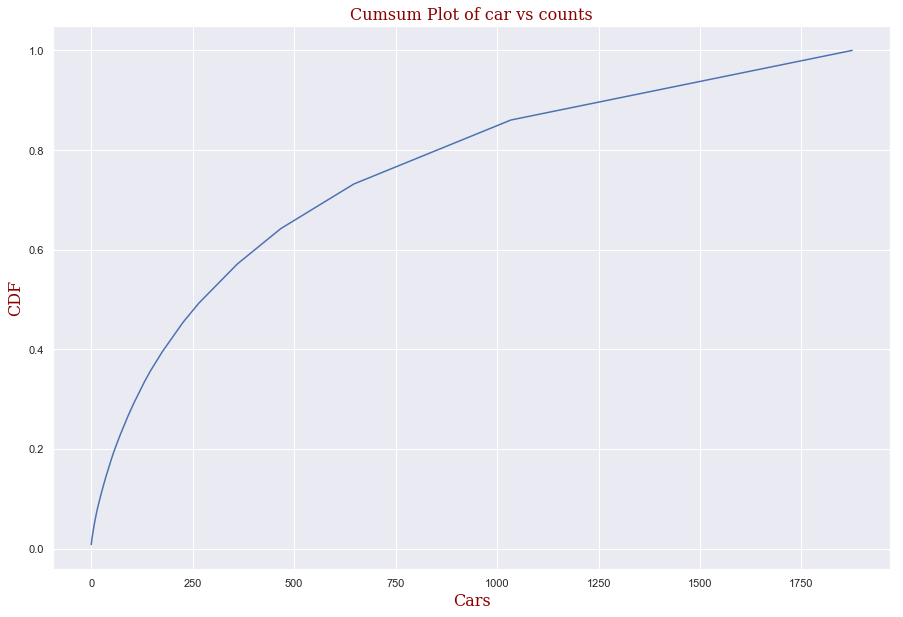

In [21]:
# Cumsum plot to see decide cutoff point

print("Top 10 cars:\n")
print(training_set.Name.value_counts().head(10))
      
y = training_set.Name.value_counts(normalize=True).cumsum()
x = len(y)

plt.figure(figsize=(15,10))
plt.plot(range(x),y);
plt.title('Cumsum Plot of car vs counts', fontdict = font)
plt.xlabel('Cars', fontdict = font)
plt.ylabel('CDF', fontdict = font);

* There are over 1800 varities of cars. Some are widely owned and some are rare
* Roughly, 800 cars makes up 80% and rest 1000 only occupies 20%
* There are lot of categoreies in this to handle, we deal with later.

#### Split name into Brand + Model  

First word in the Names corressponds to Brand and rest of it corresponds to Model, series, sub series. Along with "brand" we need to decide how many words of keep for Model  

In [100]:
print("Max length available for assigning Model:")
print(min(list(map(lambda x: len(x.split(' ')), training_set.Name)))-1) # -1 as first word dedicated to Brand 

Max length available for assigning Model:
2


We could use combined second and third word (upto 2 words) for Model feature.

In [102]:
# no of uniques when when only 2nd variable is considered

print("no of uniques when when only 2nd word is considered:")
print(len(set([i.split(' ')[1].strip() for i in training_set.Name])))

print("no of uniques when 2nd and 3rd word is considered:")
print(len(set([' '.join(i.split(' ')[1:3]).strip() for i in training_set.Name])))


no of uniques when when only 2nd word is considered:
212
no of uniques when 2nd and 3rd word is considered:
689


We are creting lot of actgories if we go with 2ns and 3rd there fore I used only second word of Model feature 

In [105]:
# Split Car name feature into Brand and Model features for both sets 
Brands = training_set.Name.apply(lambda x: x.split(' ')[0])
Models = training_set.Name.apply(lambda x: x.split(' ')[1])

Top 10 Brands:

Maruti           1211
Hyundai          1107
Honda             608
Toyota            411
Mercedes-Benz     318
Volkswagen        315
Ford              300
Mahindra          272
BMW               267
Audi              236
Name: Name, dtype: int64
Top 10 Models:

Swift     353
City      270
i20       247
Verna     170
Innova    164
Grand     156
i10       156
Wagon     154
Polo      151
Alto      143
Name: Name, dtype: int64


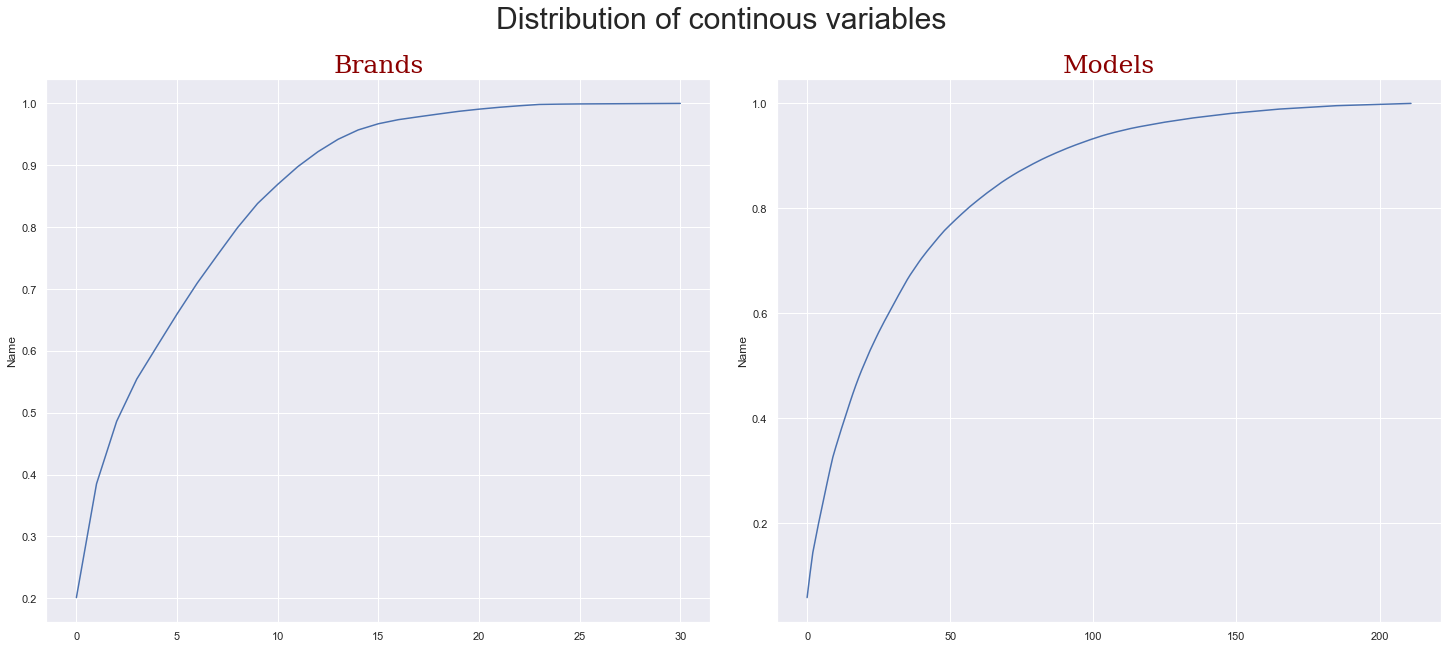

In [128]:
print("Top 10 Brands:\n")
print(Brands.value_counts().head(10))

print("Top 10 Models:\n")
print(Models.value_counts().head(10))
      
y = training_set.Name.value_counts(normalize=True).cumsum()
x = len(y)

fig,axes = plt.subplots(1,2,figsize=(25,10))
fig.subplots_adjust(wspace=0.1, hspace=0.3)
fig.suptitle('Distribution of continous variables', fontsize=30)
axes = axes.ravel()

for i,var in enumerate([Brands, Models]):
    y = var.value_counts(normalize=True).cumsum()
    sns.lineplot(x=range(len(y)), y=y, ax = axes[i]);
    plt.title('Cumsum Plot of car vs counts', fontdict = font)
    axes[i].set_title(['Brands', 'Models'][i],fontdict = font, fontsize=25)


* Just 8 Brands make up 80% and rest occupies 20%
* Roughly, 55 Models make up 80% and rest occupies 20%

#### Categorical and ordinal variables

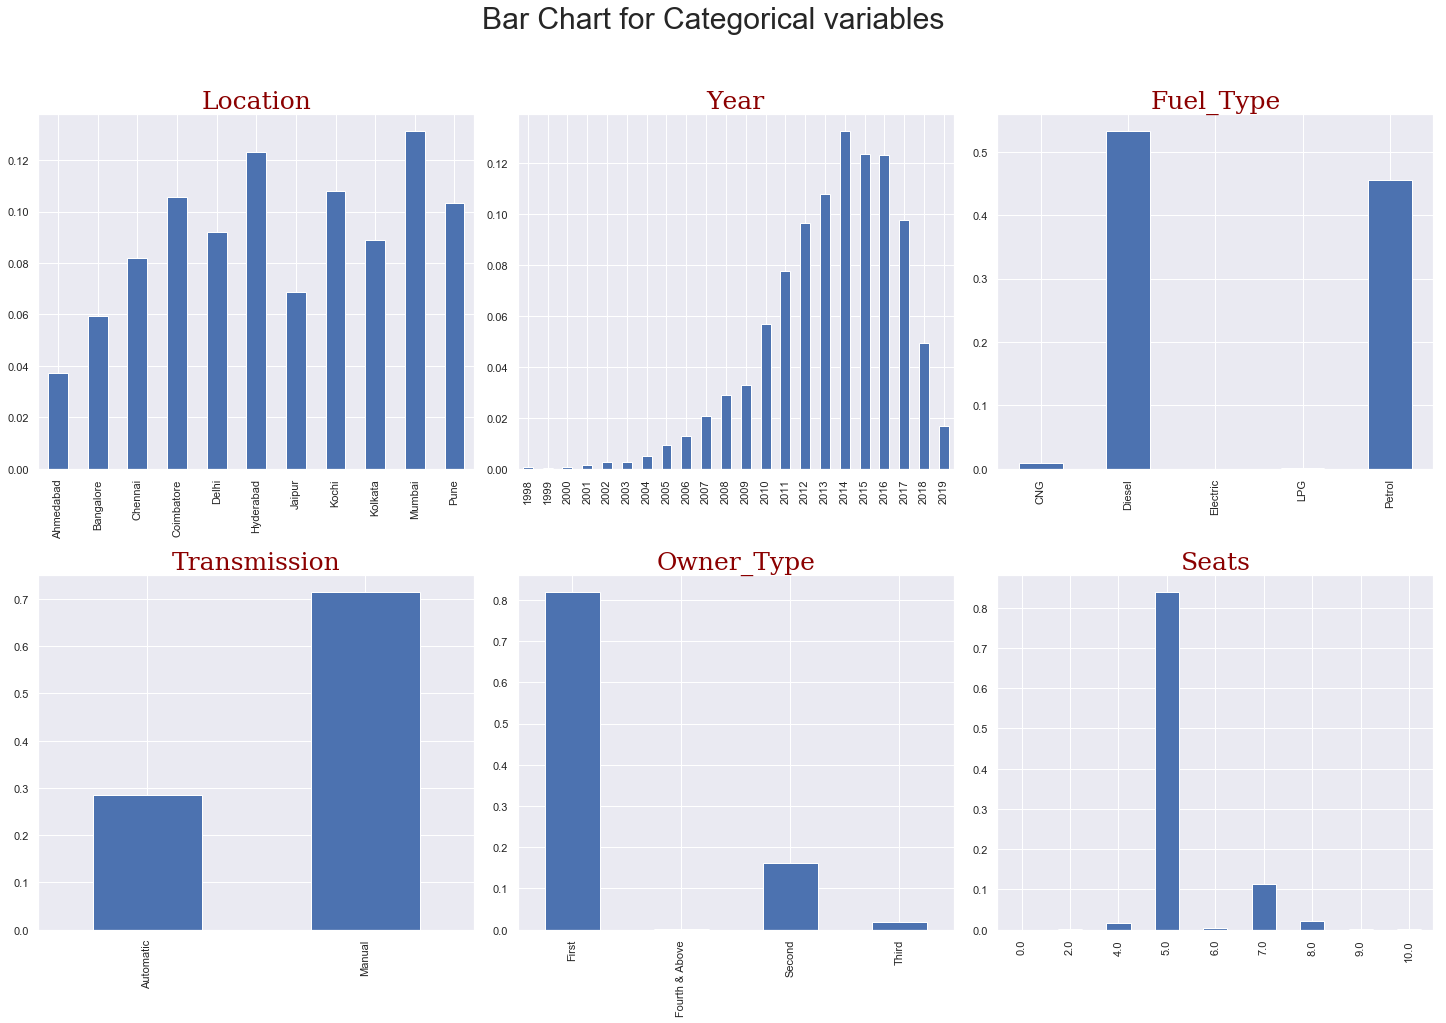

In [50]:
cat_cols = ['Location','Year', 'Fuel_Type','Transmission', 'Owner_Type','Seats']
fig,axes = plt.subplots(2,3,figsize=(25,15))
fig.subplots_adjust(wspace=0.1, hspace=0.3)
fig.suptitle('Bar Chart for Categorical variables', fontsize=30)
axes = axes.ravel()


for i,col in enumerate(cat_cols):
    training_set[col].value_counts(normalize=True, sort=False).sort_index(ascending=True)
    axes[i].set_title(col,fontdict = font, fontsize=25)    #axes[i].set_title(col,fontsize=25)
    axes[i].xaxis.get_label().set_fontsize(20)
    #axes[i].axis('off')
#fig.delaxes(axes[-1])
#fig.delaxes(axes[-2])

1. Location: 
     * Mumbai has cars sellers and Amdhabad has least with no significant count diffenerce across categories
     * One Hot encoding would add 22 extra features, May be mean encoding could be used but confirmed if we find price distribution across cities.
2. Year:
    * Recent years has high contributon i.e models manufactered over this period are high traded.
    * Since variable is ordinal encoded we could tranform by curr_year(2019)-year meaning older the car more is drepriciation
3. Fuel_type:
    * Desieal and Petrol contitutes more 
    * Onhot-encoding only for Desiel and pentrol would work fine.
4. Trnasmission:
    * Manual is More We coud use Lable encoding (Same as binary encoding)
5. OWner_type
    * First is more about 80%
    * one hot encoding for top two categories would work
6. Seats
    * 5 seater is more we could use feature as is

#### Countinous variable

In [52]:
training_set.Engine.unique().min()

624.0

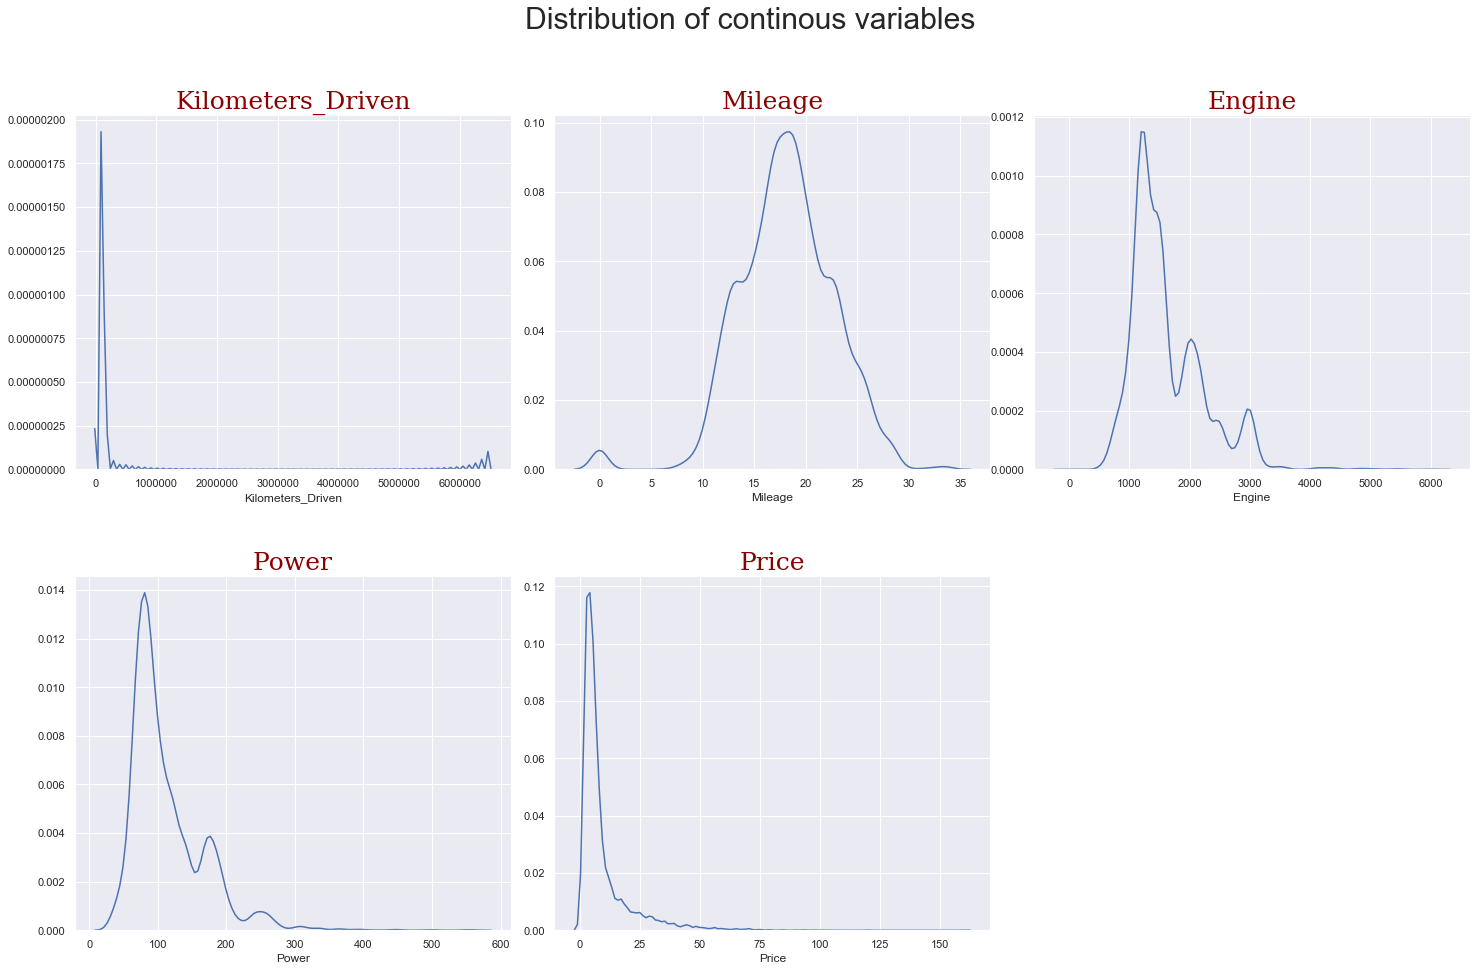

In [85]:
con_cols = ['Kilometers_Driven','Mileage', 'Engine', 'Power', "Price"]
fig,axes = plt.subplots(2,3,figsize=(25,15))
fig.subplots_adjust(wspace=0.1, hspace=0.3)
fig.suptitle('Distribution of continous variables', fontsize=30)
axes = axes.ravel()

for i,col in enumerate(con_cols):
    sns.distplot((training_set[col][~pd.isna(training_set[col])]), hist= False,ax=axes[i])
    axes[i].set_title(col,fontdict = font, fontsize=25)    #axes[i].set_title(col,fontsize=25)
fig.delaxes(axes[-1])

* Kilometer driven: highly skewed may we should apply log transformation
* log transformation may be applied for Engine and Power as well

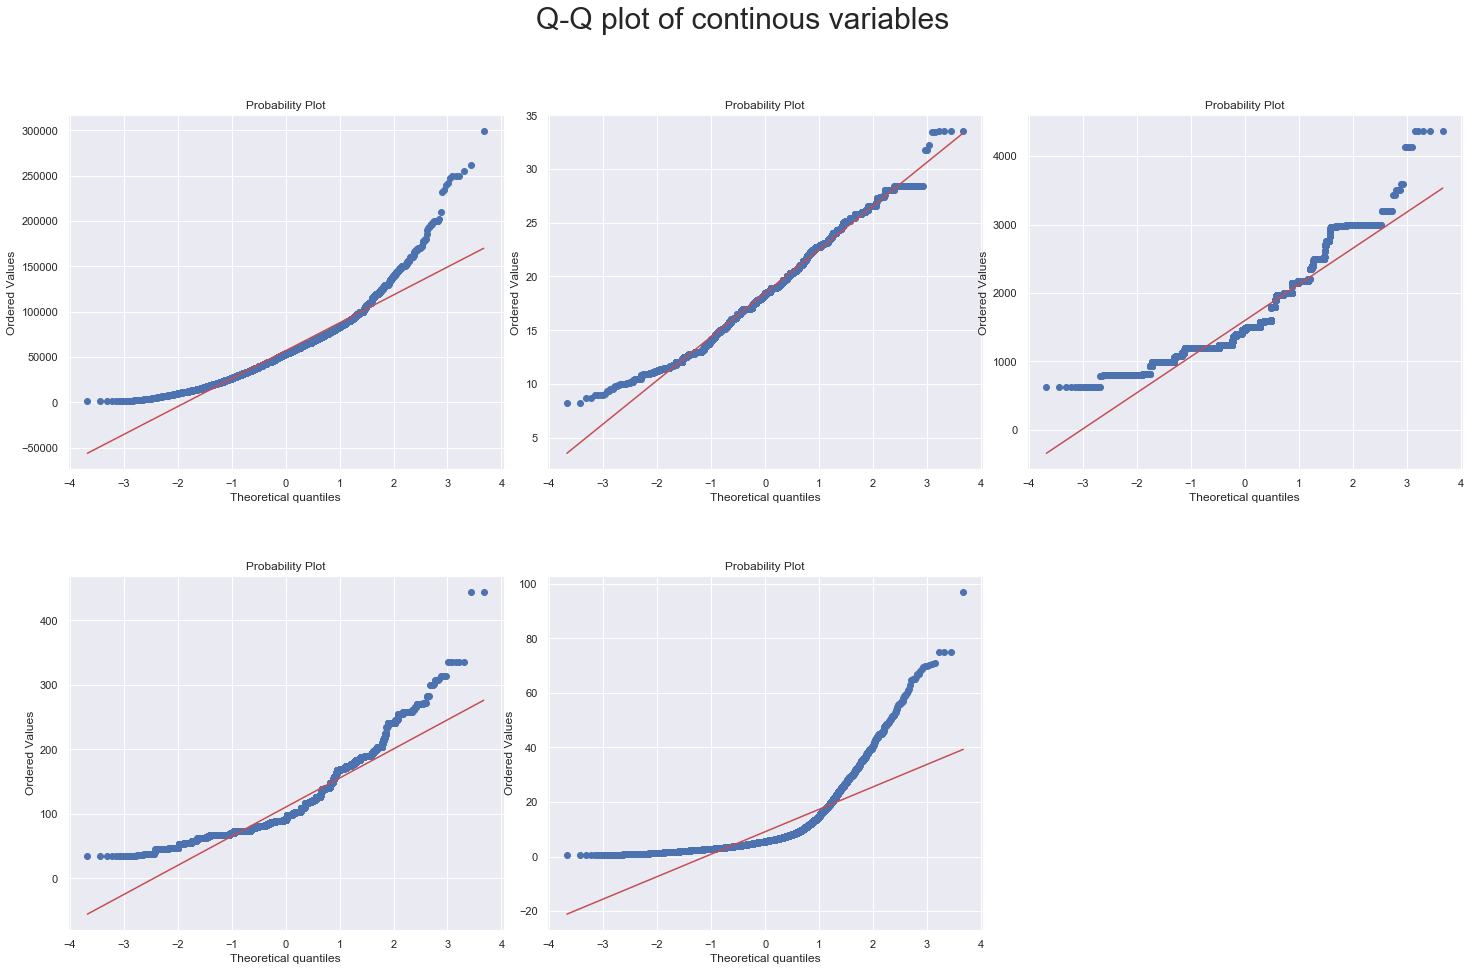

In [42]:
con_cols = ['Kilometers_Driven','Mileage', 'Engine', 'Power', "Price"]
fig,axes = plt.subplots(2,3,figsize=(25,15))
fig.subplots_adjust(wspace=0.1, hspace=0.3)
fig.suptitle('Q-Q plot of continous variables', fontsize=30)
axes = axes.ravel()

for i,col in enumerate(con_cols):
    res = stats.probplot((training_set[col][~pd.isna(training_set[col])]), plot=axes[i])
fig.delaxes(axes[-1])

##### Countinous variable with log applied

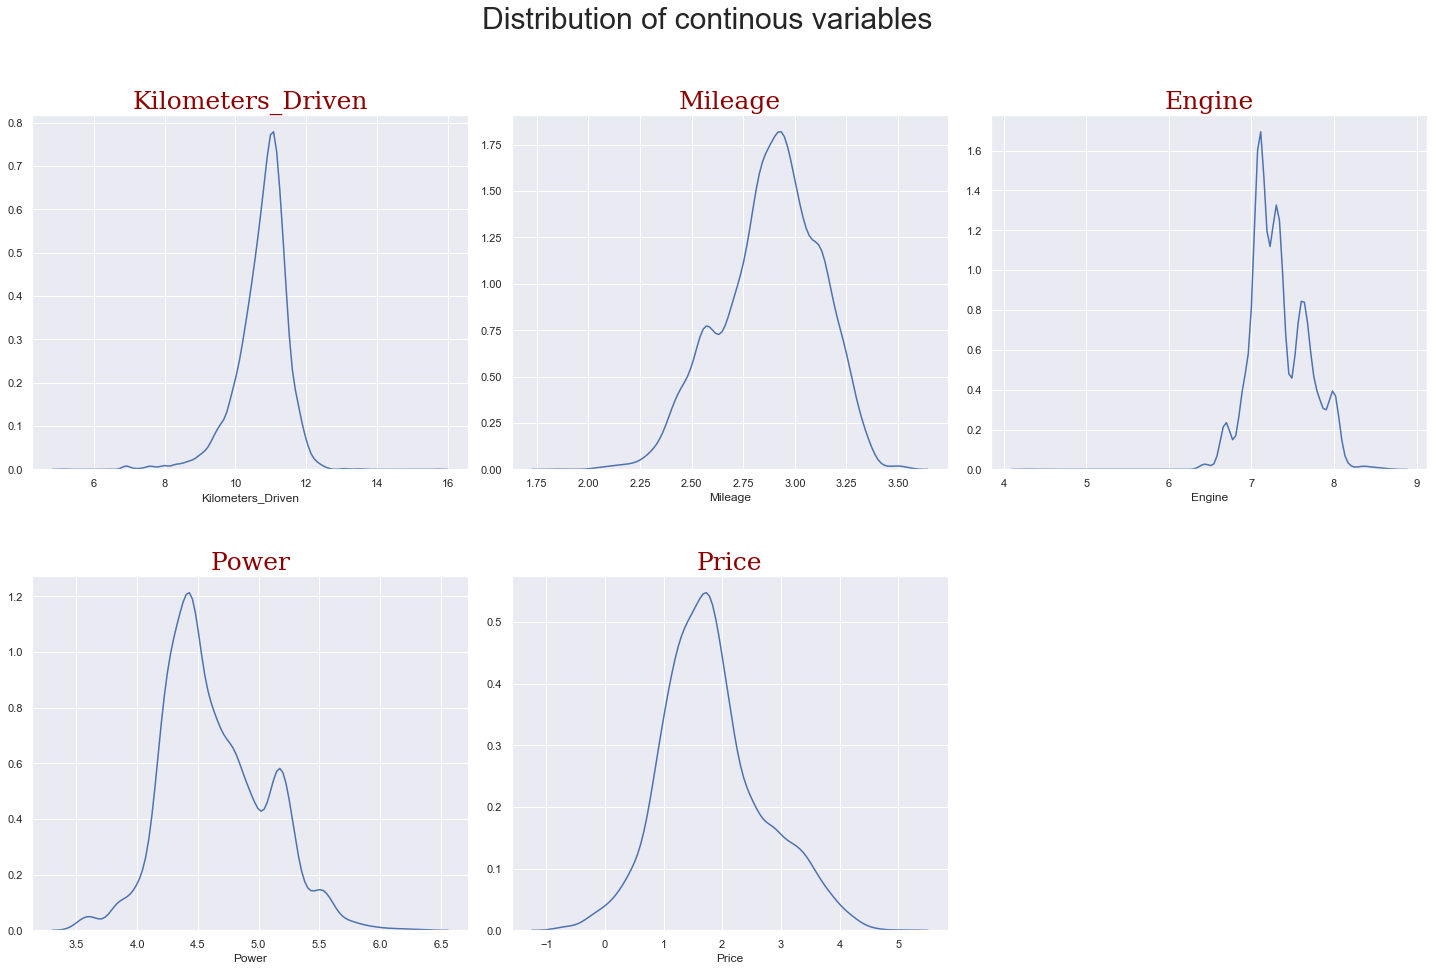

In [86]:
con_cols = ['Kilometers_Driven','Mileage', 'Engine', 'Power', "Price"]
fig,axes = plt.subplots(2,3,figsize=(25,15))
fig.subplots_adjust(wspace=0.1, hspace=0.3)
fig.suptitle('Distribution of continous variables', fontsize=30)
axes = axes.ravel()

for i,col in enumerate(con_cols):
    sns.distplot((training_set[col][~pd.isna(training_set[col])]).apply(np.log), hist= False,ax=axes[i])
    axes[i].set_title(col,fontdict = font, fontsize=25)    #axes[i].set_title(col,fontsize=25)
fig.delaxes(axes[-1])

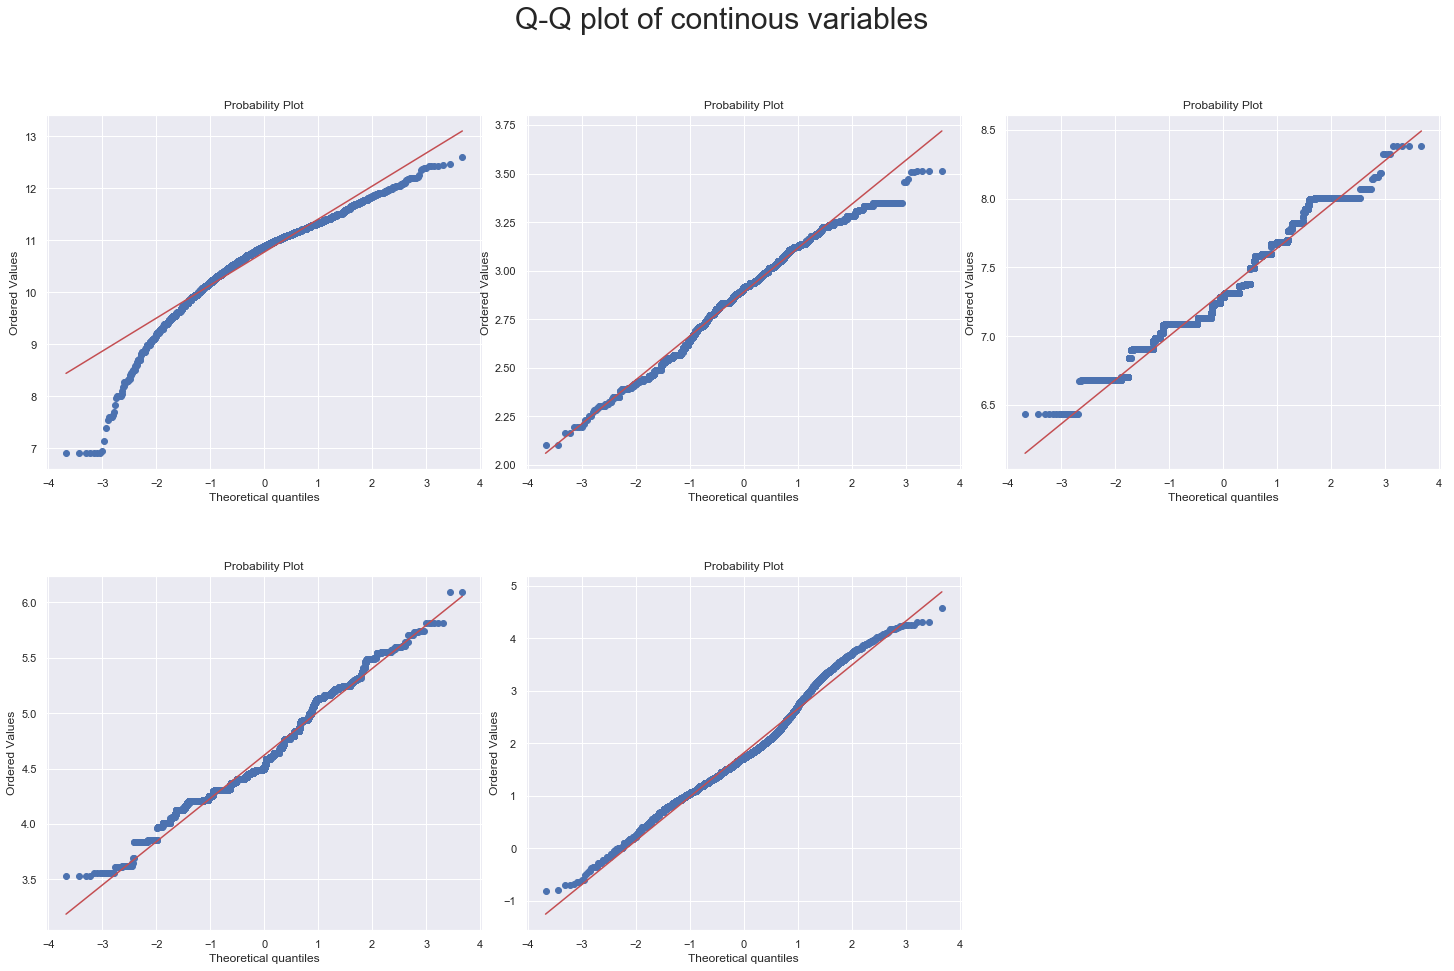

In [41]:
con_cols = ['Kilometers_Driven','Mileage', 'Engine', 'Power', "Price"]
fig,axes = plt.subplots(2,3,figsize=(25,15))
fig.subplots_adjust(wspace=0.1, hspace=0.3)
fig.suptitle('Q-Q plot of Log transformed variables', fontsize=30)
axes = axes.ravel()

for i,col in enumerate(con_cols):
    res = stats.probplot((training_set[col][~pd.isna(training_set[col])]).apply(np.log), plot=axes[i])
fig.delaxes(axes[-1])

#### OutLier Detection

##### Uni - variate

In [51]:
list(itertools.combinations(con_cols, 2))

[('Kilometers_Driven', 'Mileage'),
 ('Kilometers_Driven', 'Engine'),
 ('Kilometers_Driven', 'Power'),
 ('Kilometers_Driven', 'Price'),
 ('Mileage', 'Engine'),
 ('Mileage', 'Power'),
 ('Mileage', 'Price'),
 ('Engine', 'Power'),
 ('Engine', 'Price'),
 ('Power', 'Price')]

NameError: name 'font' is not defined

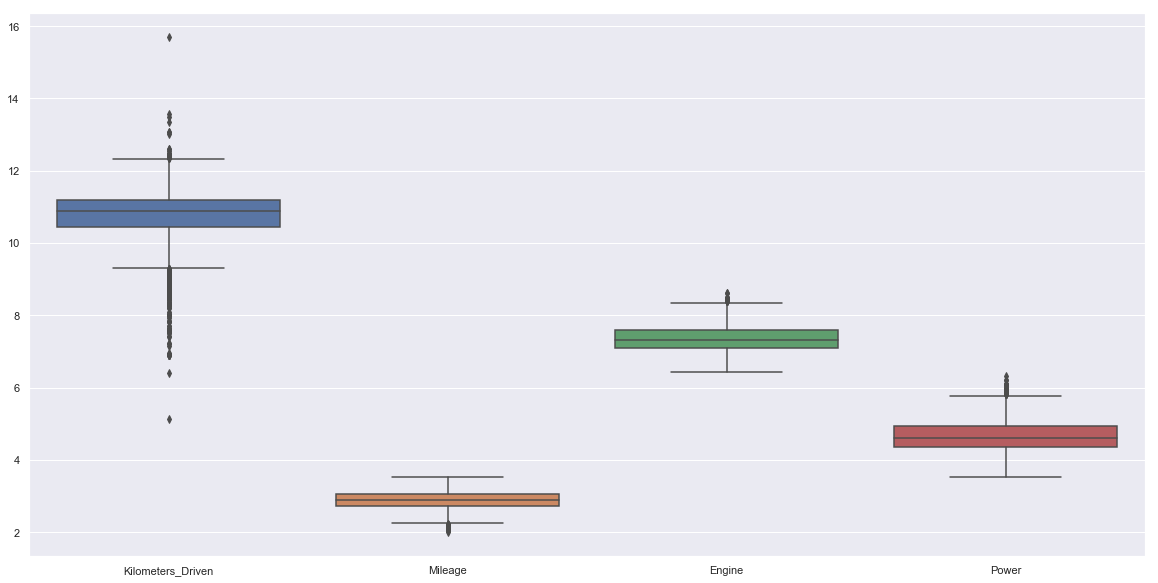

In [27]:
plt.figure(figsize=(20,10))

# Log tranformation
sns.boxplot(data=training_set[con_cols].apply(np.log));
plt.title("Box plot of "+", ".join(con_cols), fontdict = font);

##### Bi - variate

In [5]:
import pixiedust

AttributeError: module 'pixiedust' has no attribute 'utils'

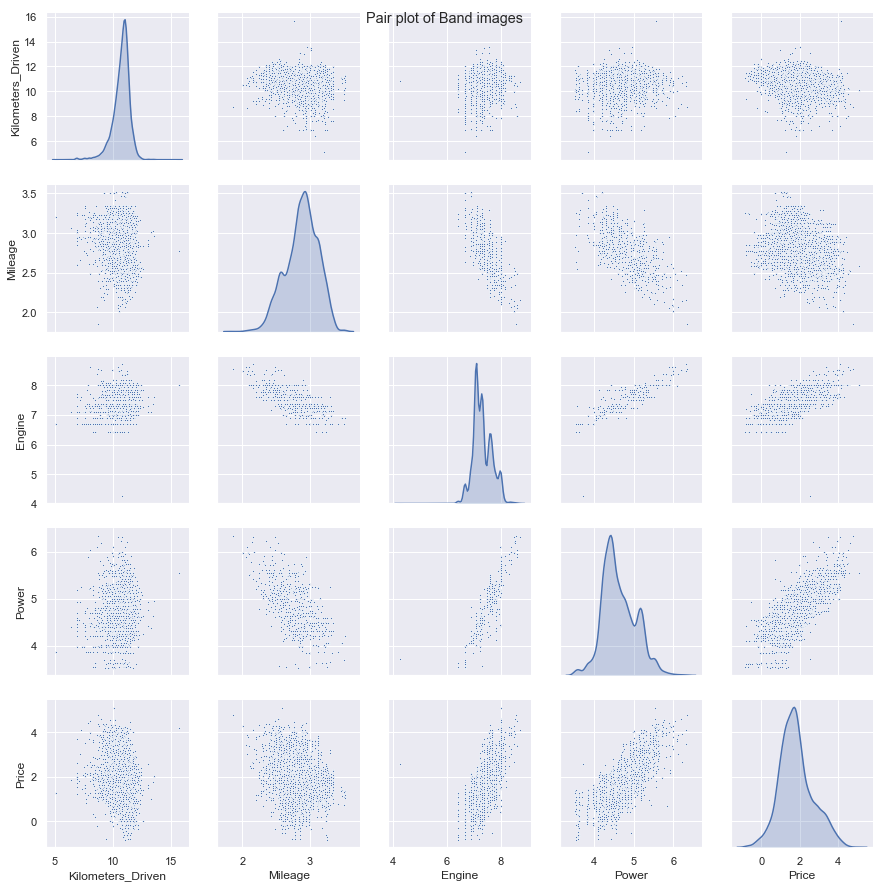

In [77]:
import itertools
con_cols = ['Kilometers_Driven','Mileage', 'Engine', 'Power', "Price"]

a = sns.pairplot(data=training_set[con_cols].apply(np.log),
                 diag_kind='kde',plot_kws={"s": 5})
a.fig.suptitle("Pair plot of Band images");


### Bivariate Analysis

#### Brand vs other

'Location', 'Year', 'Kilometers_Driven', 'Fuel_Type',
       'Transmission', 'Owner_Type', 'Mileage', 'Engine', 'Power', 'Seats',
       'New_Price', 'Price']

##### Brand vs Categorical

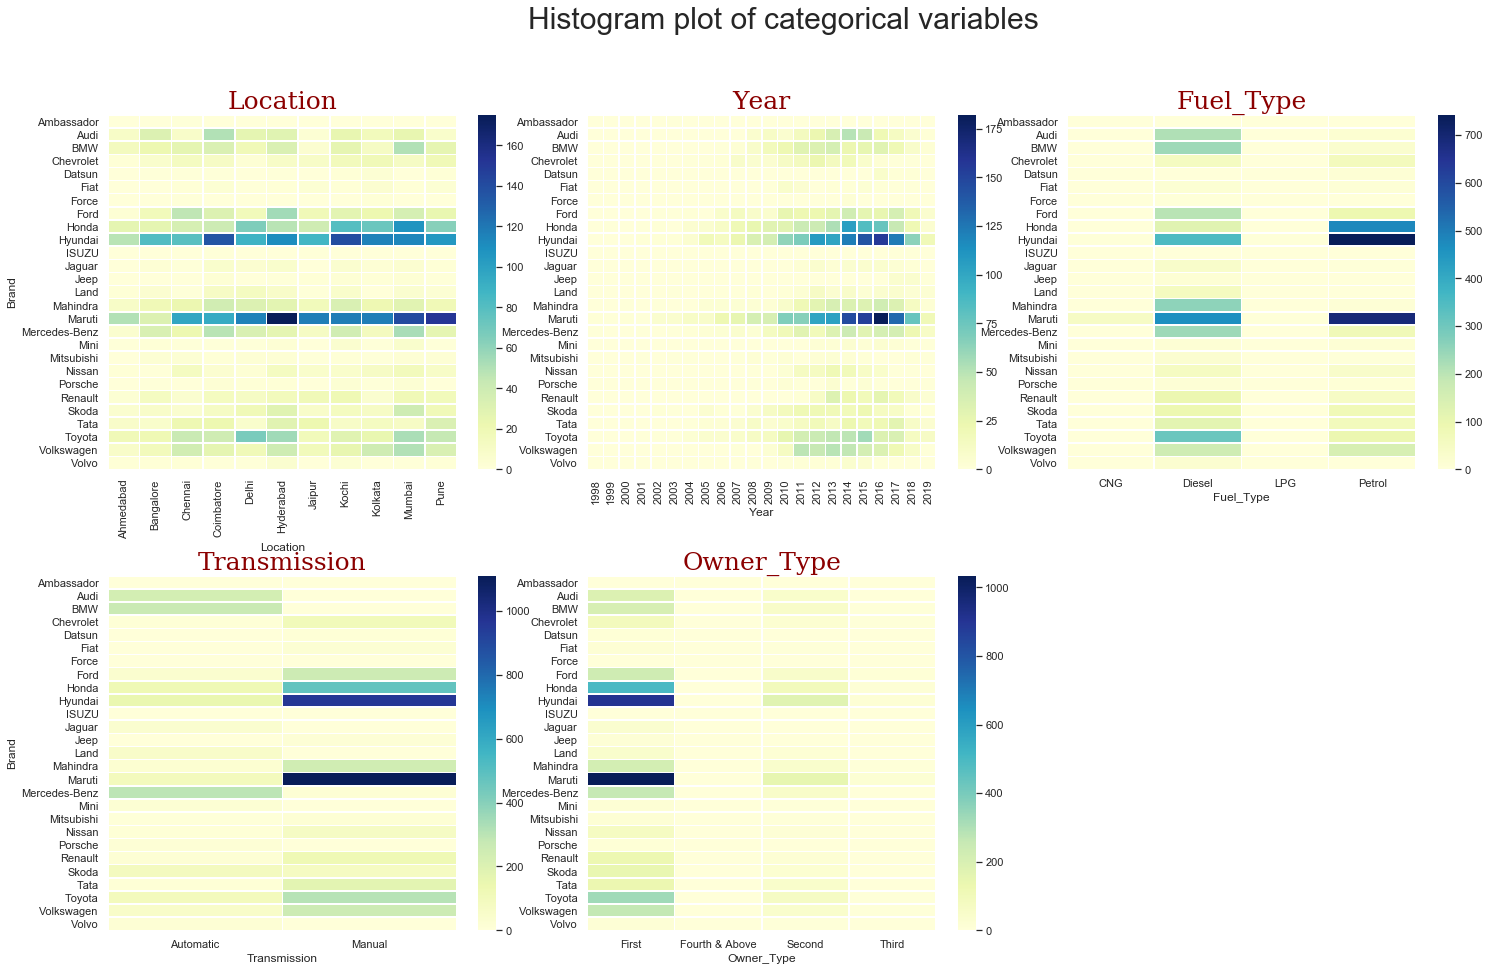

In [16]:
cols = ['Location', 'Year', 'Fuel_Type', 'Transmission', 'Owner_Type']

fig,axes = plt.subplots(2,3,figsize=(25,15))
fig.subplots_adjust(wspace=0.1, hspace=0.3)
fig.suptitle('Histogram plot of categorical variables', fontsize=30)
axes = axes.ravel()

for i,col in enumerate(cols):
    tab = pd.crosstab(index=training_set.Brand,columns=training_set[col])
    sns.heatmap(tab,linewidths=0.5,cmap="YlGnBu", ax=axes[i])    
    axes[i].set_title(col,fontdict = font, fontsize=25)    #axes[i].set_title(col,fontsize=25)
fig.delaxes(axes[-1])

##### Brand vs Continous

In [55]:
training_set.columns

Index(['Brand', 'Model', 'Location', 'Year', 'Kilometers_Driven', 'Fuel_Type',
       'Transmission', 'Owner_Type', 'Mileage', 'Engine', 'Power', 'Seats',
       'Price'],
      dtype='object')

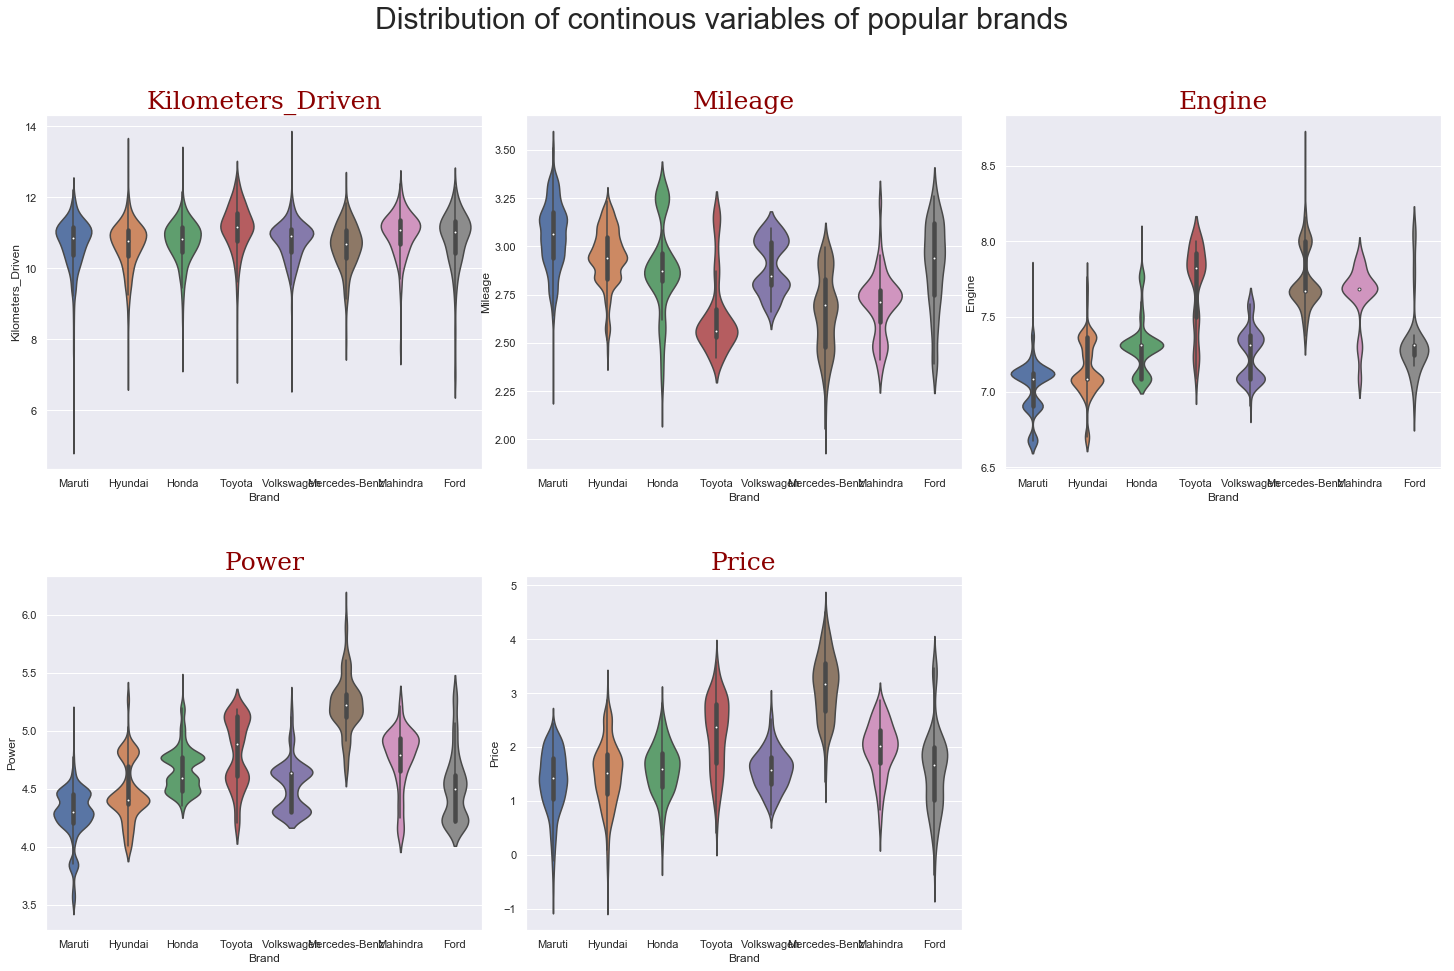

In [13]:
cols = ['Kilometers_Driven', 'Mileage', 'Engine', 'Power', 'Price']

inds = training_set.Brand.isin(training_set.Brand.value_counts().head(8).index)

fig,axes = plt.subplots(2,3,figsize=(25,15))
fig.subplots_adjust(wspace=0.1, hspace=0.3)
fig.suptitle('Distribution of continous variables of popular brands', fontsize=30)
axes = axes.ravel()

for i,col in enumerate(cols):
    s = training_set.loc[~pd.isna(training_set[col]),col].apply(np.log)
    s = s[~s.isin([-np.inf])]
    sns.violinplot(x=training_set.Brand[inds], y=s, ax=axes[i])    
    axes[i].set_title(col,fontdict = font, fontsize=25)
fig.delaxes(axes[-1])

The model feature has been created with below points in mind:
1. There should  exist variability across the models which makes good for prediction and 
2. also there should be less variability within a model.

#### Models

##### Models vs categorical

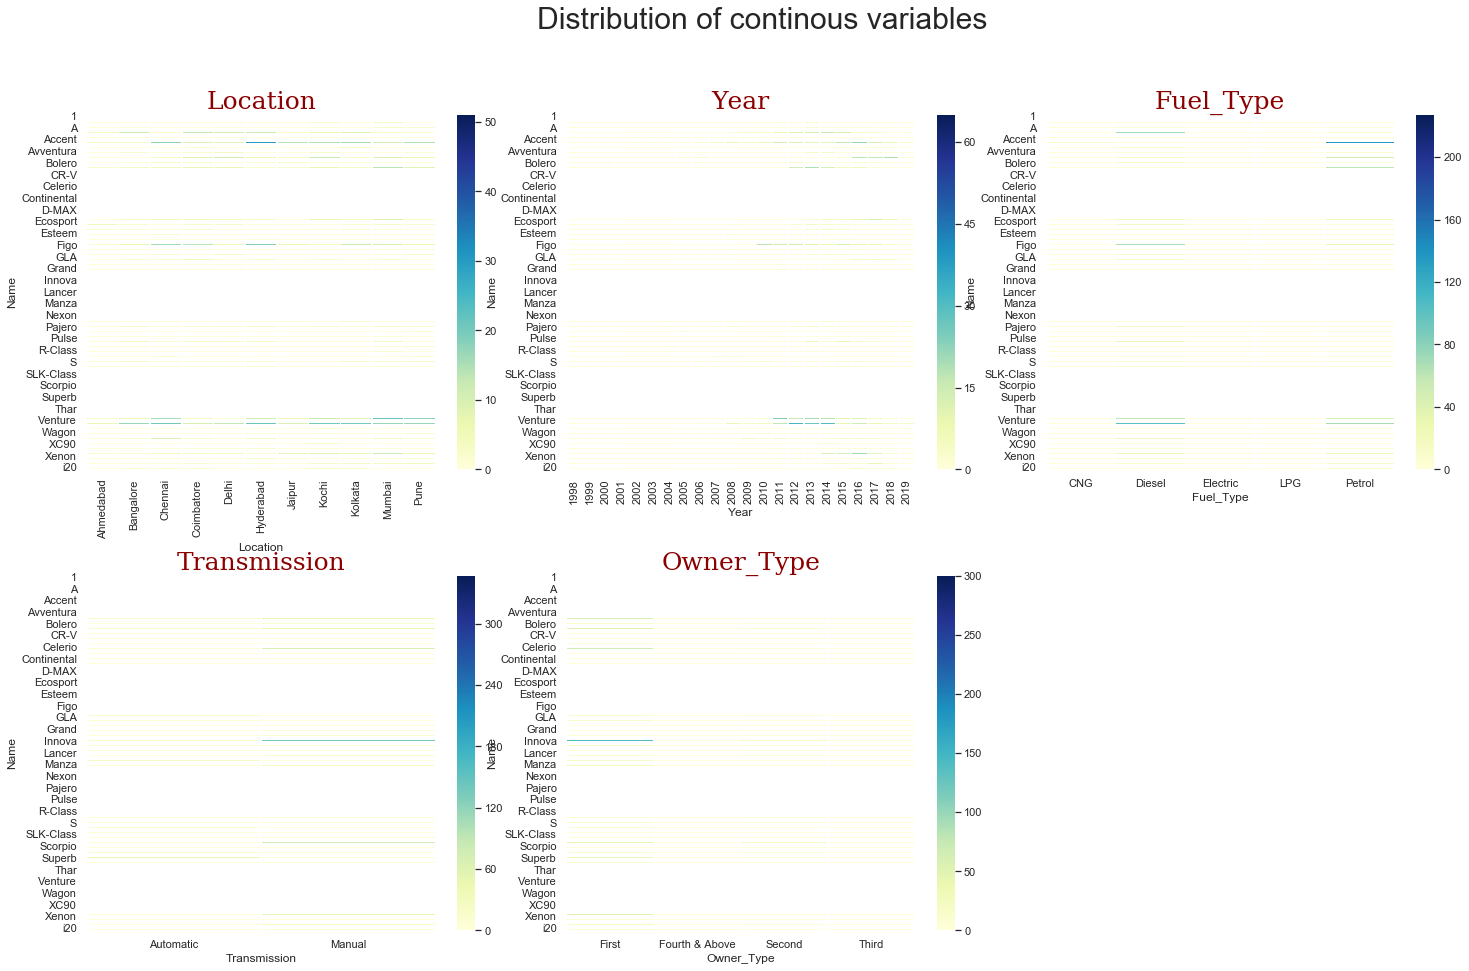

In [197]:
cols = ['Location', 'Year', 'Fuel_Type', 'Transmission', 'Owner_Type']

fig,axes = plt.subplots(2,3,figsize=(25,15))
fig.subplots_adjust(wspace=0.1, hspace=0.3)
fig.suptitle('Distribution of continous variables', fontsize=30)
axes = axes.ravel()

for i,col in enumerate(cols):
    tab = pd.crosstab(index=Models,columns=training_set[col])
    sns.heatmap(tab,linewidths=0.5,cmap="YlGnBu", ax=axes[i])    
    axes[i].set_title(col,fontdict = font, fontsize=25)    #axes[i].set_title(col,fontsize=25)
fig.delaxes(axes[-1])

##### Models vs Continous

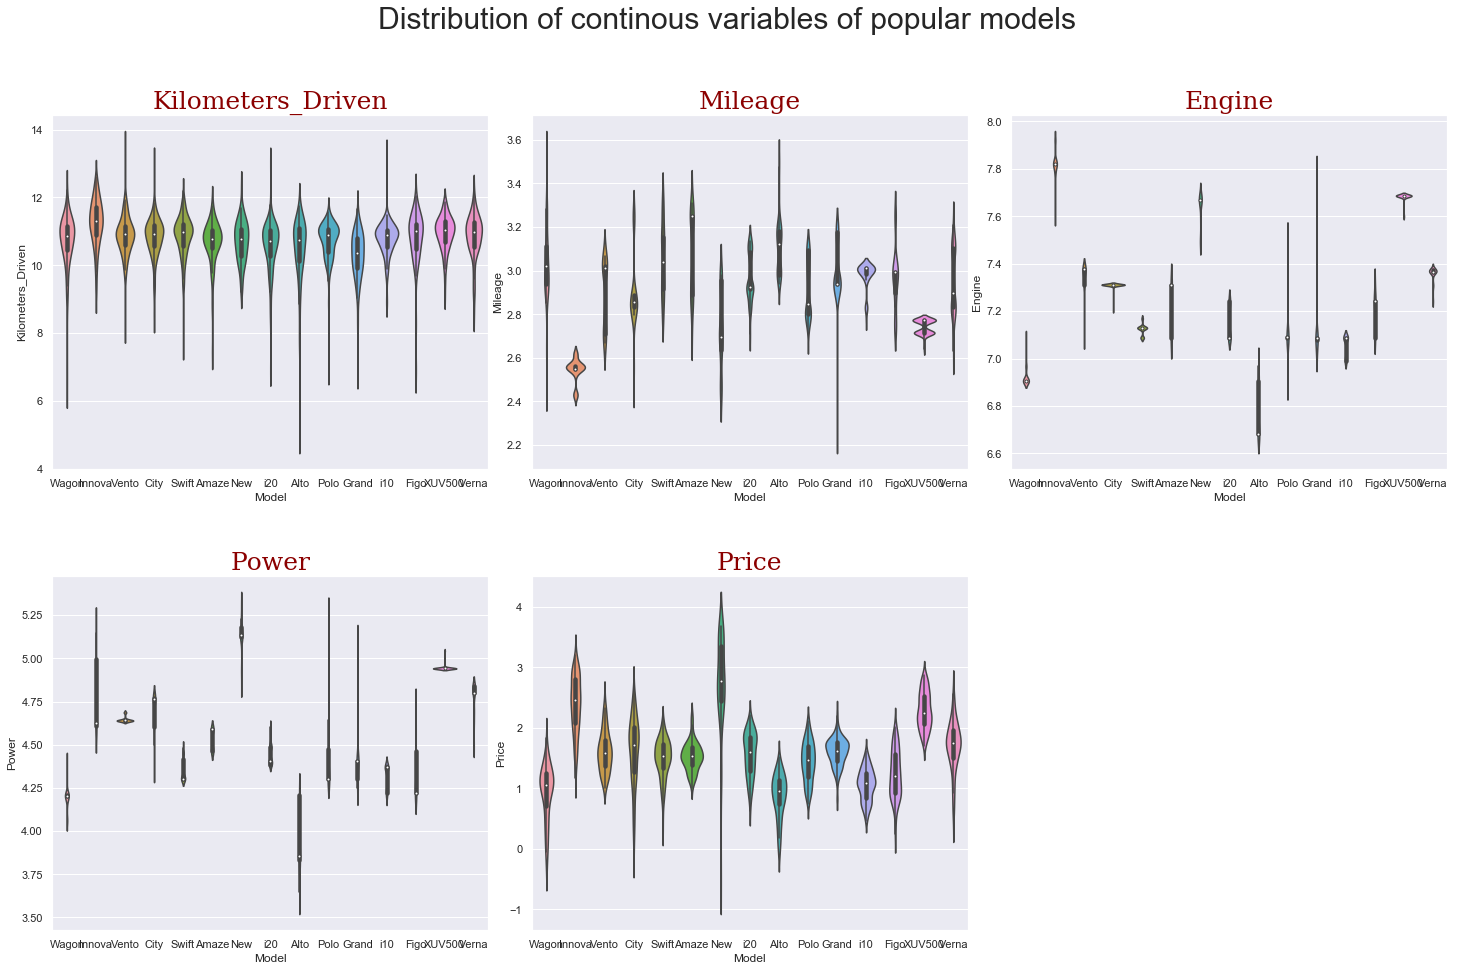

In [15]:
cols = ['Kilometers_Driven', 'Mileage', 'Engine', 'Power', 'Price']

# selecting top 10 Models
inds = training_set.Model.isin(training_set.Model.value_counts().head(15).index)

fig,axes = plt.subplots(2,3,figsize=(25,15))
fig.subplots_adjust(wspace=0.1, hspace=0.3)
fig.suptitle('Distribution of continous variables of popular models', fontsize=30)
axes = axes.ravel()

for i,col in enumerate(cols):
    s = training_set.loc[~pd.isna(training_set[col]),col].apply(np.log)
    s = s[~s.isin([-np.inf])]
    sns.violinplot(x=training_set.Model[inds], y=s, ax=axes[i])    
    axes[i].set_title(col,fontdict = font, fontsize=25)
fig.delaxes(axes[-1])

#### Location, Model and price 

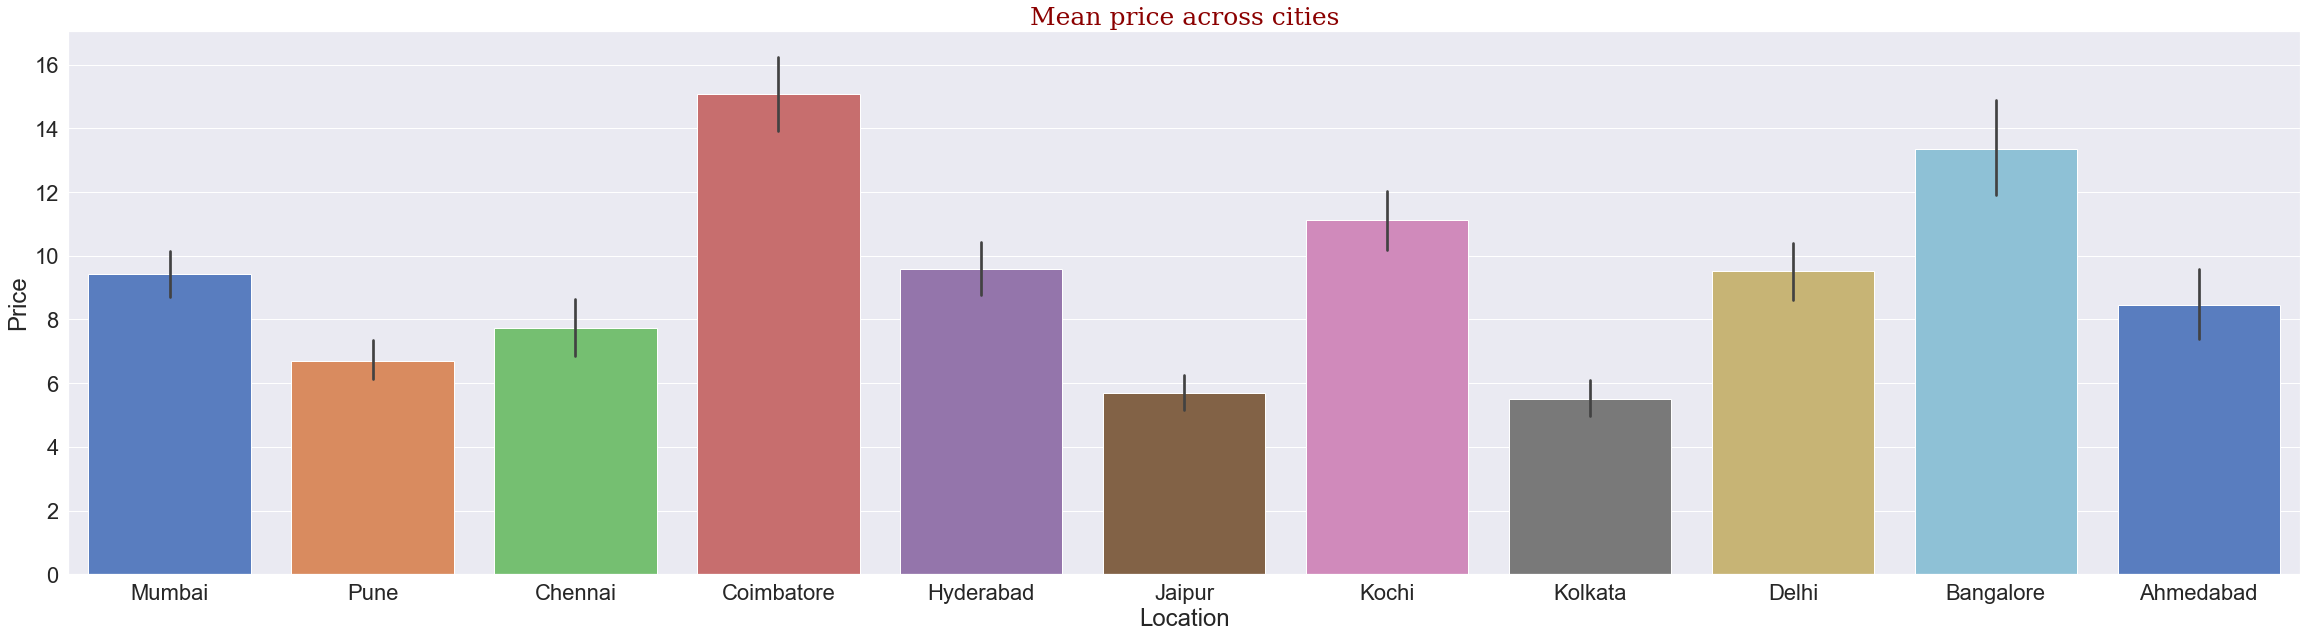

In [21]:
#sns.set(font_scale = 2)

plt.figure(figsize=(40,10))
sns.barplot(x="Location", y="Price", data=training_set,palette="muted")
plt.title("Mean price across cities",fontdict = font, fontsize=25);
#plt.xlabel('PC1',fontsize = 18);

In order to decide where price actually has influence on the price. To test this we pick top 15 models and compare their prices across different cities.

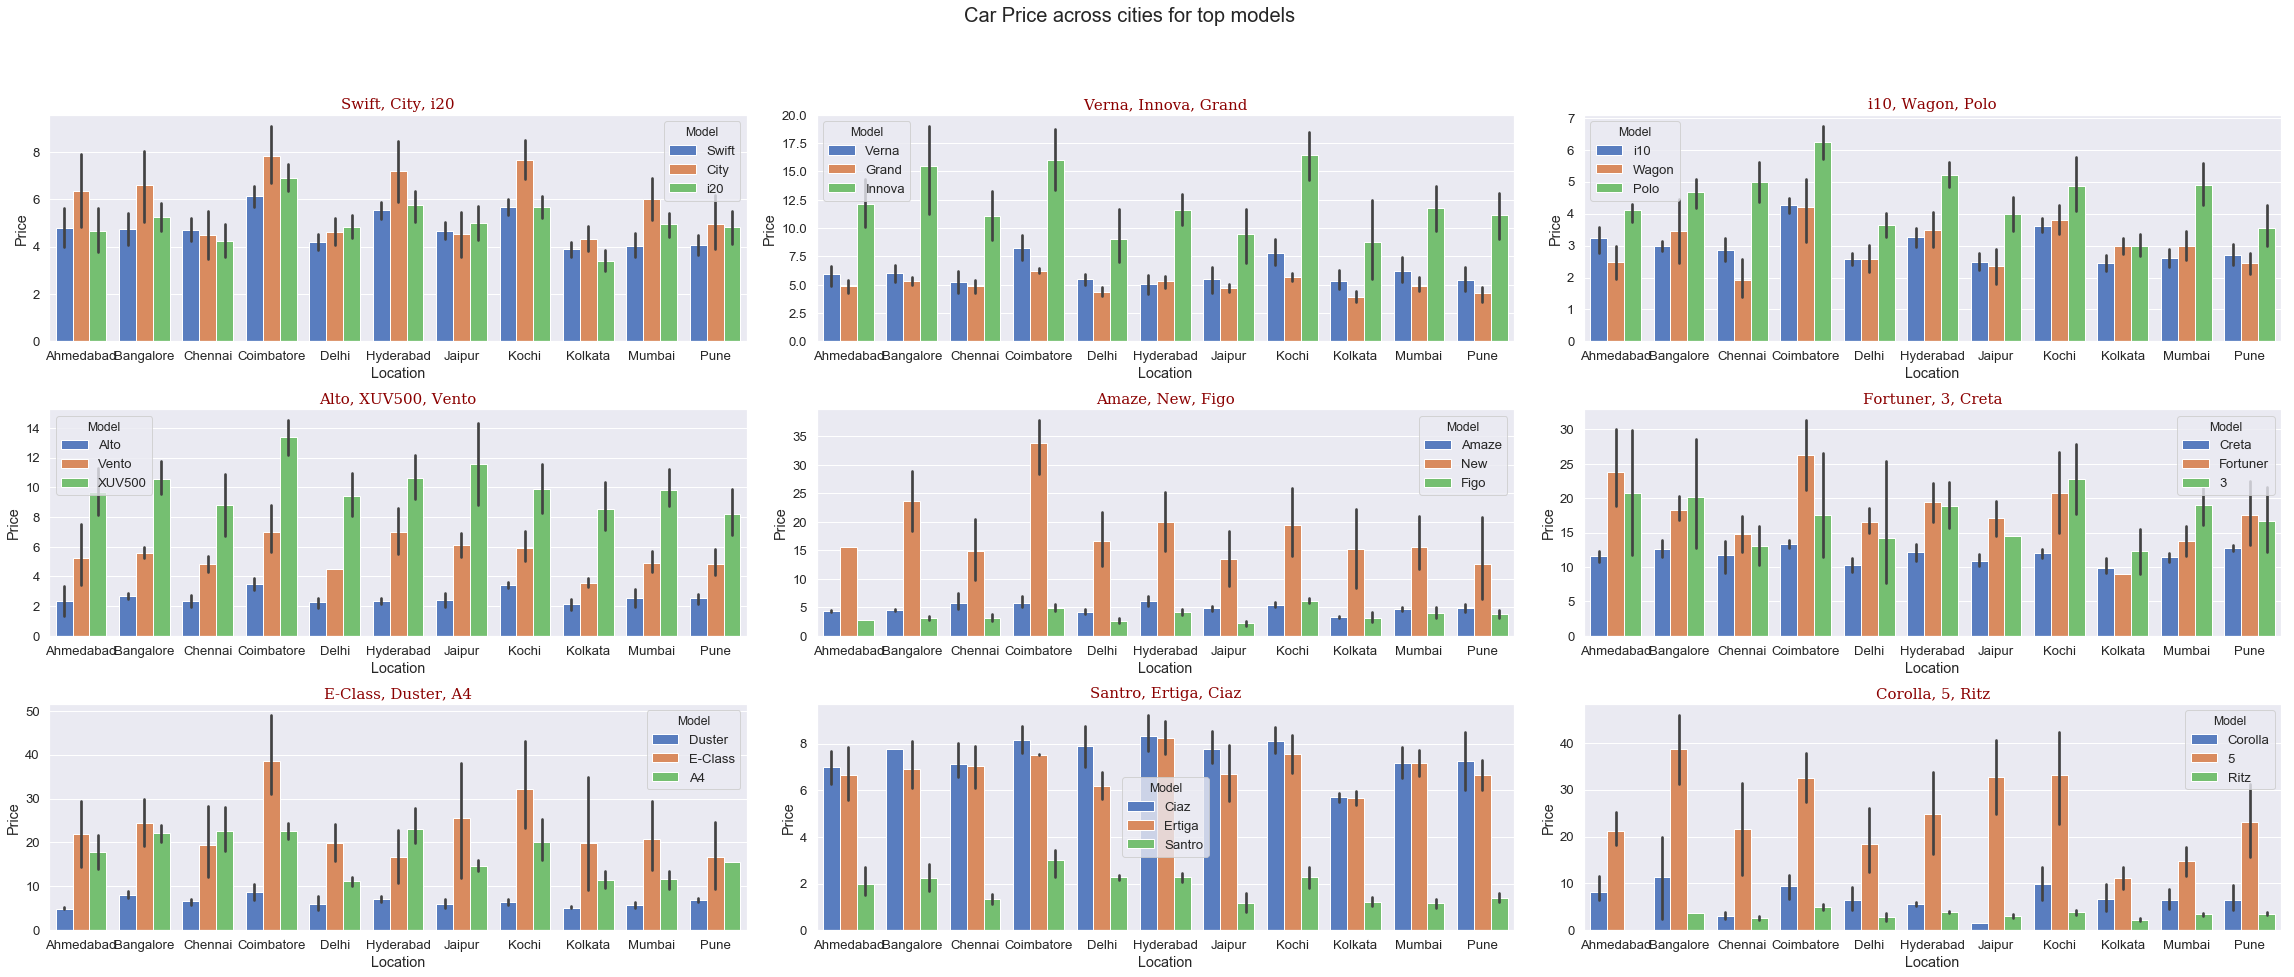

In [42]:
test_models=training_set.Model.value_counts().head(27).index
sns.set(font_scale = 1.2)

fig,axes = plt.subplots(3,3,figsize=(40,15))
fig.subplots_adjust(wspace=0.1, hspace=0.3)
fig.suptitle('Car Price across cities for top models', fontsize=20)
axes = axes.ravel()


for i, ind in enumerate(range(0,27,3)):
    df = training_set[training_set.Model.isin(test_models[ind:ind+3])].copy()
    df.sort_values("Location", axis = 0, ascending = True, inplace = True)
    sns.barplot(x="Location", y="Price", hue="Model", data=df,palette="muted", ax=axes[i])
    axes[i].set_title(", ".join(test_models[ind:ind+3]),fontdict = font, fontsize=15);


### Same as Location but for year

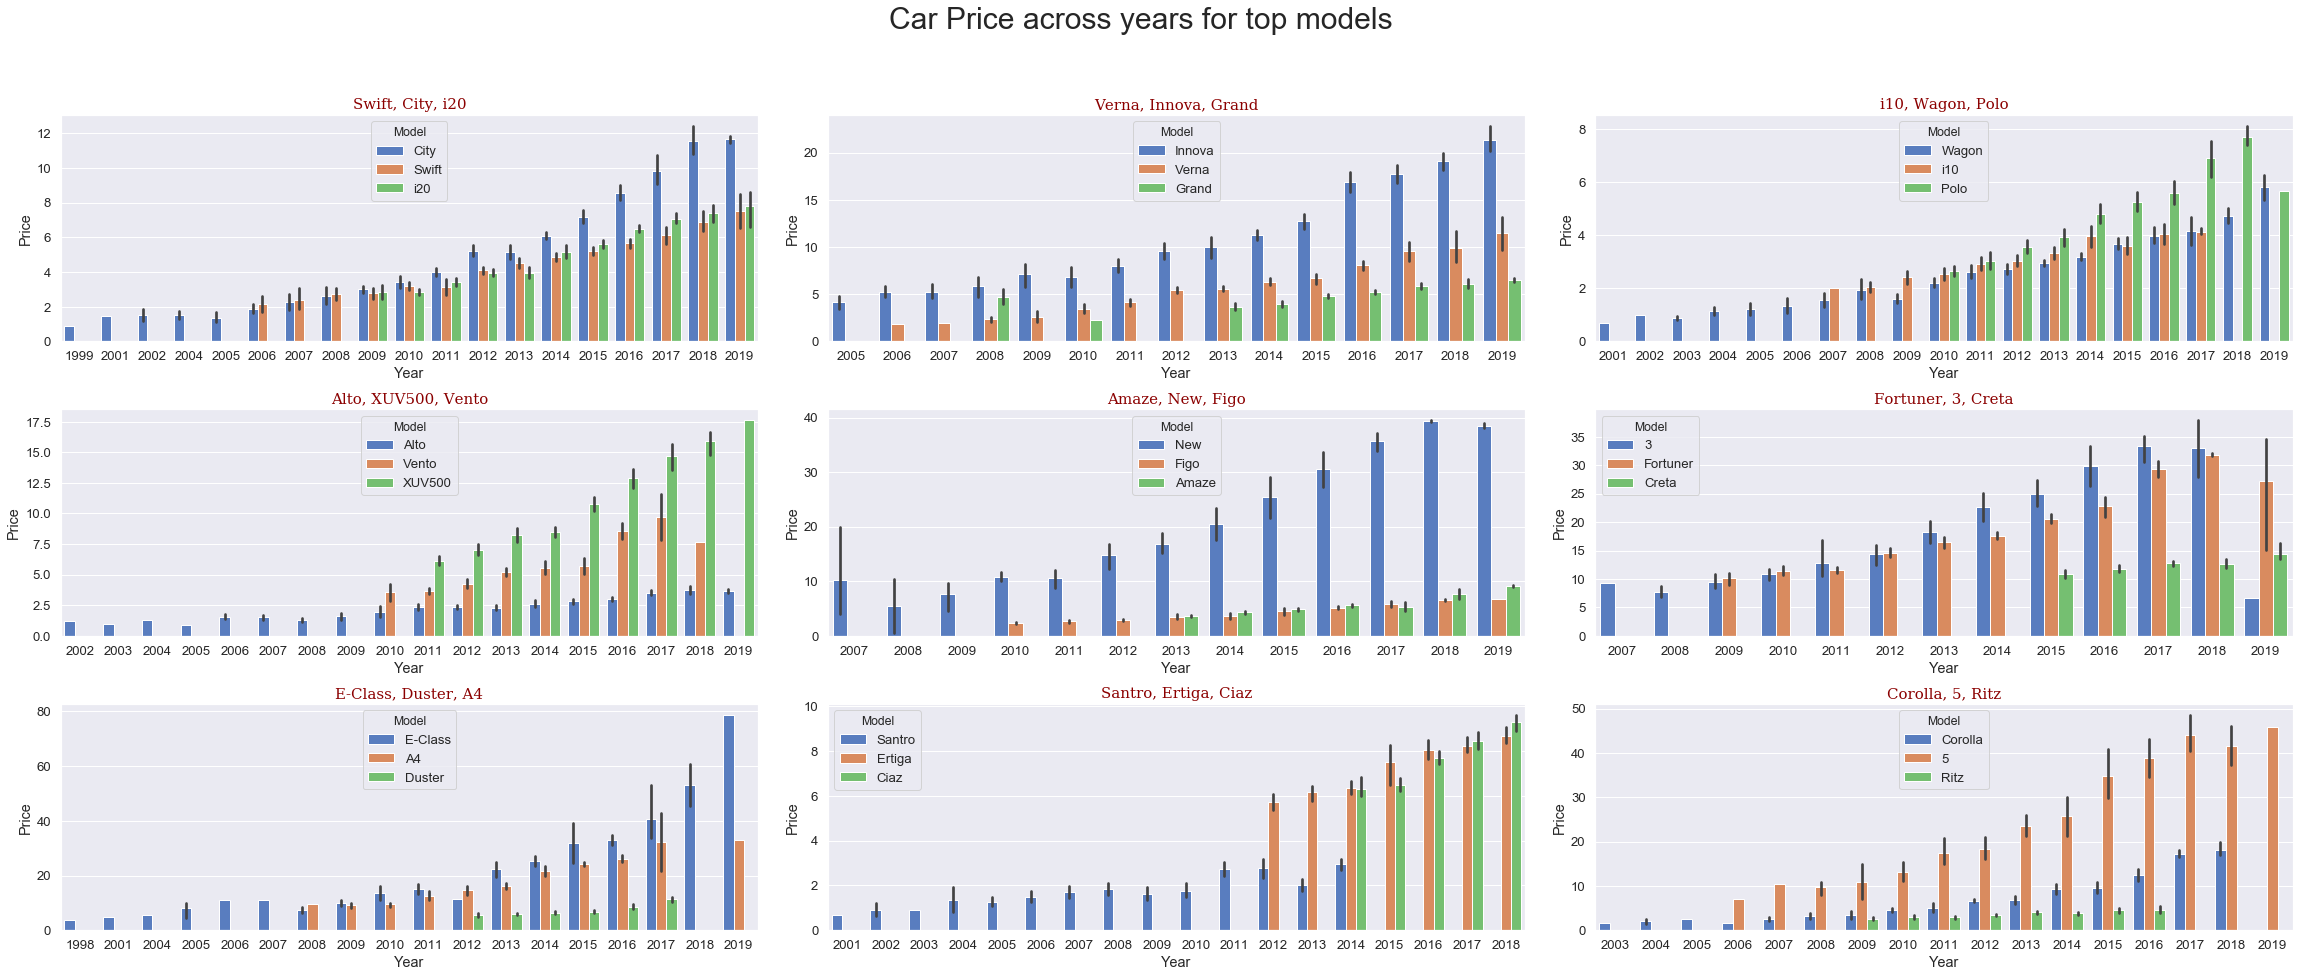

In [44]:
test_models=training_set.Model.value_counts().head(27).index
sns.set(font_scale = 1.2)


fig,axes = plt.subplots(3,3,figsize=(40,15))
fig.subplots_adjust(wspace=0.1, hspace=0.3)
fig.suptitle('Car Price across years for top models', fontsize=30)
axes = axes.ravel()


for i, ind in enumerate(range(0,27,3)):
    df = training_set[training_set.Model.isin(test_models[ind:ind+3])].copy()
    df.sort_values("Year", axis = 0, ascending = True, inplace = True)
    sns.barplot(x="Year", y="Price", hue="Model", data=df,palette="muted", ax=axes[i])
    axes[i].set_title(", ".join(test_models[ind:ind+3]),fontdict = font, fontsize=15)


Plot of means computed for individual models agrees with the overall mean plot. Mean One-hot encoding can be used. 

### Target variablity within categorical features 

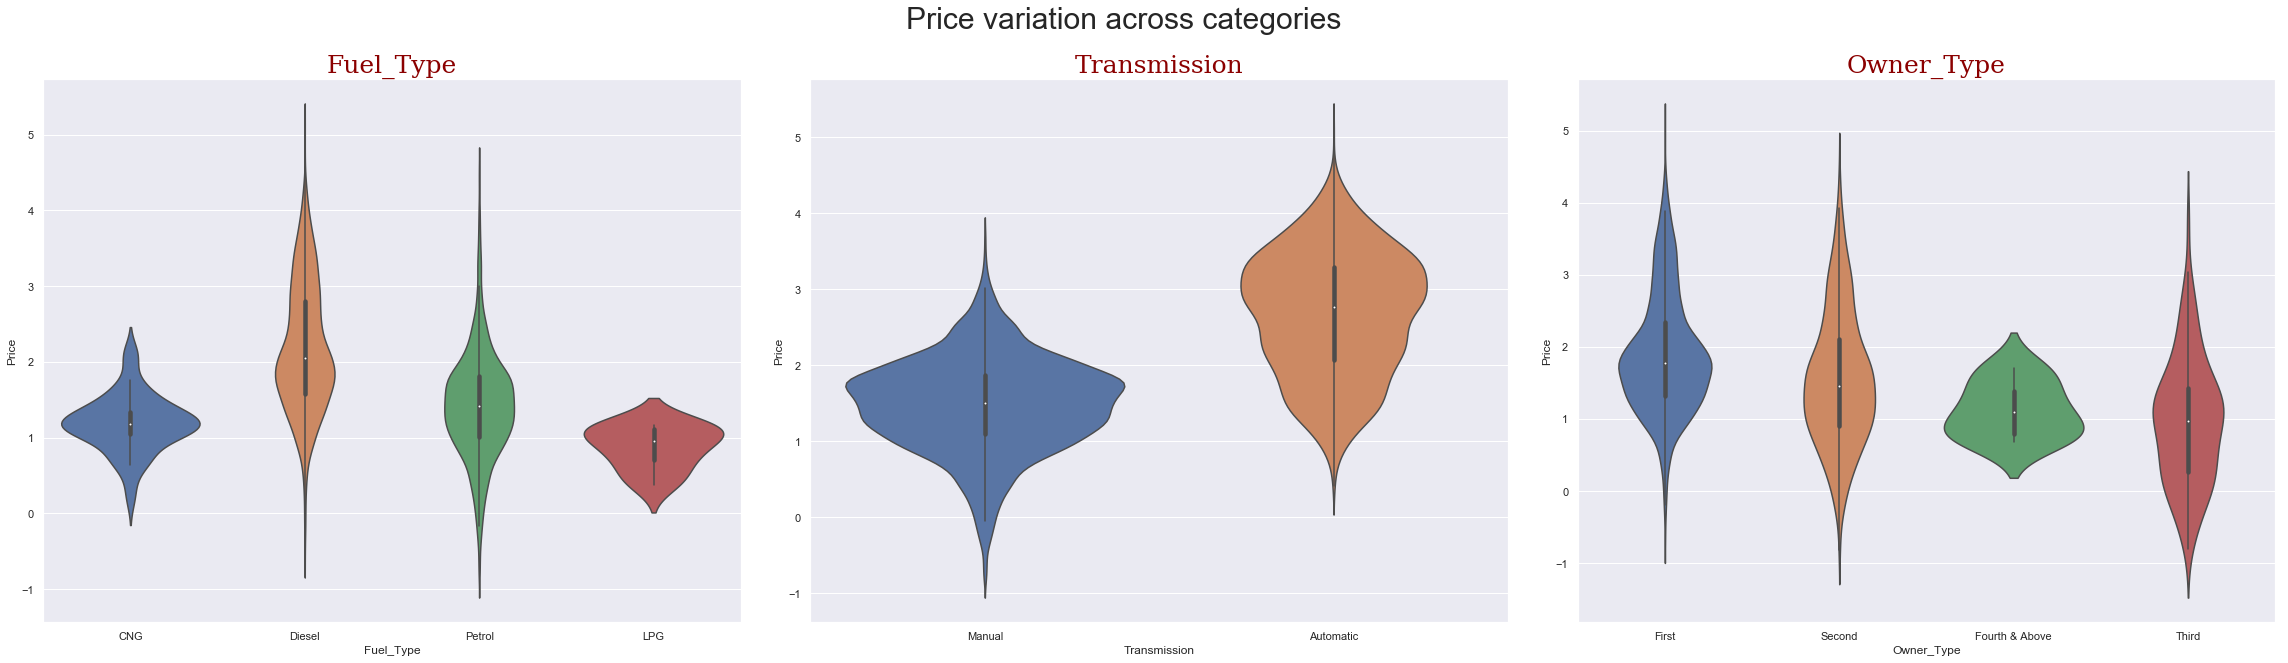

In [20]:
cols = ['Fuel_Type', 'Transmission','Owner_Type']


fig,axes = plt.subplots(1,3,figsize=(40,10))
fig.subplots_adjust(wspace=0.1, hspace=0.3)
fig.suptitle('Price variation across categories', fontsize=30)
axes = axes.ravel()

for i,col in enumerate(cols):
    s = training_set.loc[~pd.isna(training_set['Price']),'Price'].apply(np.log)
    s = s[~s.isin([-np.inf])]
    sns.violinplot(x=training_set[col], y=s, ax=axes[i])    
    axes[i].set_title(col,fontdict = font, fontsize=25)


## Seats

In [24]:
training_set.loc[training_set.Seats==2.]

Brand      Model    Location  Year  Kilometers_Driven Fuel_Type  \
134   Mercedes-Benz        SLC     Kolkata  2017              13372    Petrol   
555            Audi         TT       Delhi  2013              12100    Petrol   
691   Mercedes-Benz  SLK-Class  Coimbatore  2016              22732    Petrol   
796   Mercedes-Benz  SLK-Class   Bangalore  2015              10000    Petrol   
923         Porsche     Cayman   Hyderabad  2010              10000    Petrol   
1283           Audi         TT       Kochi  2014              14262    Petrol   
2086  Mercedes-Benz        SLC  Coimbatore  2019               2526    Petrol   
2296        Porsche     Cayman      Mumbai  2011               8000    Petrol   
4672  Mercedes-Benz  SLK-Class   Bangalore  2014               3000    Petrol   
4872            BMW         Z4       Kochi  2018               9952    Petrol   
5271            BMW         Z4       Delhi  2011              25000    Petrol   

     Transmission Owner_Type  Mileage  Engine   Power  Seats  Price  
134     Automatic      First    19.00  2996.0  362.07    2.0  54.00  
555     Automatic      First     9.90  1984.0  207.80    2.0  29.50  
691     Automatic      First    18.10  3498.0  306.00    2.0  55.54  
796     Automatic      First    18.10  3498.0  306.00    2.0  55.00  
923        Manual      First     9.00  3436.0   74.00    2.0  40.00  
1283    Automatic      First     9.90  1984.0  207.80    2.0  27.35  
2086    Automatic      First    19.00  2996.0  362.07    2.0  83.96  
2296    Automatic      First     9.00  3436.0   74.00    2.0  43.00  
4672    Automatic     Second    12.00  5461.0  421.00    2.0  90.00  
4872    Automatic      First    10.37  2979.0  306.00    2.0  58.54  
5271    Automatic      First    10.37  2979.0  306.00    2.0  30.00

5.0     5043
7.0      672
8.0      132
4.0       95
6.0       31
2.0       11
10.0       5
9.0        3
Name: Seats, dtype: int64


Text(0.5,1,'Seats')

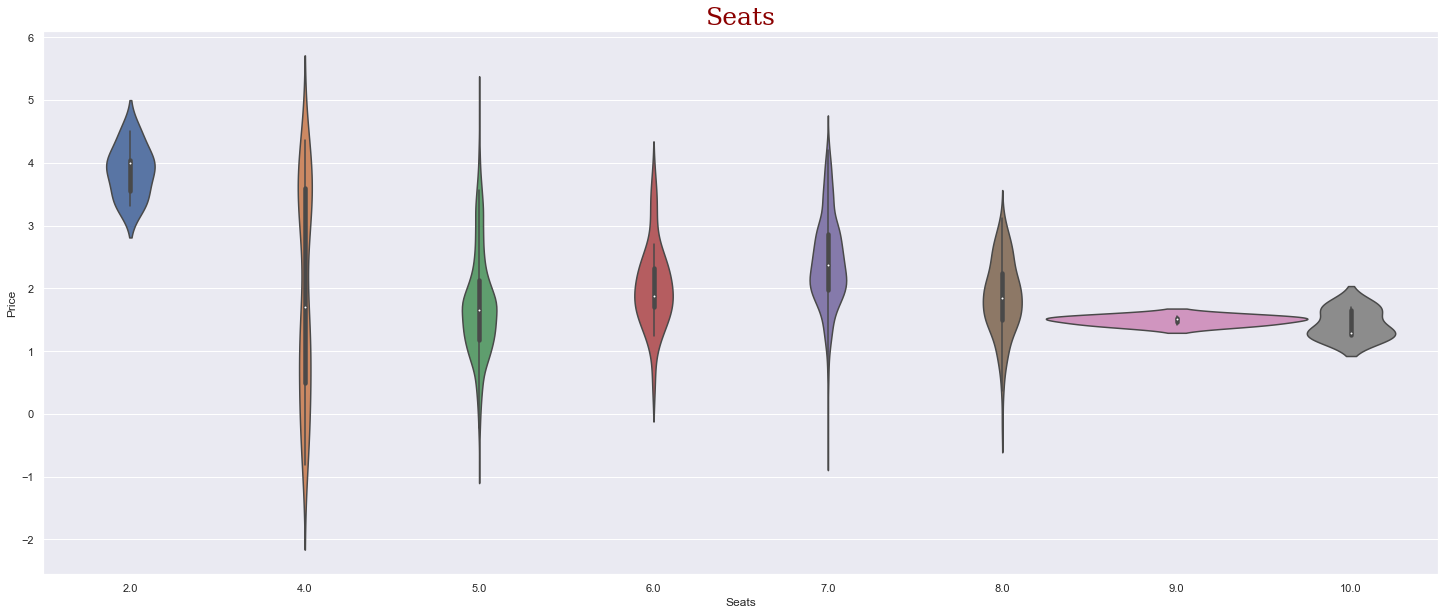

In [23]:
## #sns.set(font_scale = 2)

print(training_set.Seats.value_counts(normalize=False))

plt.figure(figsize=(25,10))

s = training_set.loc[~pd.isna(training_set['Price']),'Price'].apply(np.log)
s = s[~s.isin([-np.inf])]
sns.violinplot(x=training_set['Seats'], y=s,width=1.5)    
plt.title('Seats',fontdict = font, fontsize=25)

In [ ]:
#

In [20]:
inds = training_set.Owner_Type.value_counts(normalize=True)>0.05
inds.index[inds].tolist()

pd.get_dummies()

['First', 'Second']

In [15]:
enc = DF_OneHotEncoder(filter_threshold=0.05)
enc.fit_transform(training_set[['Owner_Type']])

> /home/skumar/DataScience/Projects_Section/Projects_Completed/Participants_Data_Used_Cars/modules/custom_transformers.py(563)transform()
-> one_hot = pd.get_dummies(X[col],prefix=col)
(Pdb) c


Owner_Type_First  Owner_Type_Second
0                    1                  0
1                    1                  0
2                    1                  0
3                    1                  0
4                    0                  1
...                ...                ...
5987                 1                  0
5988                 1                  0
5989                 0                  1
5990                 1                  0
5991                 1                  0

[5992 rows x 2 columns]

### Features association with  dependent variable

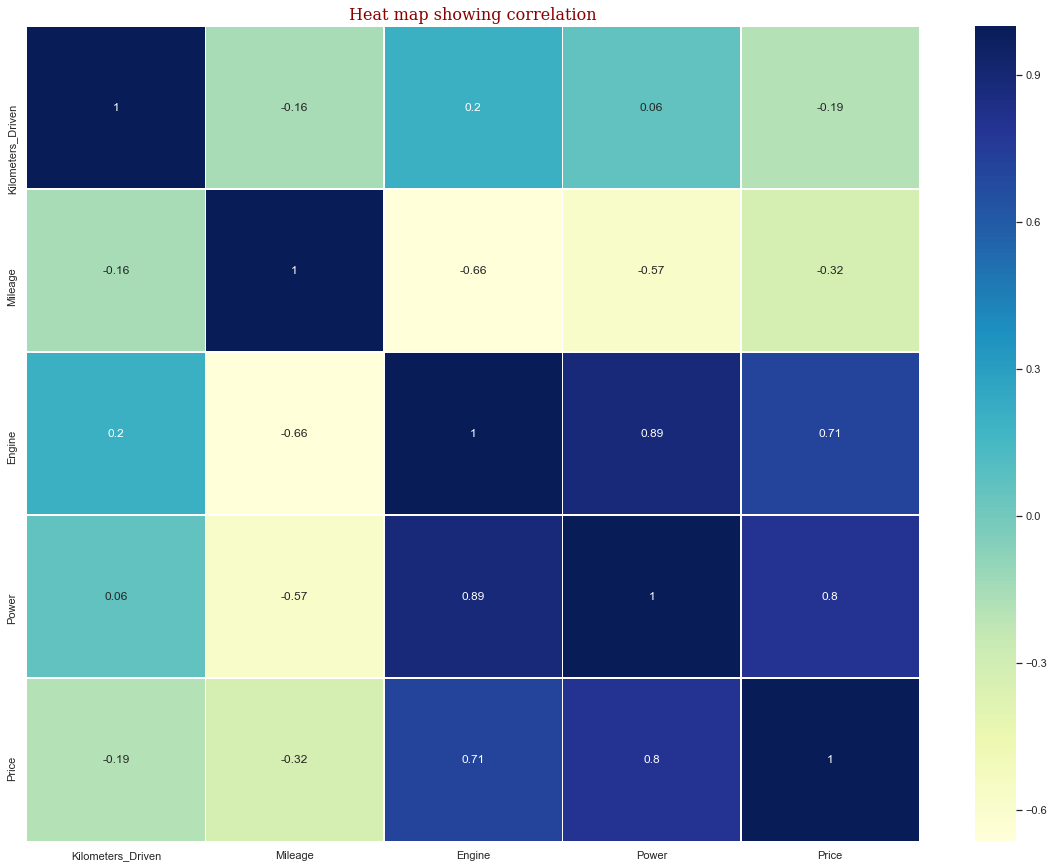

In [130]:
cols = ['Kilometers_Driven', 'Mileage', 'Engine', 'Power']

plt.figure(figsize=(20,15))
sns.heatmap(training_set[cols+['Price']].apply(np.log).corr(),linewidths=0.5,cmap="YlGnBu", annot=True);
plt.title("Heat map showing correlation",fontdict=font);

* Kilometers_Driven and Mileage has not much influence on the traget variable.
* Power and Engine are highly correlated (~0.9) and can be cosidered as colinear features.

In [21]:
training_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6019 entries, 0 to 6018
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               6019 non-null   object 
 1   Location           6019 non-null   object 
 2   Year               6019 non-null   int64  
 3   Kilometers_Driven  6019 non-null   int64  
 4   Fuel_Type          6019 non-null   object 
 5   Transmission       6019 non-null   object 
 6   Owner_Type         6019 non-null   object 
 7   Mileage            6017 non-null   float64
 8   Engine             5983 non-null   float64
 9   Power              5876 non-null   float64
 10  Seats              5977 non-null   float64
 11  Price              6019 non-null   float64
dtypes: float64(5), int64(2), object(5)
memory usage: 564.4+ KB


In [48]:
list(itertools.combinations(cols,2))

[('Kilometers_Driven', 'Mileage'),
 ('Kilometers_Driven', 'Engine'),
 ('Mileage', 'Engine')]

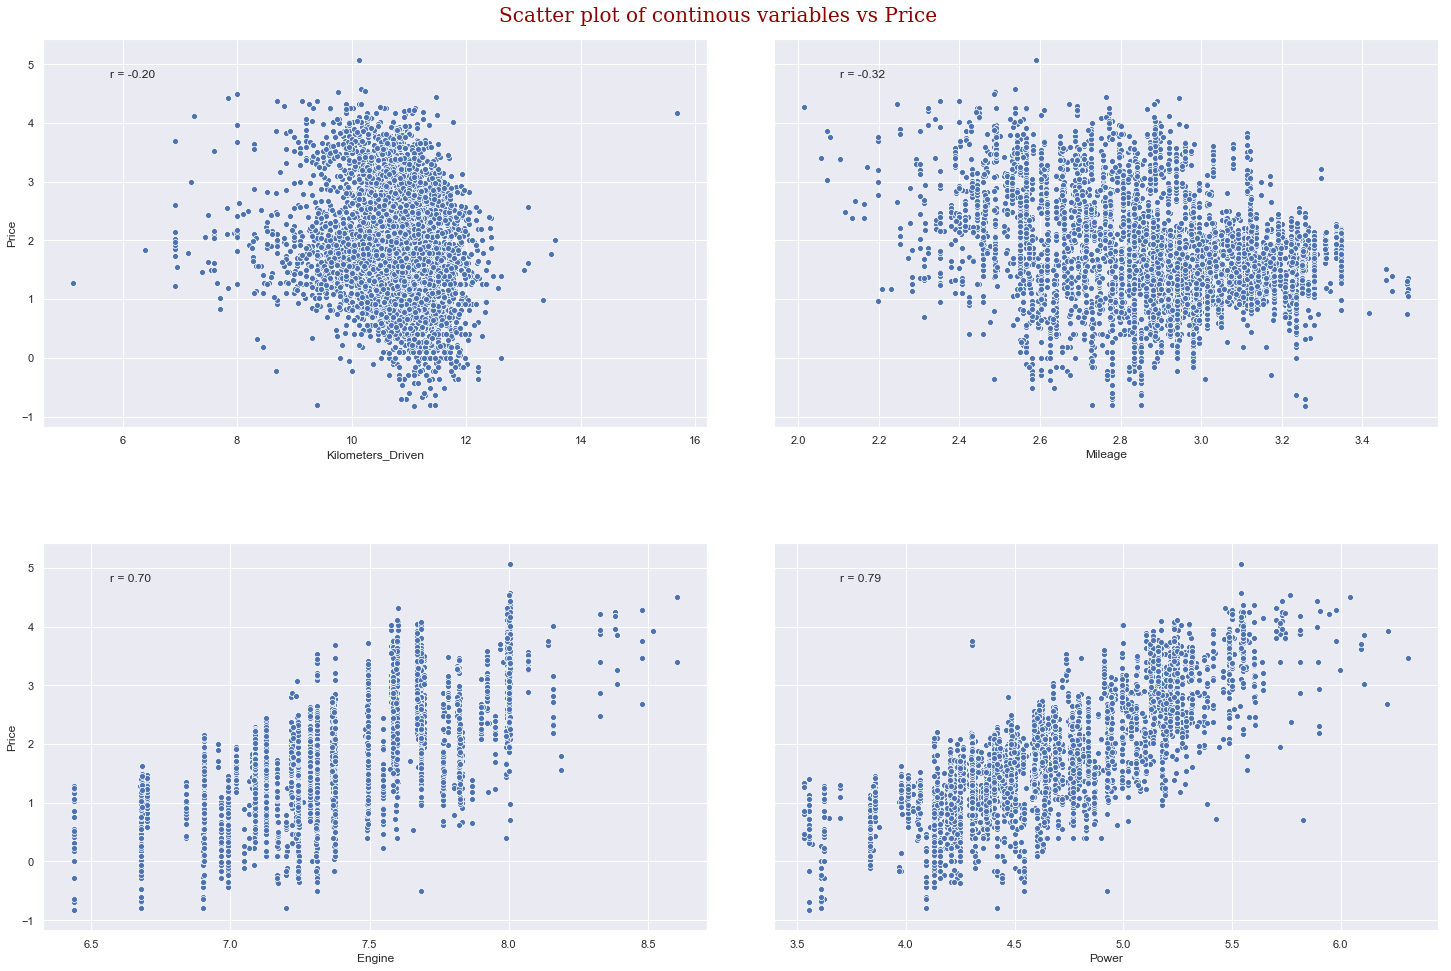

In [17]:
import itertools

cols = ['Kilometers_Driven', 'Mileage', 'Engine', 'Power']

fig,axes = plt.subplots(2,2,figsize=(25,15),sharey=True)
fig.subplots_adjust(wspace=0.1, hspace=0.3)
fig.suptitle('Scatter plot of continous variables vs Price',fontsize = 20, fontdict=font)
fig.subplots_adjust(top=0.95)

axes = axes.ravel()

for i,col in enumerate(cols):
    inds = ~pd.isna(training_set[col])
    #-----with log transformation
    x = training_set[col][inds].apply(np.log)
    y = training_set['Price'][inds].apply(np.log)
    sns.scatterplot(x, y ,ax=axes[i])
    
    #----normal
    #sns.scatterplot(training_set[col],training_set['Price'],ax=axes[i])
    
    
    # coreltaion annotation 
    r, _ = stats.pearsonr(x, y)
    axes[i].annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=axes[i].transAxes)

* Engine volume and Power has strong association with the price 

In [56]:
list(itertools.combinations(cols,2))

[('Kilometers_Driven', 'Mileage'),
 ('Kilometers_Driven', 'Engine'),
 ('Mileage', 'Engine')]

#### Interaction between variables

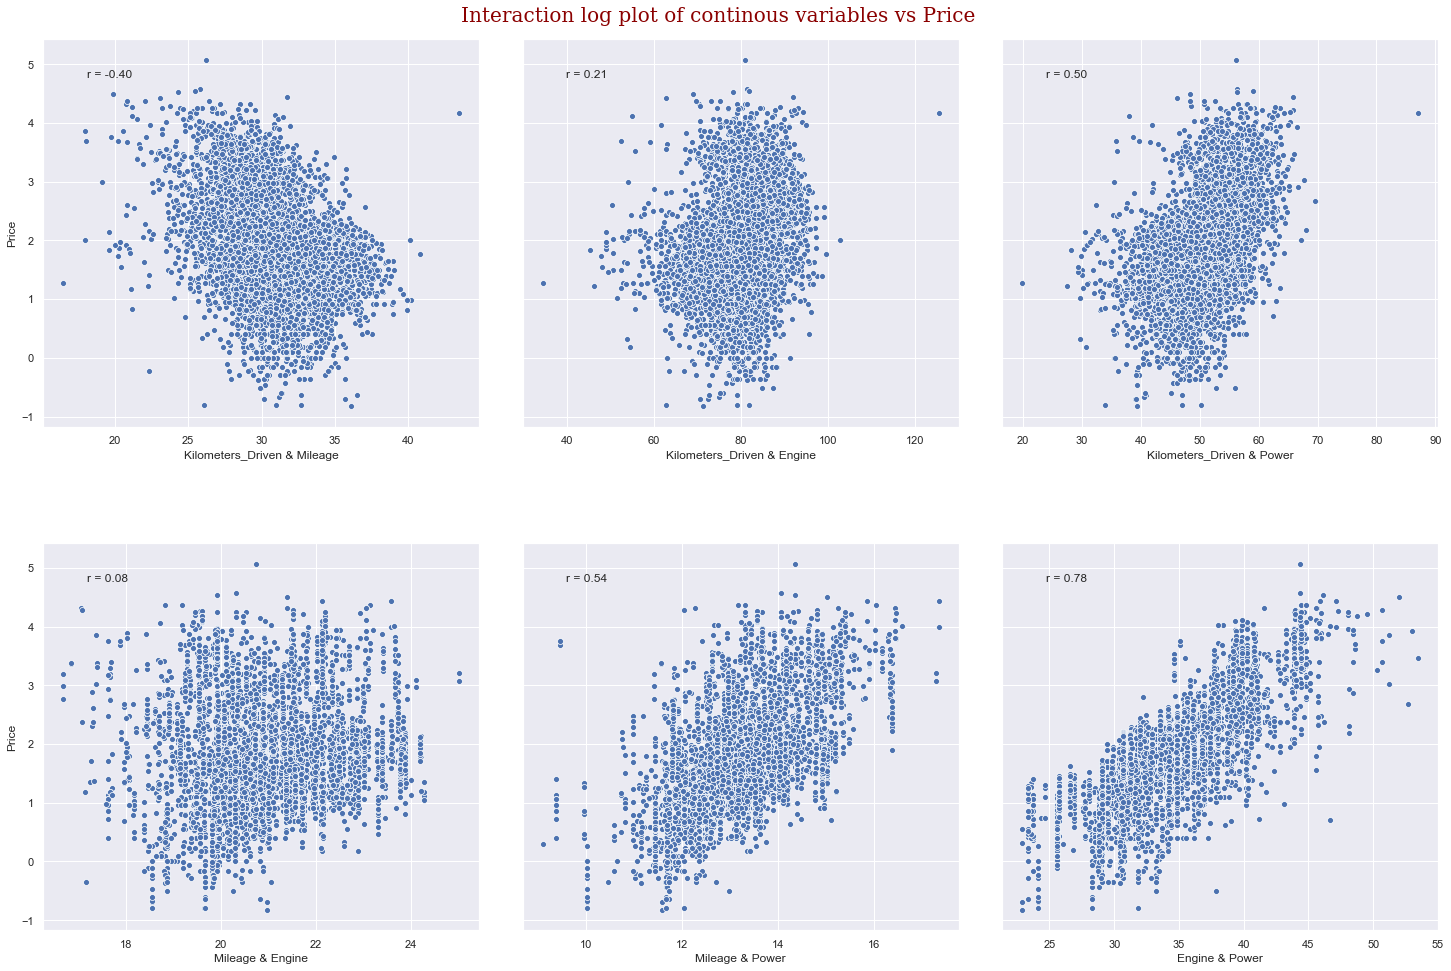

In [16]:
#               *******   Interaction between Milege and Kilometer Driven **********
cols = ['Kilometers_Driven', 'Mileage', 'Engine','Power']

fig,axes = plt.subplots(2,3,figsize=(25,15),sharey=True)
fig.subplots_adjust(wspace=0.1, hspace=0.3)
fig.suptitle('Interaction log plot of continous variables vs Price', fontsize= 20, fontdict=font)
fig.subplots_adjust(top=0.95)

axes = axes.ravel()

def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)

for i, tup in enumerate(itertools.combinations(cols,2)):
    col1 = tup[0]
    col2 = tup[1]
    inds = ~(pd.isna(training_set[col1]) | pd.isna(training_set[col2]))
    x= training_set[col1][inds].apply(np.log)*training_set[col2][inds].apply(np.log)
    y = training_set['Price'][inds].apply(np.log)
    sns.scatterplot(x,y,ax=axes[i]);
    axes[i].set_xlabel(f'{col1} & {col2}')
    
    # coreltaion annotation 
    r, _ = stats.pearsonr(x, y)
    axes[i].annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=axes[i].transAxes)


* Engine and Power has strong association with price in some way the reflect association with luxiorus brands so people ready to pay the high price.
* Kilometer Driven and Mileage doesn't seems to be the important factor when making deal.
* But when Kilometer Driven and Mileage combined together, the resulting feature gained some predictive power (there is clear negative trend)
* we notice some outliers in 2 d plot which otherwise wouldn't be possible to catch in univariate analysis.

#### VIF test for Multi-colinearity

In [26]:
training_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5992 entries, 0 to 5991
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Brand              5992 non-null   object 
 1   Model              5992 non-null   object 
 2   Location           5992 non-null   object 
 3   Year               5992 non-null   int64  
 4   Kilometers_Driven  5992 non-null   int64  
 5   Fuel_Type          5992 non-null   object 
 6   Transmission       5992 non-null   object 
 7   Owner_Type         5992 non-null   object 
 8   Mileage            5992 non-null   float64
 9   Engine             5992 non-null   float64
 10  Power              5992 non-null   float64
 11  Seats              5992 non-null   float64
 12  Price              5992 non-null   float64
dtypes: float64(5), int64(2), object(6)
memory usage: 608.7+ KB


In [29]:
training_set = pd.read_csv('DataSets/TrainSet_Cleaned.csv')

cols = ['Power','Engine','Kilometers_Driven','Mileage','Seats']


vif_scores = dict()

tmp = training_set[cols].copy()
tmp = tmp.apply(np.log)

for i in cols:
    y = tmp[i]
    x = tmp.drop(i,axis=1)
    x = sm.add_constant(x)
    model = sm.OLS(y, x.astype(float))
    results = model.fit()
    rsq = results.rsquared
    vif = round(1 / (1 - rsq), 2)
    print(
        "R Square value of {} column is {} keeping all other columns as features".format(
            i, (round(rsq, 2))
        )
    )
    print(
        "Variance Inflation Factor of {} column is {} \n".format(
            i, vif)
        )
    vif_scores[i] = vif

R Square value of Power column is 0.83 keeping all other columns as features
Variance Inflation Factor of Power column is 5.82 

R Square value of Engine column is 0.87 keeping all other columns as features
Variance Inflation Factor of Engine column is 7.44 

R Square value of Kilometers_Driven column is 0.09 keeping all other columns as features
Variance Inflation Factor of Kilometers_Driven column is 1.1 

R Square value of Mileage column is 0.46 keeping all other columns as features
Variance Inflation Factor of Mileage column is 1.85 

R Square value of Seats column is 0.32 keeping all other columns as features
Variance Inflation Factor of Seats column is 1.47 



#### Anova for feature dependenace 

In [30]:
cols = training_set.select_dtypes('object').columns.tolist()

# t-test and anova assumes data to normally distributed

tmp = training_set[cols].copy()

y = training_set.Price.apply(np.log)

for col in cols:
    cat_y = []
    for cat in tmp[col].unique():
        cat_y.append(y[tmp[col]==cat])
    print(f'{col}:\n{f_oneway(*cat_y)}')
    

Brand:
F_onewayResult(statistic=294.9573908330804, pvalue=0.0)
Model:
F_onewayResult(statistic=122.4073799480774, pvalue=0.0)
Location:
F_onewayResult(statistic=74.05390489637388, pvalue=1.24184135441653e-143)
Fuel_Type:
F_onewayResult(statistic=481.29653853627354, pvalue=3.513024865550255e-280)
Transmission:
F_onewayResult(statistic=3660.5079482274805, pvalue=0.0)
Owner_Type:
F_onewayResult(statistic=84.16775431316191, pvalue=2.4548585135147553e-53)


## Feature Enginnering

Clean the columns by removing white spaces and split Name feature into Brand and Model. 

In [35]:
training_set.head()

Name    Location  Year  Kilometers_Driven  \
0            Maruti Wagon R LXI CNG      Mumbai  2010              72000   
1  Hyundai Creta 1.6 CRDi SX Option        Pune  2015              41000   
2                      Honda Jazz V     Chennai  2011              46000   
3                 Maruti Ertiga VDI     Chennai  2012              87000   
4   Audi A4 New 2.0 TDI Multitronic  Coimbatore  2013              40670   

  Fuel_Type Transmission Owner_Type  Mileage  Engine   Power  Seats  Price  
0       CNG       Manual      First    26.60   998.0   58.16    5.0   1.75  
1    Diesel       Manual      First    19.67  1582.0  126.20    5.0  12.50  
2    Petrol       Manual      First    18.20  1199.0   88.70    5.0   4.50  
3    Diesel       Manual      First    20.77  1248.0   88.76    7.0   6.00  
4    Diesel    Automatic     Second    15.20  1968.0  140.80    5.0  17.74

### Creating Brand and Model feature

In [36]:
# Data Cleaning and Feature  

# Split Car name feature into Brand and Model features for both sets 
training_set['Brand'] = [i.split(' ')[0].strip() for i in training_set.Name]
training_set['Model'] = [i.split(' ')[1].strip() for i in training_set.Name]
training_set.drop(labels=['Name'],axis=1,inplace=True)

test_set['Brand'] = [i.split(' ')[0].strip() for i in test_set.Name]
test_set['Model'] = [i.split(' ')[1].strip() for i in test_set.Name]
test_set.drop(labels=['Name'],axis=1,inplace=True)

# REordering Cols

order_cols = ['Brand', 'Model', 'Location', 'Year', 'Kilometers_Driven', 'Fuel_Type', 'Transmission',
  'Owner_Type', 'Mileage', 'Engine', 'Power', 'Seats', 'Price']
training_set = training_set[order_cols]

# if any model has single count will drop 
drop_models = training_set.Model.value_counts()[training_set.Model.value_counts()==1].index
training_set = training_set[~training_set.Model.isin(drop_models)]

### Handling Missing values

There are some missing values in the ['Mileage', 'Engine', 'Power', 'Seats'] columns. First three continous varaibles are imputed with mean and Mode for last variable of corresponding models

#### Filling values

In [37]:
training_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5992 entries, 0 to 6018
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Brand              5992 non-null   object 
 1   Model              5992 non-null   object 
 2   Location           5992 non-null   object 
 3   Year               5992 non-null   int64  
 4   Kilometers_Driven  5992 non-null   int64  
 5   Fuel_Type          5992 non-null   object 
 6   Transmission       5992 non-null   object 
 7   Owner_Type         5992 non-null   object 
 8   Mileage            5992 non-null   float64
 9   Engine             5956 non-null   float64
 10  Power              5853 non-null   float64
 11  Seats              5950 non-null   float64
 12  Price              5992 non-null   float64
dtypes: float64(5), int64(2), object(6)
memory usage: 815.4+ KB


In [40]:
training_set.Power.head(),training_set.Power.loc[[4,1]]

(0     58.16
 1    126.20
 2     88.70
 3     88.76
 4    140.80
 Name: Power, dtype: float64,
 4    140.8
 1    126.2
 Name: Power, dtype: float64)

RuntimeError: Selected KDE bandwidth is 0. Cannot estiamte density.

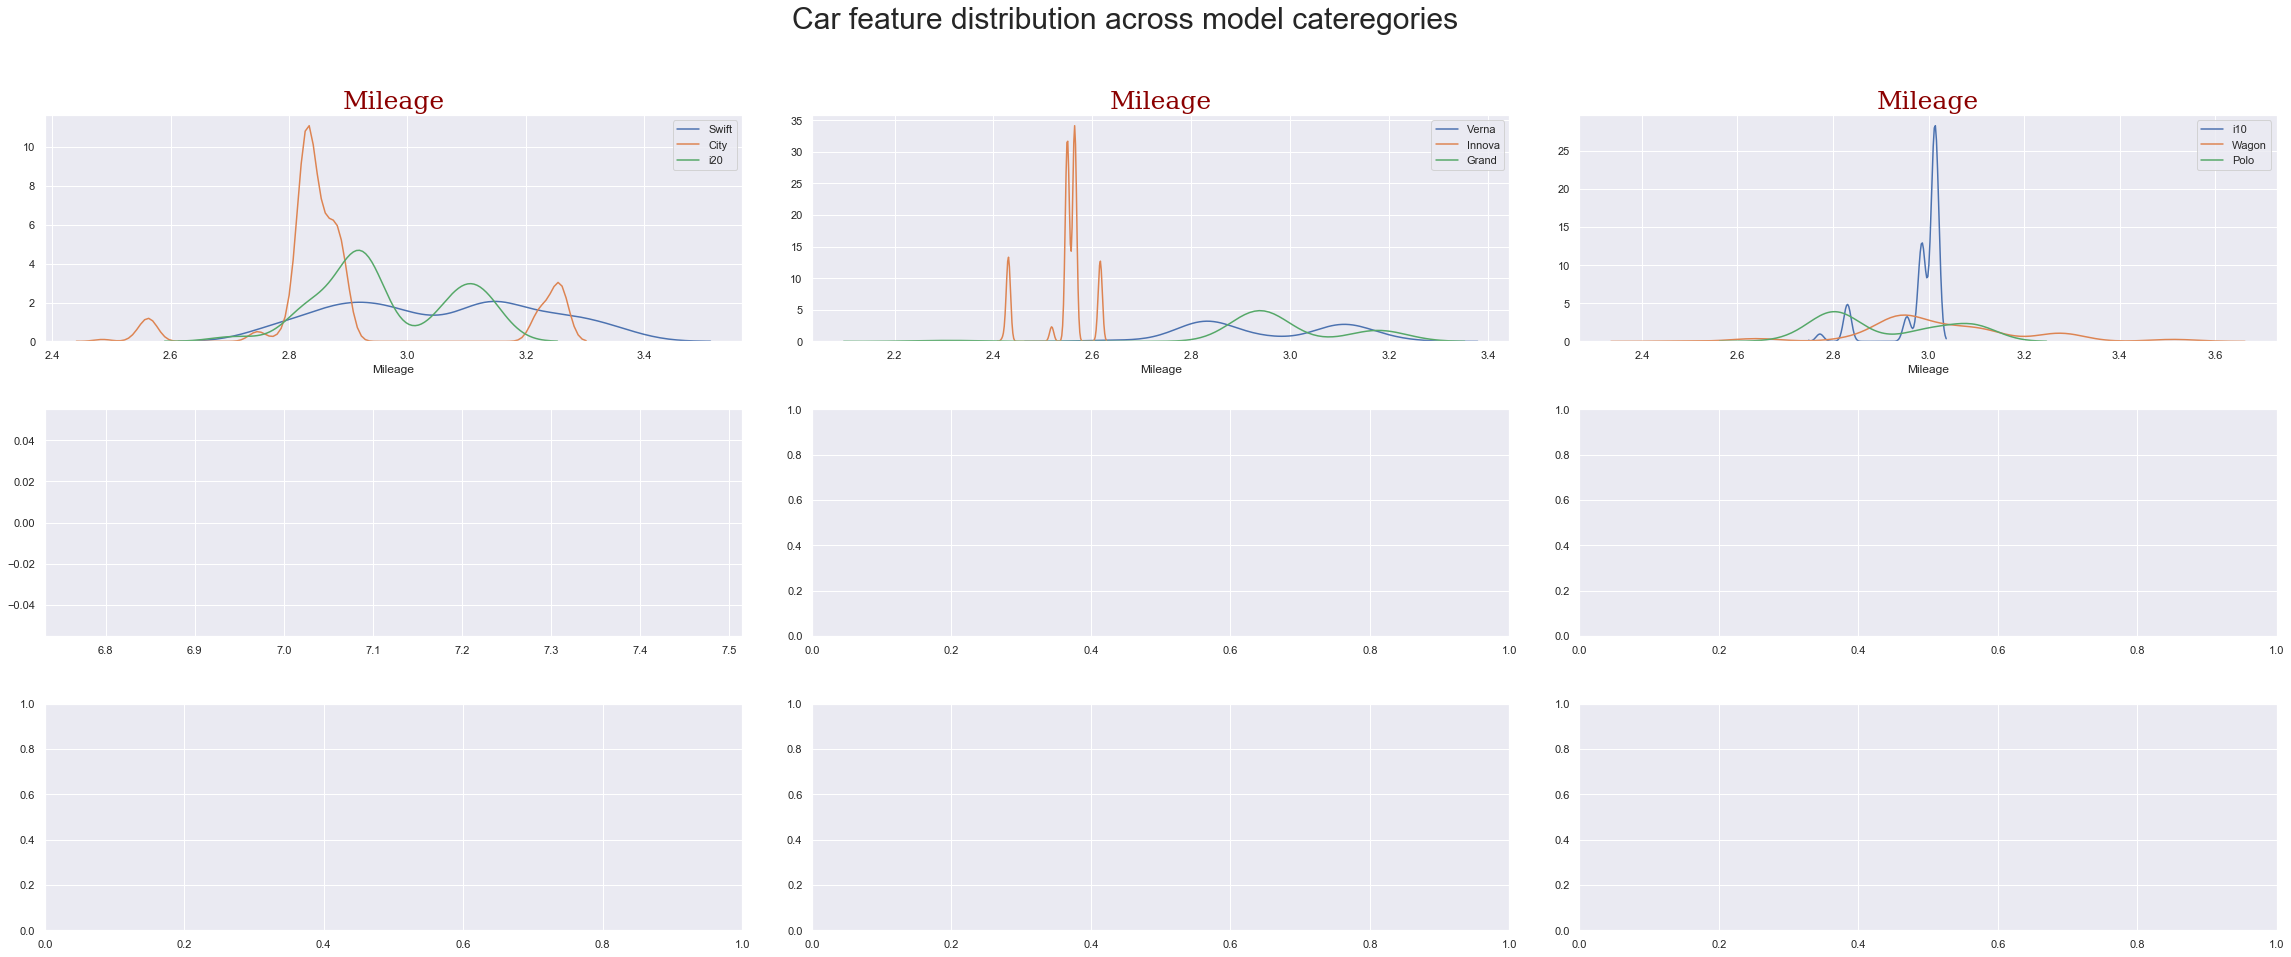

In [36]:
missing_cols = ['Mileage', 'Engine', 'Power']

# plot distributions for various models
test_models=training_set.Model.value_counts().head(27).index


fig,axes = plt.subplots(3,3,figsize=(40,15))
fig.subplots_adjust(wspace=0.1, hspace=0.3)
fig.suptitle('Car feature distribution across model cateregories', fontsize=30)
axes = axes.ravel()

i=0
for col in missing_cols:
    for ind in range(0,9,3):
        df = training_set[training_set.Model.isin(test_models[ind:ind+3])].copy()
        for j in test_models[ind:ind+3]:
            sns.distplot((df.loc[df.Model == j,col][~pd.isna(df[col])]).apply(np.log), hist= False,ax=axes[i], label = j)
        axes[i].set_title(col,fontdict = font, fontsize=25)    #axes[i].set_title(col,fontsize=25)
        i+=1

Parameters range vary across model and even within model there has significance varience with sharp peaks indicating most common value. Therefore we need to use mode for filling na's computed from subset filtered by each model in the missing rows.  

#### Filling with mode

In [64]:
training_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5992 entries, 0 to 6018
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Brand              5992 non-null   object 
 1   Model              5992 non-null   object 
 2   Location           5992 non-null   object 
 3   Year               5992 non-null   int64  
 4   Kilometers_Driven  5992 non-null   int64  
 5   Fuel_Type          5992 non-null   object 
 6   Transmission       5992 non-null   object 
 7   Owner_Type         5992 non-null   object 
 8   Mileage            5992 non-null   float64
 9   Engine             5992 non-null   float64
 10  Power              5992 non-null   float64
 11  Seats              5992 non-null   float64
 12  Price              5992 non-null   float64
dtypes: float64(5), int64(2), object(6)
memory usage: 655.4+ KB


In [ ]:
missing_cols = ['Mileage', 'Engine', 'Power', 'Seats']
training_set.replace({0:np.nan},inplace=True)
for col in missing_cols:
    missing_inds = training_set[col].isna()
    missing_mods = set(training_set.Model[missing_inds])
    for i,mod in enumerate(missing_mods):
        s = training_set.loc[training_set.Model==mod, col]
        if len(s.mode())>0:
            training_set.loc[((training_set.Model==mod) & (missing_inds)), col] = training_set.loc[((training_set.Model==mod) & (missing_inds)), col].fillna(s.mode().iloc[0])
    training_set.loc[(training_set[col].isna()), col] = training_set.loc[(training_set[col].isna()), col].fillna(training_set[col].mode().iloc[0])

In [65]:
training_set.to_csv('DataSets/TrainSet_Cleaned.csv',index=False,header=True)

### Read Clean Data without missing 

In [3]:
training_set = pd.read_csv('DataSets/TrainSet_Cleaned.csv')

In [4]:
training_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5992 entries, 0 to 5991
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Brand              5992 non-null   object 
 1   Model              5992 non-null   object 
 2   Location           5992 non-null   object 
 3   Year               5992 non-null   int64  
 4   Kilometers_Driven  5992 non-null   int64  
 5   Fuel_Type          5992 non-null   object 
 6   Transmission       5992 non-null   object 
 7   Owner_Type         5992 non-null   object 
 8   Mileage            5992 non-null   float64
 9   Engine             5992 non-null   float64
 10  Power              5992 non-null   float64
 11  Seats              5992 non-null   float64
 12  Price              5992 non-null   float64
dtypes: float64(5), int64(2), object(6)
memory usage: 608.7+ KB


#### Outlier Detection

In [14]:
training_set = ori.copy();training_set.describe()

NameError: name 'ori' is not defined

##### Outlier Removing IQR Threshold

In [17]:
%matplotlib notebook
%matplotlib widget

5849


<IPython.core.display.Javascript object>


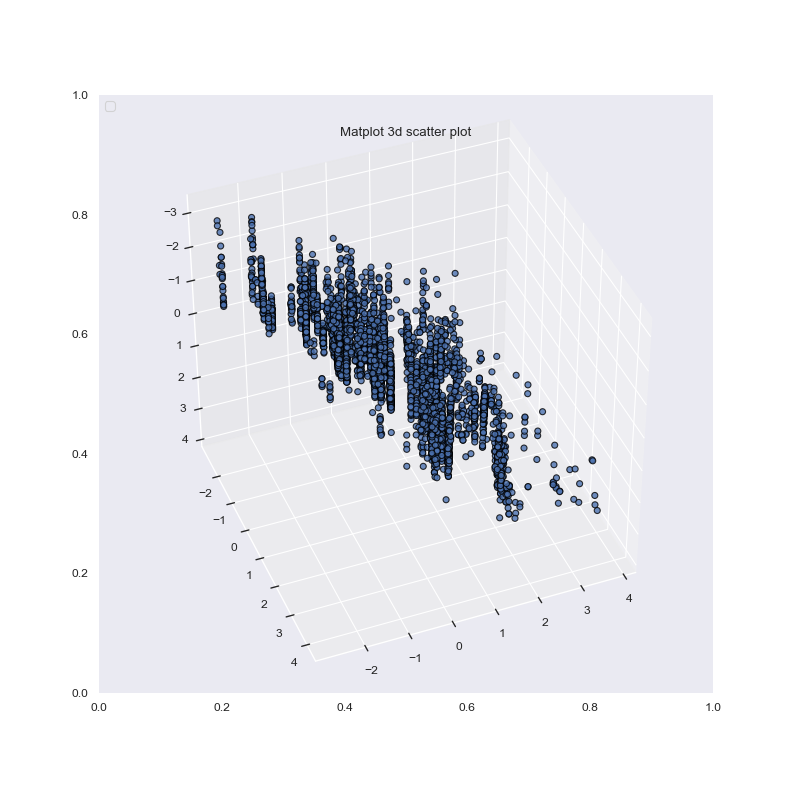

No handles with labels found to put in legend.


In [7]:
X = training_set[['Engine', 'Power','Price']].copy()
X = X.apply(np.log)

scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X.round(3)), columns=X.columns)

Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1

inds = ~((X < (Q1 - 1.5 * IQR)) |(X > (Q3 + 1.5 * IQR))).any(axis=1)
inds = X.index[inds]
print(len(inds))


# 3d plot 

from mpl_toolkits.mplot3d import axes3d
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1, facecolor="1.0")
ax = fig.gca(projection='3d')

ax.scatter(X['Engine'], X['Power'],X['Price'], alpha=0.8, edgecolors='none', s=30)
plt.title('Matplot 3d scatter plot')
plt.legend(loc=2)
plt.show()

<IPython.core.display.Javascript object>


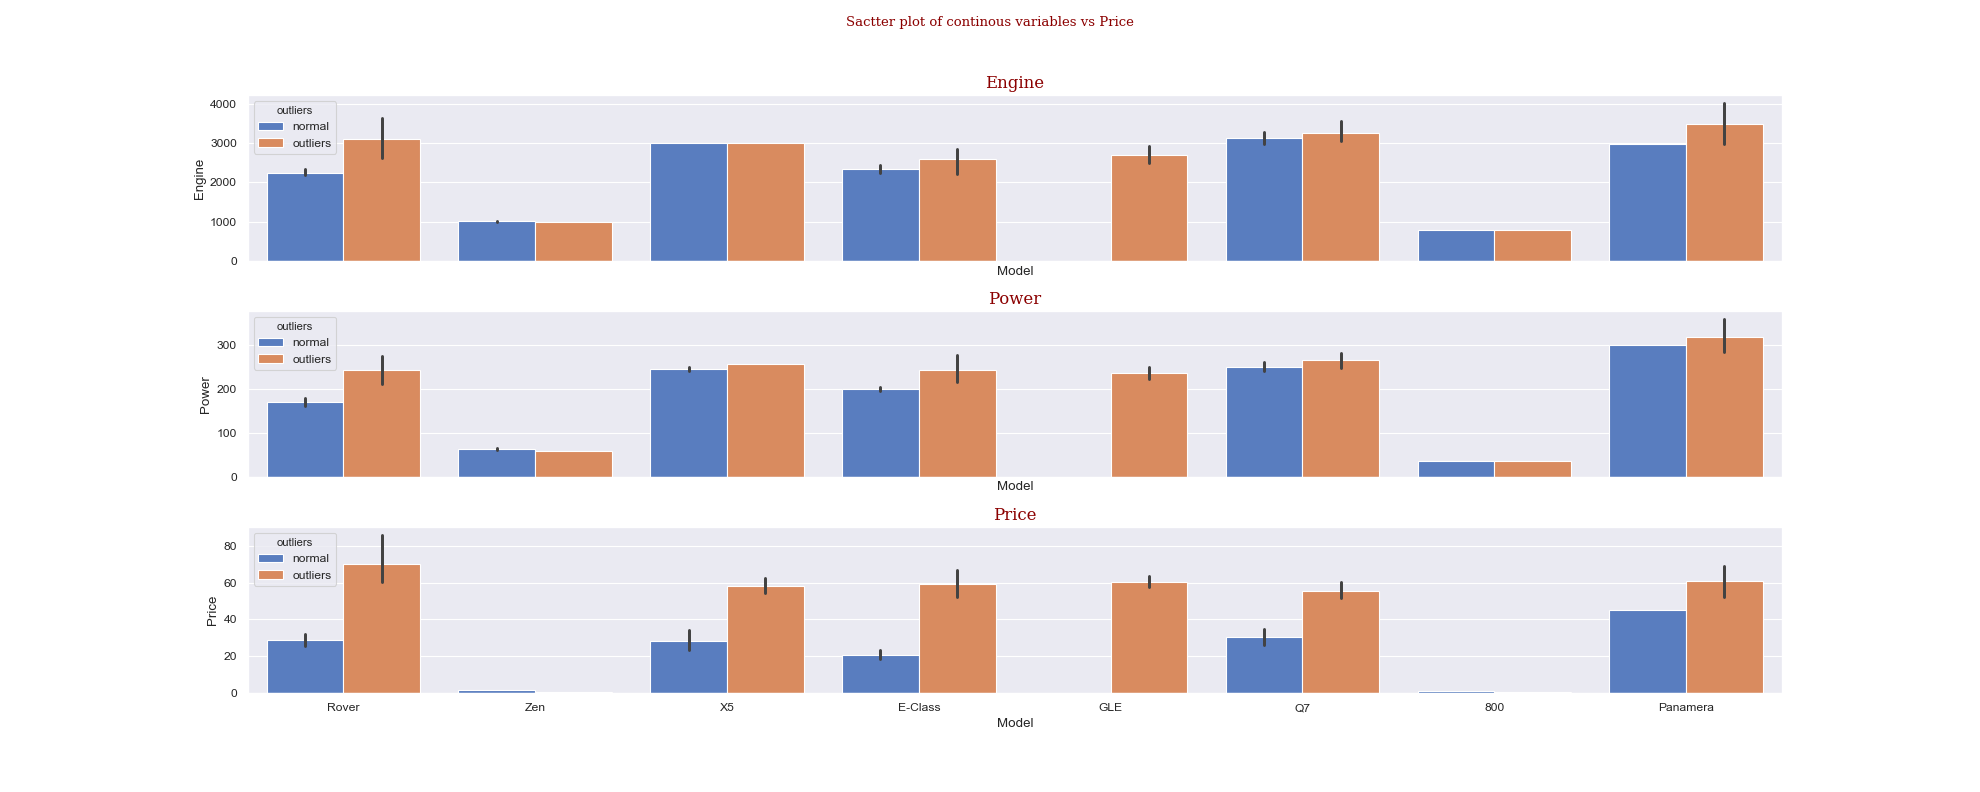

<IPython.core.display.Javascript object>


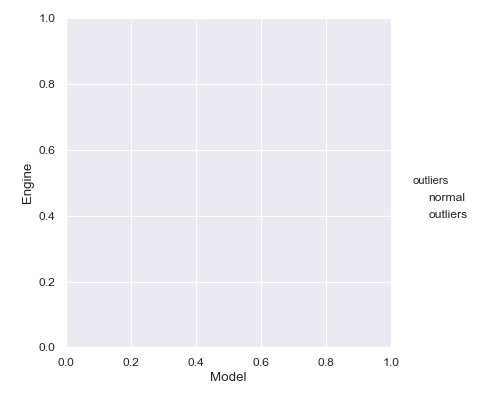

<IPython.core.display.Javascript object>


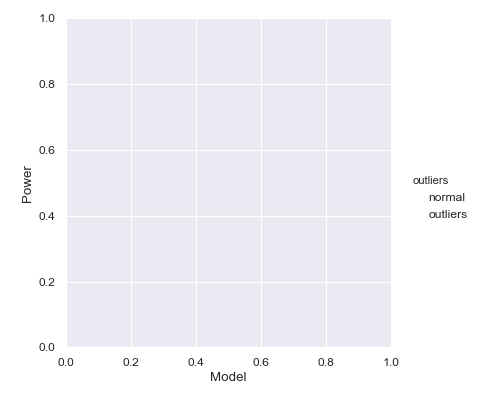

<IPython.core.display.Javascript object>


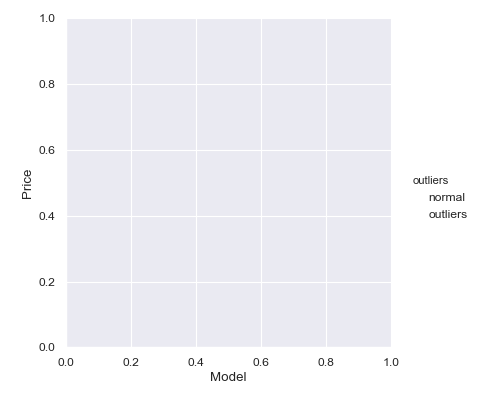

In [18]:
outliermodels = training_set.Model[~training_set.index.isin(inds)].value_counts().head(8)


cols = ['Engine', 'Power','Price']
fig,axes = plt.subplots(3,1,figsize=(25,10), sharex=True) #sharey=True
fig.subplots_adjust(wspace=0.1, hspace=0.3)
fig.suptitle('Sactter plot of continous variables vs Price', fontdict=font)
axes = axes.ravel()
df = training_set.loc[training_set.Model.isin(outliermodels.index),['Model','Engine', 'Power','Price']]

for i,col in enumerate(cols):
    df['outliers'] = 'normal'
    df.loc[~df.index.isin(inds),"outliers"] = 'outliers'
    sns.catplot(x="Model", y=col, hue="outliers", data=df, kind='bar',palette="muted", ax=axes[i])
    axes[i].set_title(col,fontdict = font, fontsize=15)

    

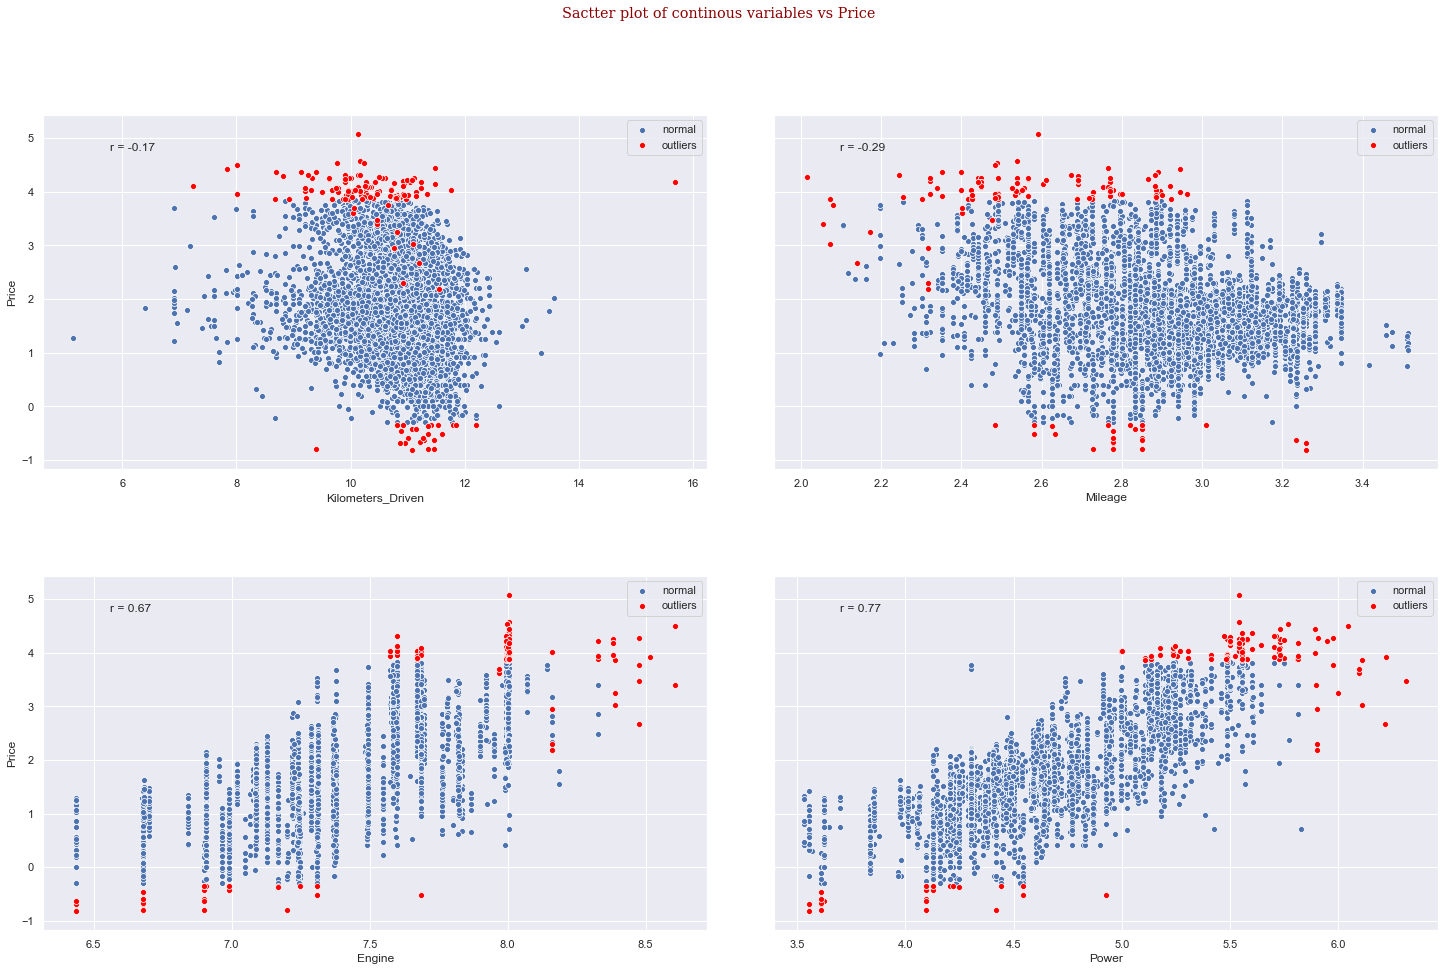

In [105]:
import itertools

cols = ['Kilometers_Driven', 'Mileage', 'Engine', 'Power']

fig,axes = plt.subplots(2,2,figsize=(25,15),sharey=True)
fig.subplots_adjust(wspace=0.1, hspace=0.3)
fig.suptitle('Sactter plot of continous variables vs Price', fontdict=font)
axes = axes.ravel()

for i,col in enumerate(cols):
    #inds = ~pd.isna(training_set[training_set.index.isin(inds)][col])
    #-----with log transformation
    x = training_set[training_set.index.isin(inds)][col].apply(np.log)
    y = training_set[training_set.index.isin(inds)]['Price'].apply(np.log)
    sns.scatterplot(x, y ,ax=axes[i],label = 'normal')
    
    x_out = training_set[~training_set.index.isin(inds)][col].apply(np.log)
    y_out = training_set[~training_set.index.isin(inds)]['Price'].apply(np.log)
    sns.scatterplot(x_out, y_out ,ax=axes[i], label = 'outliers', color = 'red')

    #----normal
    #sns.scatterplot(training_set[training_set.index.isin(inds)][col],training_set[training_set.index.isin(inds)]['Price'],ax=axes[i])
    
    
    # coreltaion annotation 
    r, _ = stats.pearsonr(x, y)
    
    axes[i].annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=axes[i].transAxes)

##### Outlier Removing using DBscan

In [46]:

X = training_set[['Kilometers_Driven','Mileage', 'Engine', 'Power','Price']].copy()
X = X.apply(np.log)

scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X.round(3)), columns=X.columns)


####        ***** Outlier detection IQR method  *********
'''Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1

inds = ~((X < (Q1 - 2 * IQR)) |(X > (Q3 + 2 * IQR))).any(axis=1)'''


####        ***** Outlier detection DBscan method  *********


def dbscan(X, eps=0.5, min_samples=5):
    X = X.apply(np.log)
    ss = StandardScaler()
    X = ss.fit_transform(X)
    db = DBSCAN(eps=eps, min_samples=min_samples)
    db.fit(X)
    y_pred = db.fit_predict(X)
    plt.scatter(X[:,1], X[:,2],c=y_pred, cmap='Paired')
    plt.title("DBSCAN")

#dbscan(training_set[['Kilometers_Driven','Mileage', 'Engine', 'Power','Price']], eps=.5, min_samples=2)
    

from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=1, metric='euclidean', min_samples=2)

dbscan.fit(X)
inds = training_set.index[dbscan.labels_>=0]


print(len(inds)/len(training_set))
training_set[training_set.index.isin(inds)].describe()

# ------------ uncoment to remove outlier in data
#training_set = training_set[training_set.index.isin(inds)]

ValueError: Metric 'mahalanobis V' not valid. Use sorted(sklearn.neighbors.VALID_METRICS['brute']) to get valid options. Metric can also be a callable function.

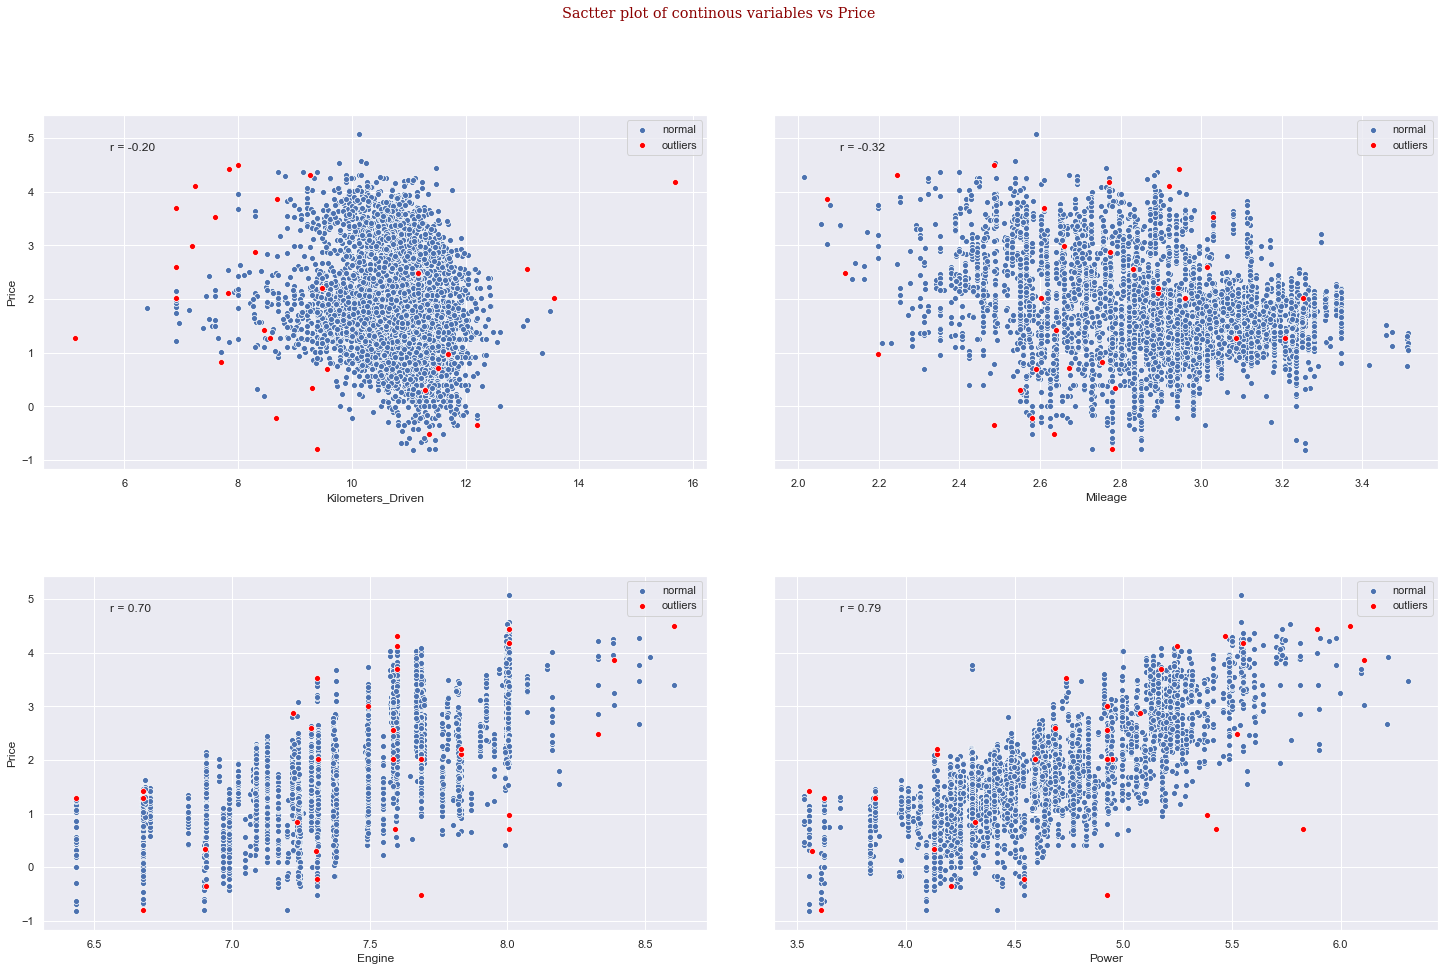

In [44]:
import itertools

cols = ['Kilometers_Driven', 'Mileage', 'Engine', 'Power']

fig,axes = plt.subplots(2,2,figsize=(25,15),sharey=True)
fig.subplots_adjust(wspace=0.1, hspace=0.3)
fig.suptitle('Sactter plot of continous variables vs Price', fontdict=font)
axes = axes.ravel()

for i,col in enumerate(cols):
    #inds = ~pd.isna(training_set[training_set.index.isin(inds)][col])
    #-----with log transformation
    x = training_set[training_set.index.isin(inds)][col].apply(np.log)
    y = training_set[training_set.index.isin(inds)]['Price'].apply(np.log)
    sns.scatterplot(x, y ,ax=axes[i],label = 'normal')
    
    x_out = training_set[~training_set.index.isin(inds)][col].apply(np.log)
    y_out = training_set[~training_set.index.isin(inds)]['Price'].apply(np.log)
    sns.scatterplot(x_out, y_out ,ax=axes[i], label = 'outliers', color = 'red')

    #----normal
    #sns.scatterplot(training_set[training_set.index.isin(inds)][col],training_set[training_set.index.isin(inds)]['Price'],ax=axes[i])
    
    
    # coreltaion annotation 
    r, _ = stats.pearsonr(x, y)
    
    axes[i].annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=axes[i].transAxes)

In [52]:
outlier_cnts.index

Index(['Octavia', 'Thar', 'XE', 'Omni', 'Captur', 'Nano', 'SLK-Class',
       'Renault', 'Corolla', 'Cooper', '800', 'Accord', 'Wagon', 'Jetta',
       'Compass', 'Q7', 'Cayenne', '6', 'Xenon', 'Alto', 'XJ', 'New', 'SLC',
       'Accent', 'X5', 'Classic', 'Spark', 'Figo', 'X3'],
      dtype='object')

In [20]:
outlier_cnts = train.Name[train.index.isin(inds)].value_counts()
print(outlier_cnts)
a = training_set.Model.value_counts()
print(a[a.index.isin(outlier_cnts.index)])

Mahindra XUV500 W8 2WD              48
Maruti Swift VDI                    44
Maruti Swift Dzire VDI              33
Honda City 1.5 S MT                 32
Maruti Swift VDI BSIV               31
                                    ..
Toyota Qualis FS B3                  1
Tata Indica V2 DLS TC                1
Fiat Punto 1.3 Emotion               1
Hyundai Verna 1.6 i ABS              1
Skoda Superb Elegance 1.8 TSI MT     1
Name: Name, Length: 1845, dtype: int64
Series([], Name: Model, dtype: int64)


In [19]:
outlier_cnts = train.Name[~train.index.isin(inds)].value_counts()
print(outlier_cnts)
a = training_set.Model.value_counts()
print(a[a.index.isin(outlier_cnts.index)])

Maruti Celerio VXI AT               2
Hyundai Grand i10 Sportz            2
Maruti Swift Dzire VDi              2
Hyundai i10 Sportz AT               2
Toyota Fortuner 4x2 Manual          2
                                   ..
Toyota Corolla H5                   1
Maruti Celerio VXI AT Optional      1
Mahindra KUV 100 mFALCON G80 K2     1
Honda Amaze S Diesel                1
Hyundai Creta 1.6 CRDi SX Option    1
Name: Name, Length: 158, dtype: int64
Series([], Name: Model, dtype: int64)


##### Outlier Removing using Isolation Forest

In [40]:
X = training_set[['Kilometers_Driven','Mileage', 'Engine', 'Power','Price']].copy()
X = X.apply(np.log)

#scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X.round(3)), columns=X.columns)

In [41]:
from sklearn.ensemble import IsolationForest
Iso = IsolationForest( behaviour = 'old', max_samples=500, bootstrap=True, random_state = 1,)
preds = Iso.fit_predict(X)
inds = X.index[preds==1]
print(len(inds),len(inds)/len(training_set))
training_set[training_set.index.isin(inds)].describe()

5392 0.8998664886515354


Year  Kilometers_Driven      Mileage       Engine        Power  \
count  5392.000000        5392.000000  5392.000000  5392.000000  5392.000000   
mean   2013.483680       57453.860720    18.602945  1567.957344   107.640695   
std       2.991752       34043.117993     3.933648   491.527777    41.093840   
min    2001.000000        3000.000000    10.000000   796.000000    46.300000   
25%    2012.000000       35347.000000    16.000000  1198.000000    75.000000   
50%    2014.000000       54000.000000    18.500000  1461.000000    90.000000   
75%    2016.000000       72139.000000    21.100000  1968.000000   126.320000   
max    2019.000000      775000.000000    33.540000  3198.000000   270.900000   

             Seats        Price  
count  5392.000000  5392.000000  
mean      5.280601     8.225022  
std       0.757140     7.730398  
min       4.000000     0.750000  
25%       5.000000     3.550000  
50%       5.000000     5.530000  
75%       5.000000     9.190000  
max      10.000000    59.720000

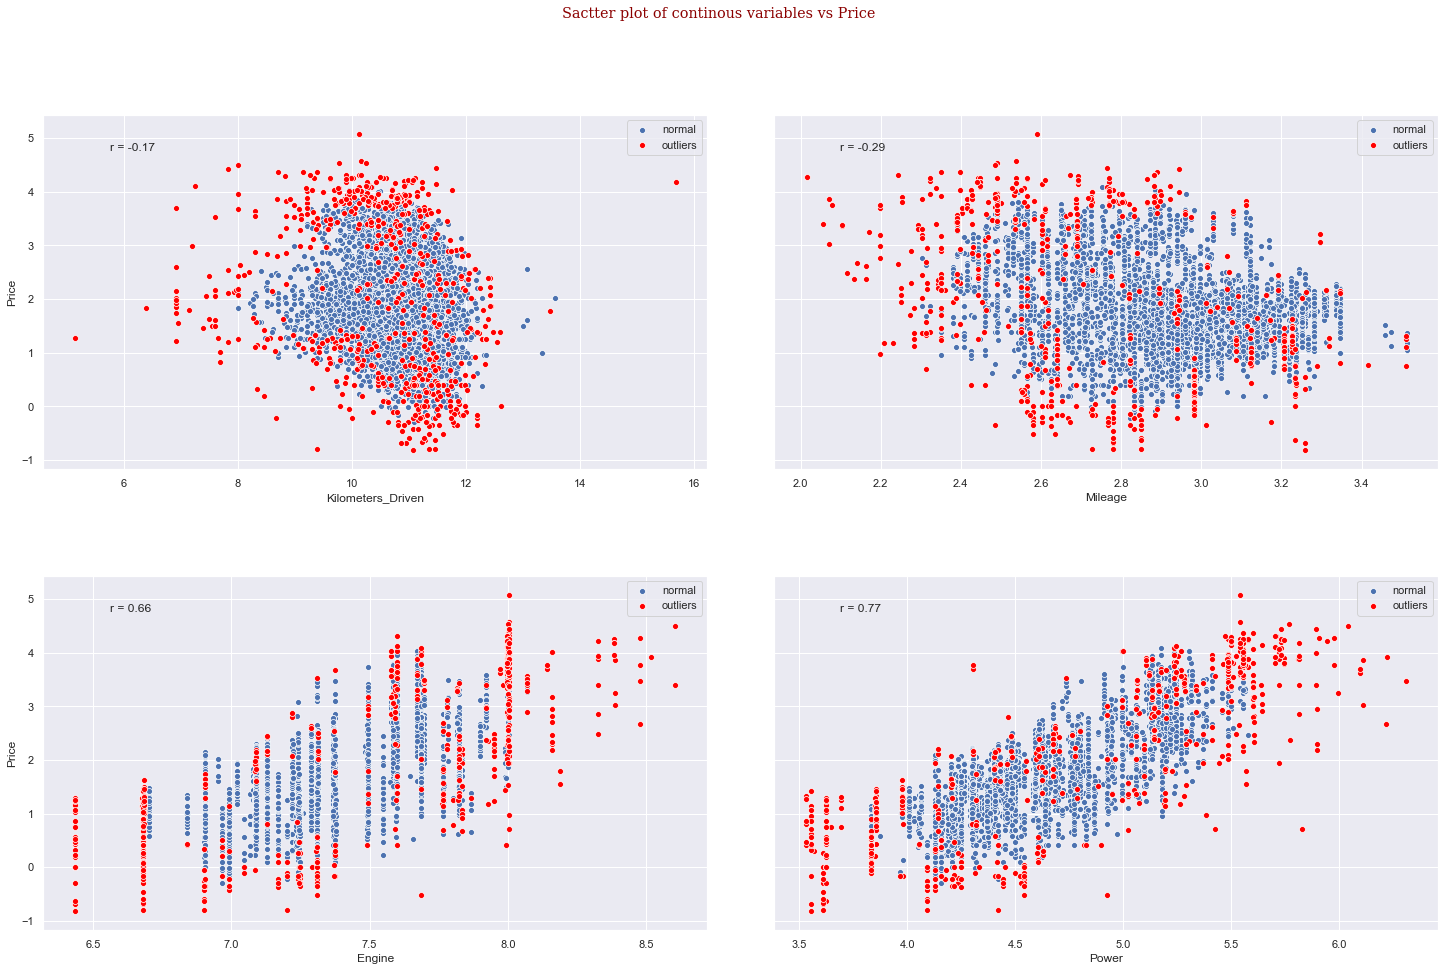

In [42]:
import itertools

cols = ['Kilometers_Driven', 'Mileage', 'Engine', 'Power']

fig,axes = plt.subplots(2,2,figsize=(25,15),sharey=True)
fig.subplots_adjust(wspace=0.1, hspace=0.3)
fig.suptitle('Sactter plot of continous variables vs Price', fontdict=font)
axes = axes.ravel()

for i,col in enumerate(cols):
    #inds = ~pd.isna(training_set[training_set.index.isin(inds)][col])
    #-----with log transformation
    x = training_set[training_set.index.isin(inds)][col].apply(np.log)
    y = training_set[training_set.index.isin(inds)]['Price'].apply(np.log)
    sns.scatterplot(x, y ,ax=axes[i],label = 'normal')
    
    x_out = training_set[~training_set.index.isin(inds)][col].apply(np.log)
    y_out = training_set[~training_set.index.isin(inds)]['Price'].apply(np.log)
    sns.scatterplot(x_out, y_out ,ax=axes[i], label = 'outliers', color = 'red')

    #----normal
    #sns.scatterplot(training_set[training_set.index.isin(inds)][col],training_set[training_set.index.isin(inds)]['Price'],ax=axes[i])
    
    
    # coreltaion annotation 
    r, _ = stats.pearsonr(x, y)
    
    axes[i].annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=axes[i].transAxes)

##### Outlier detection using PCA with mahnobalis distance metric

[0.61614355 0.24532525 0.11379821 0.02473298]


<IPython.core.display.Javascript object>


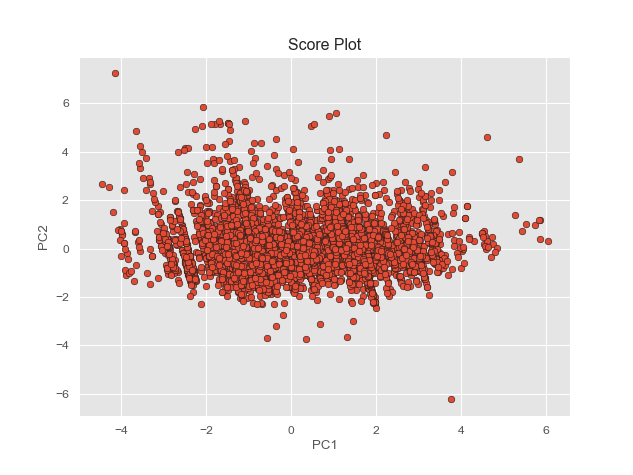

In [43]:
from sklearn.decomposition import PCA

cols = ['Kilometers_Driven', 'Mileage', 'Engine', 'Power']

X = training_set[cols].copy()
X = X.apply(np.log)

scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X.round(3)), columns=X.columns)


pca = PCA()
X_transformed = pca.fit_transform(StandardScaler().fit_transform(X))

print(pca.explained_variance_ratio_)
# Score plot of the first 2 PC
fig = plt.figure(figsize=(8,6))
with plt.style.context(('ggplot')):
    plt.scatter(X_transformed[:, 0], X_transformed[:, 1], edgecolors='k', cmap='jet')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('Score Plot')
plt.show()

<IPython.core.display.Javascript object>


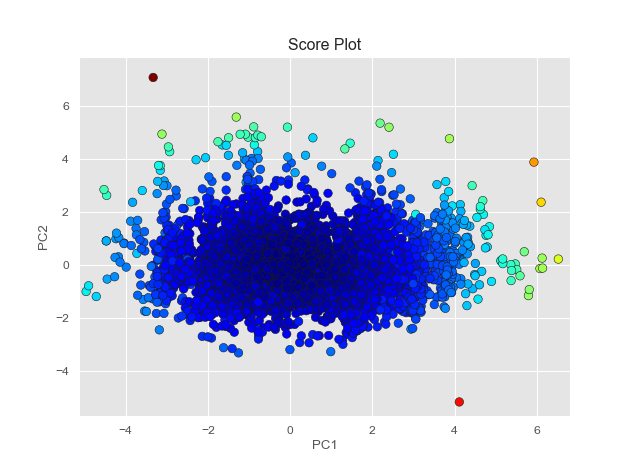

In [30]:
# Compute the euclidean distance using the first 5 PC
euclidean = np.zeros(X.shape[0])
for i in range(5):
    euclidean += (X_transformed[:,i] - np.mean(X_transformed[:,:5]))**2/np.var(X_transformed[:,:5])

colors = [plt.cm.jet(float(i)/max(euclidean)) for i in euclidean]
fig = plt.figure(figsize=(8,6))
with plt.style.context(('ggplot')):
    plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=colors, edgecolors='k', s=60)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.xlim((-60, 60))
    plt.ylim((-60, 60))
    plt.title('Score Plot')
plt.show()

<IPython.core.display.Javascript object>


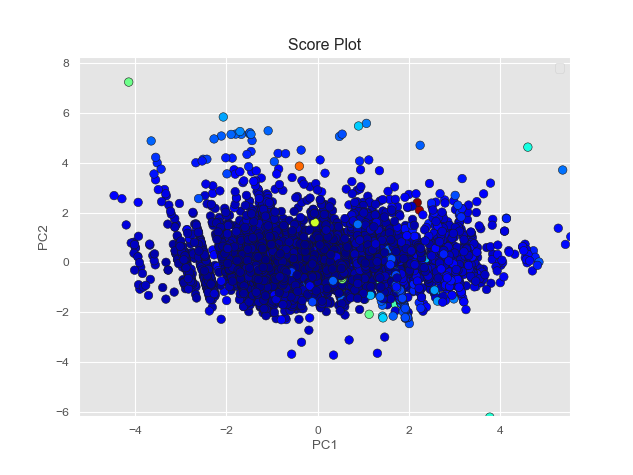

No handles with labels found to put in legend.


In [44]:
from sklearn.covariance import EmpiricalCovariance, MinCovDet

# fit a Minimum Covariance Determinant (MCD) robust estimator to data 
robust_cov = MinCovDet().fit(X_transformed[:,:5])

# Get the Mahalanobis distance
m = robust_cov.mahalanobis(X_transformed[:,:5])

colors = [plt.cm.jet(float(i)/max(m)) for i in m]
fig = plt.figure(figsize=(8,6))
with plt.style.context(('ggplot')):
    plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=colors, edgecolors='k', s=60)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.xlim((-60, 60))
    plt.ylim((-60, 60))
    plt.title('Score Plot')
    plt.legend()
plt.show()

<IPython.core.display.Javascript object>


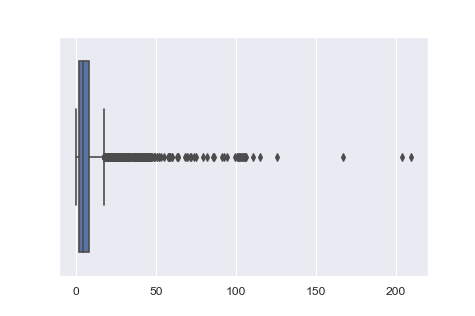

array([False, False, False, ...,  True, False, False])

In [45]:
plt.figure()
sns.boxplot(m);
m>5

<IPython.core.display.Javascript object>


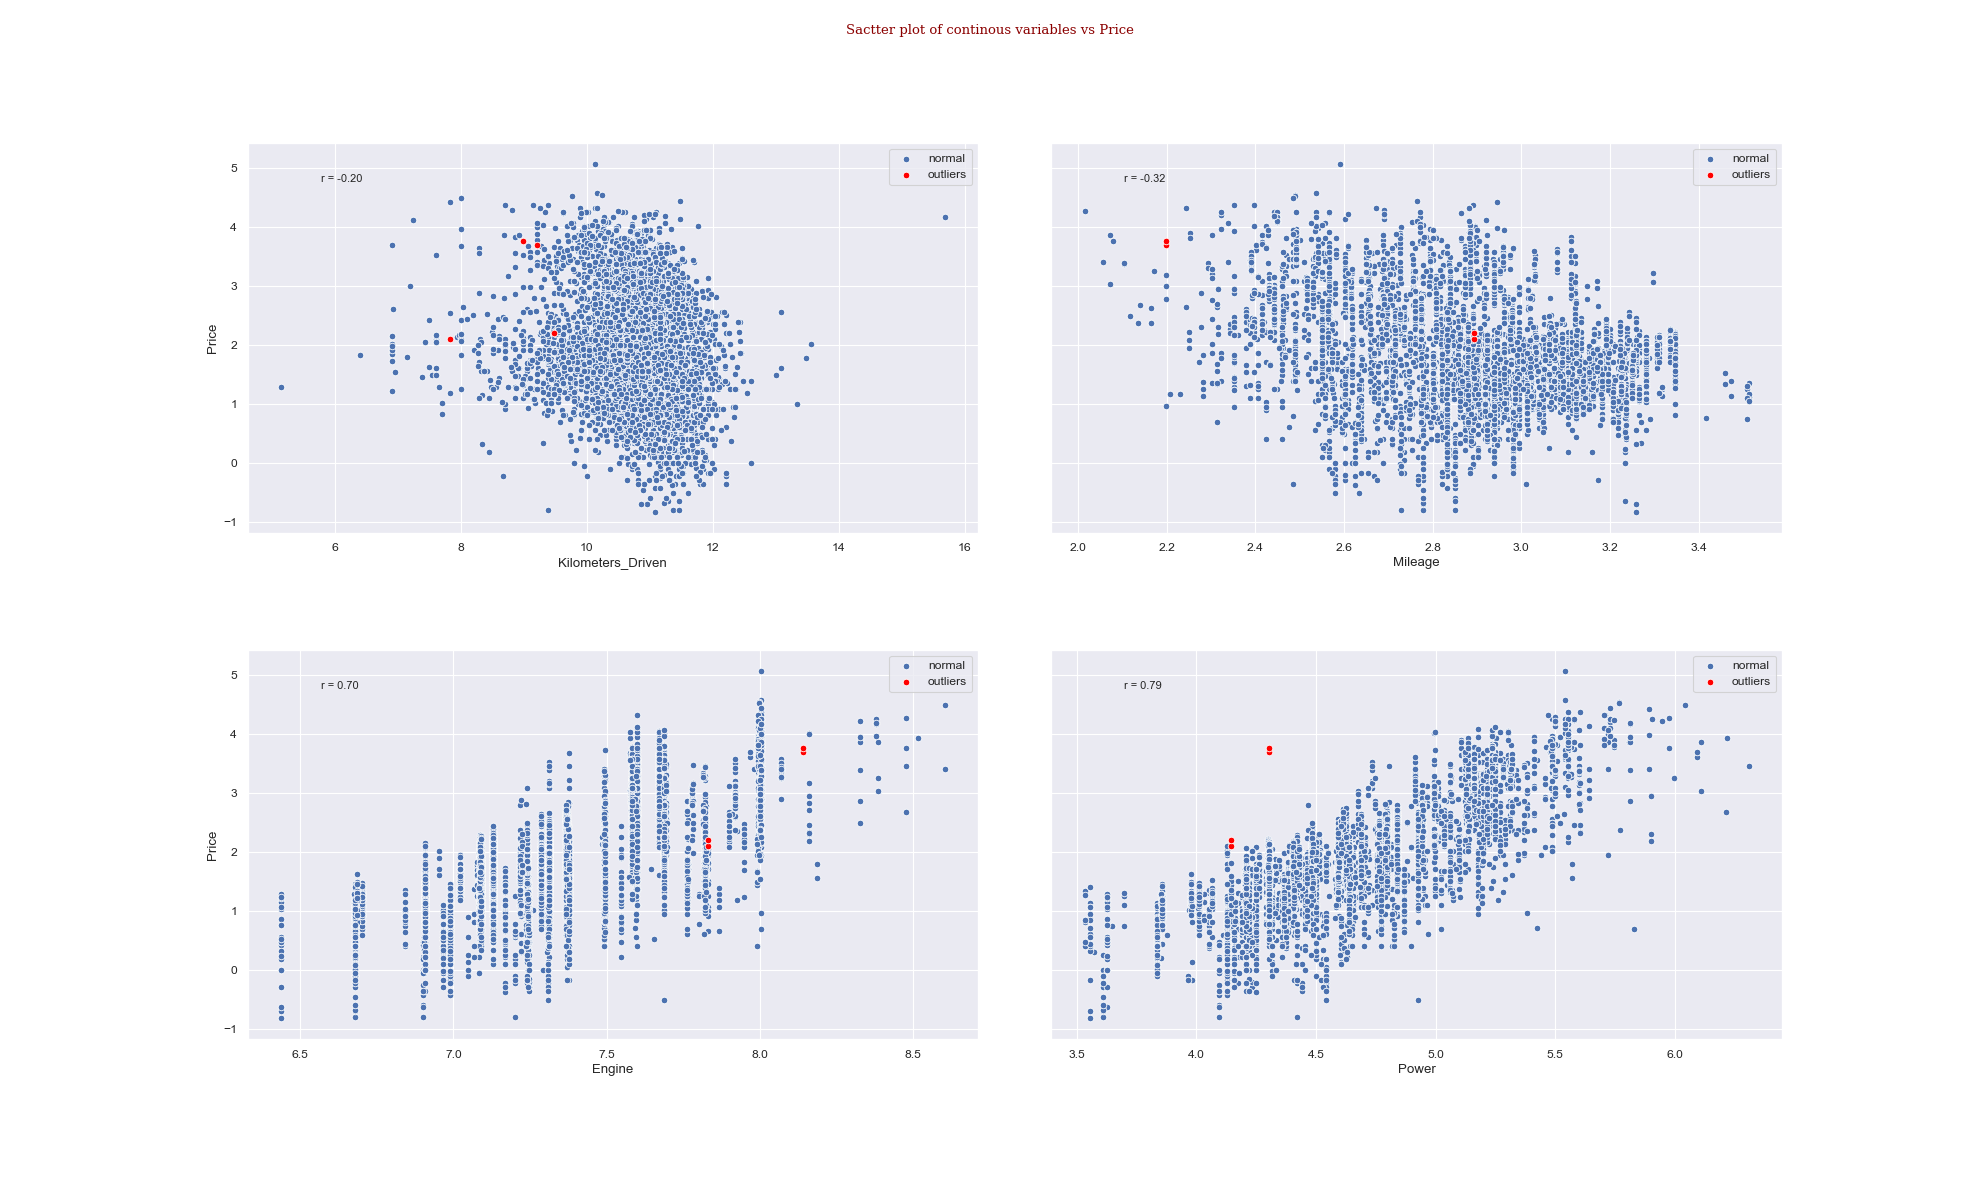

In [46]:
import itertools

inds = training_set.index[m<120]

cols = ['Kilometers_Driven', 'Mileage', 'Engine', 'Power']

fig,axes = plt.subplots(2,2,figsize=(25,15),sharey=True)
fig.subplots_adjust(wspace=0.1, hspace=0.3)
fig.suptitle('Sactter plot of continous variables vs Price', fontdict=font)
axes = axes.ravel()

for i,col in enumerate(cols):
    #inds = ~pd.isna(training_set[training_set.index.isin(inds)][col])
    #-----with log transformation
    x = training_set[training_set.index.isin(inds)][col].apply(np.log)
    y = training_set[training_set.index.isin(inds)]['Price'].apply(np.log)
    sns.scatterplot(x, y ,ax=axes[i],label = 'normal')
    
    x_out = training_set[~training_set.index.isin(inds)][col].apply(np.log)
    y_out = training_set[~training_set.index.isin(inds)]['Price'].apply(np.log)
    sns.scatterplot(x_out, y_out ,ax=axes[i], label = 'outliers', color = 'red')

    #----normal
    #sns.scatterplot(training_set[training_set.index.isin(inds)][col],training_set[training_set.index.isin(inds)]['Price'],ax=axes[i])
    
    
    # coreltaion annotation 
    r, _ = stats.pearsonr(x, y)
    
    axes[i].annotate("r = {:.2f}".format(r),
                xy=(.1, .9), xycoords=axes[i].transAxes)

##### Mahalobis distance outlier 

In [ ]:
from scipy.spatial.distance import mahalanobis
import scipy as sp
from sklearn.decomposition import PCA



X = training_set[cols].copy()
X = X.apply(np.log)

scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X.round(3)), columns=X.columns)


pca = PCA()
x = pca.fit_transform(StandardScaler().fit_transform(X))


cols = ['Engine', 'Power', "Price"]
x = training_set[cols]

Sx = x.cov().values
Sx = sp.linalg.inv(Sx)

mean = x.mean().values

def mahalanobisR(X,meanCol,IC):
    m = []
    for i in range(X.shape[0]):
        m.append(mahalanobis(X.iloc[i,:],meanCol,IC) ** 2)
    return(m)

mR = mahalanobisR(x,mean,Sx)

In [ ]:

colors = [plt.cm.jet(float(i)/max(mR)) for i in mR]
fig = plt.figure(figsize=(8,6))
with plt.style.context(('ggplot')):
    plt.scatter(x.iloc[:, 0], x.iloc[:, 1], c=colors, edgecolors='k', s=60)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    #plt.xlim((-60, 60))
    #plt.ylim((-60, 60))
    plt.title('Score Plot')
    plt.legend()
plt.show()

#### Train and Test split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(training_set.iloc[:,:-1],training_set['Price'].values, 
                                                    test_size = 0.2,stratify = training_set.Model, shuffle = True,random_state = 0)

NameError: name 'sns' is not defined

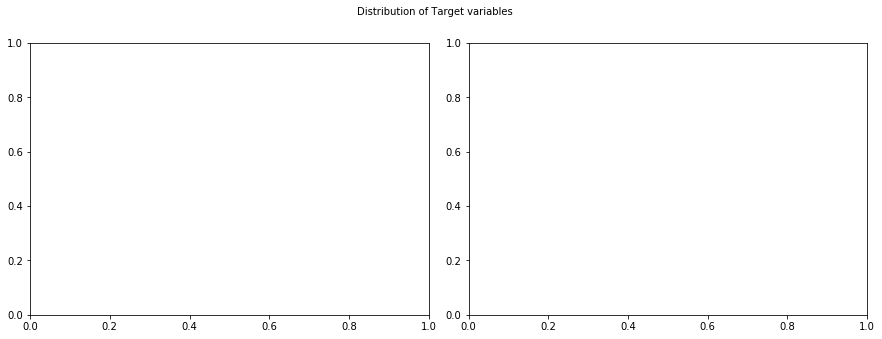

In [21]:
con_cols = ['Kilometers_Driven','Mileage', 'Engine', 'Power', "Price"]
fig,axes = plt.subplots(1,2,figsize=(15,5))
fig.subplots_adjust(wspace=0.1, hspace=0.3)
fig.suptitle('Distribution of Target variables', fontsize=10)
axes = axes.ravel()

for i,col in enumerate([y_train, y_test]):
    sns.distplot(np.log(col), hist= False,ax=axes[i])
    axes[i].set_title(['Train', 'Test'][i],fontdict = font, fontsize=12)    #axes[i].set_title(col,fontsize=25)


In [106]:
class DFRecursiveFeatureSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self,estimator=DecisionTreeRegressor(), n_features = 10, step=10):
        self.estimator = estimator
        self.n_features = n_features
        self.step = step
        
    def fit(self, X, y=None):
        # stateless transformer
        self.RFE = RFE(estimator=self.estimator, n_features_to_select=self.n_features, step=self.step)
        self.RFE.fit(X,y)
        return self

    def transform(self, X):
        return X.loc[:,self.RFE.get_support()]

class DFembedFeatureSelection():
    
    def __init__(self,estimator=DecisionTreeRegressor(), n_features = 10):
        self.estimator = estimator
        self.n_features = n_features
        
    def fit(self, X, y=None):
        # stateless transformer
        self.estimator.fit(X,y)
        return self

    def transform(self, X):
        ind = self.estimator.feature_importances_.argsort()[-self.n_features:][::-1]
        return X.iloc[:,ind]
    
class DFSelectKBest():
    
    def __init__(self,estimator=mutual_info_regression, n_features = 10):
        self.estimator = estimator
        self.n_features = n_features
        
    def fit(self, X, y=None):
        # stateless transformer
        self.SelectKBest = SelectKBest(self.estimator, k=self.n_features)
        self.SelectKBest.fit(X,y)
        return self

    def transform(self, X):
        return X.loc[:,self.SelectKBest.get_support()]

class DFadd_ColInteraction():
    
    def __init__(self,col1,col2):
        self.col1 = col1
        self.col2 = col2
        
    def fit(self, X, y=None):
        # stateless transformer
        return self

    def transform(self, X):
        X[f'{self.col1}_&_{self.col2}'] = X[self.col1]*X[self.col2]
        return X
    
class DFremoveOutlier_IQR():
    
    def __init__(self,factor = 1.5):
        self.factor = factor

        
    def fit(self, X, y=None):
        # stateless transformer
        self.y = y
        return self

    def transform(self, X):

        Q1 = X.quantile(0.25)
        Q3 = X.quantile(0.75)
        IQR = Q3 - Q1

        inds = ~((X < (Q1 - self.factor * IQR)) |(X > (Q3 + self.factor * IQR))).any(axis=1)
        X_screened = X[inds]
        y = self.y[inds]
        return X_screened, y
    
class DFdrop_Cols(BaseEstimator, TransformerMixin):
    
    def __init__(self,cols = None):
        self.cols = cols
        
    def fit(self, X, y=None):
        # stateless transformer
        return self

    def transform(self, X):
        X.drop(self.cols, axis=1, inplace=True)
        return X

## Model Building PipeLines

### columns segregation

In [5]:
# columns segregation
Tar_cols = ['Brand', 'Model', 'Location']
con_cols = ['Kilometers_Driven','Mileage', 'Engine', 'Power']
One_hot_cols = ['Fuel_Type', 'Transmission', 'Owner_Type']
Year = ["Year"]
Seats = ["Seats"]

### Simple Linear Regression

In [54]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

TransformPipeline_lin = Pipeline([
    ('features',DFFeatureUnion([
        ('numerics', Pipeline([
            ('extract',ColumnExtractor(con_cols)),
            ('log', Log1pTransformer()),
            ('col_Interact',DFadd_ColInteraction('Kilometers_Driven','Mileage')),
            ('col_drop',DFdrop_Cols(cols=['Kilometers_Driven','Mileage','Engine']))])),
        ('nominal_OneHot',Pipeline([
            ('extract',ColumnExtractor(One_hot_cols)),
            ('dummy',DF_OneHotEncoder(filter_threshold = 0.05))])),
        ('nominal_Target', Pipeline([
            ('extract',ColumnExtractor(Tar_cols)),
            ('Mean_Enc',TargetEncoder())])),
        ('Year',Pipeline([
            ('extract',ColumnExtractor(Year)),
            ('Shift',ShiftTranformer(par=2019))])),
        ('Seats',Pipeline([
            ('extract',ColumnExtractor(Seats))]))
            
        ])),
    ('scale', DFStandardScaler()),
    ('feature_selection',DFRecursiveFeatureSelector(estimator=LinearRegression(),n_features = 15)),
    ])

#TransformPipeline_lin.fit_transform(X_train,y=np.log(y_train))

### Linear regression Models

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     5468.
Date:                Wed, 29 Apr 2020   Prob (F-statistic):               0.00
Time:                        22:30:34   Log-Likelihood:                 306.25
No. Observations:                4793   AIC:                            -586.5
Df Residuals:                    4780   BIC:                            -502.3
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

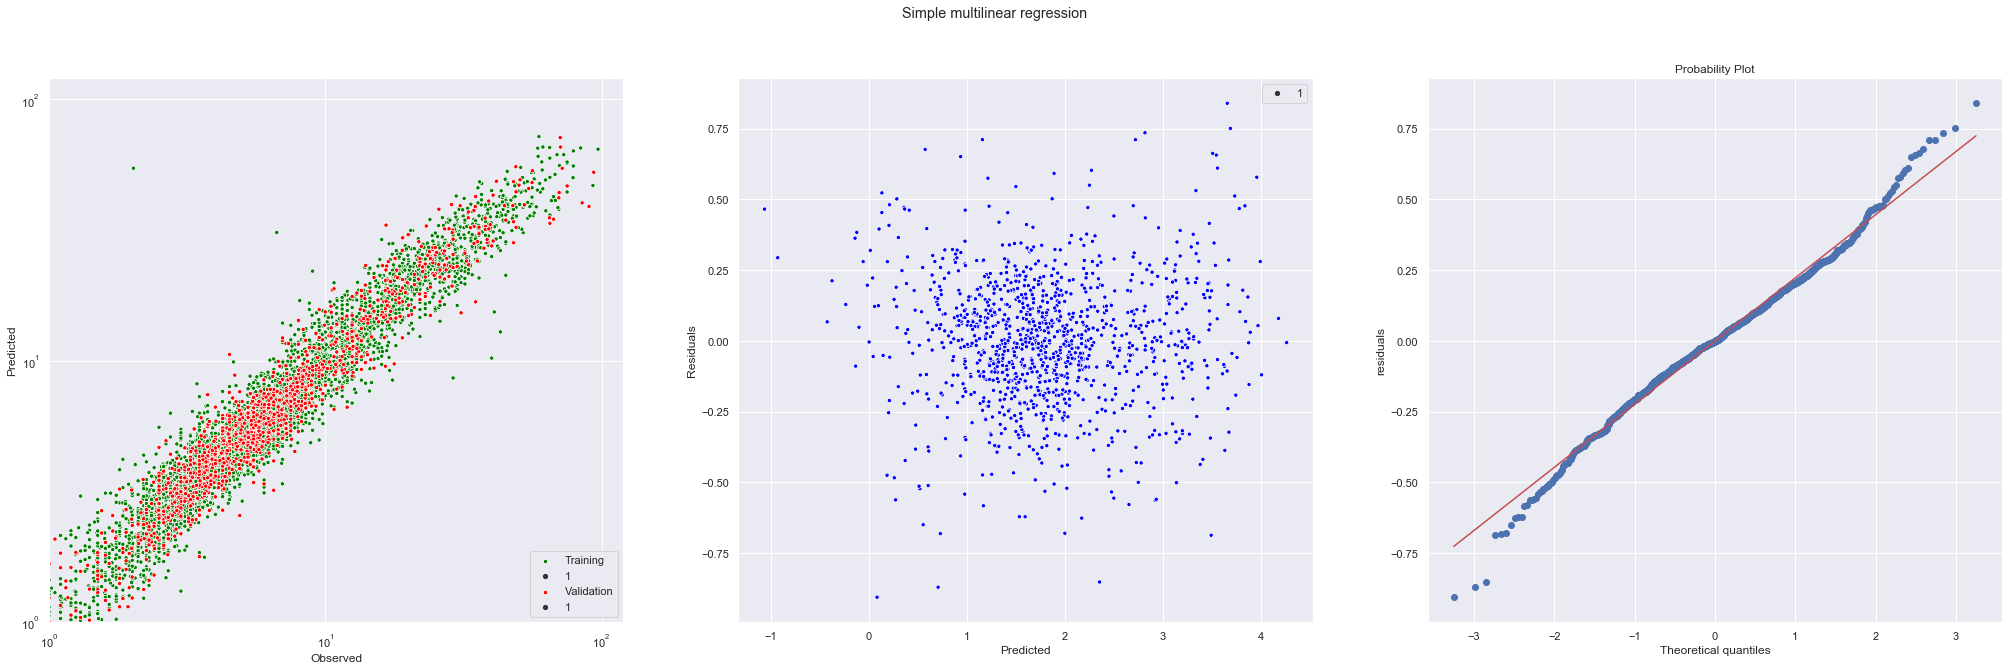

In [55]:
from sklearn.metrics import mean_squared_log_error

def score(y,pred):
    return 1-(mean_squared_log_error(y,pred))**0.5
    

train_x = TransformPipeline_lin.fit_transform(X_train,y=np.log(y_train))
test_x = TransformPipeline_lin.transform(X_test)

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score, mean_squared_log_error

mod = LinearRegression()
mod.fit(train_x,np.log(y_train))

train_pred_y = np.exp(mod.predict(train_x))
test_pred_y = np.exp(mod.predict(test_x))


#---- Generating Model summary results using OLS from statsmodel
X_ols = sm.add_constant(train_x)
ols = sm.OLS(np.log(y_train), X_ols)
results = ols.fit()
print(results.summary())


#---- Clipping more than zero

vfunc = np.vectorize(lambda x: max(0,x))
train_pred_y = vfunc(train_pred_y)
test_pred_y = vfunc(test_pred_y)



'''#   ****** Pipeline Grid Parameter ********

svm_param_grid = {
    "reduce_dim": ["passthrough", TruncatedSVD(10), TruncatedSVD(20)],
    "tfidf__analyzer": ["word", "char"],
    "tfidf__smooth_idf": [True, False],
    "tfidf__ngram_range": [(1, 1), (1, 2)],
    "tfidf__use_idf": [True, False],
    "tfidf__stop_words": [None, STOP_WORDS],
    "classifier__class_weight": [None, "balanced"],
    "classifier__C": [1, 10, 100, 1000],
    "classifier__gamma": [0.001, 0.0001],
    "classifier__kernel": ["linear", "rbf"],
}

# ******* Use them in Grid Search *****
search = RandomizedSearchCV(pipeline, param_distributions=svm_param_grid, verbose=8)
search.fit(train_data, train_target)'''

#--- Printing the score for validation sets

print(f"\n\n Linear Regression R-Squared: Training = {round(r2_score(train_pred_y, y_train),3)}, Validation = {round(r2_score(test_pred_y, y_test),3)}")
print(f"\n Linear Regression SCORE: Training = {round(score(train_pred_y, y_train),3)}, Validation = {round(score(test_pred_y, y_test),3)}")




#          *********** Plot validation and Residuals  ********
plt.figure(figsize= (35,10))
plt.suptitle('Simple multilinear regression')
ax1 = plt.subplot(131)
plt.xscale('log')
plt.yscale('log')
sns.scatterplot(y_train,train_pred_y,size=1, color = 'green',label = 'Training',ax=ax1);
sns.scatterplot(y_test,test_pred_y,size=1,color = 'red', label = 'Validation',ax=ax1);
plt.axis([1,120,1,120]);
plt.xlabel('Observed');
plt.ylabel('Predicted');
plt.legend(loc = 4);


ax2 = plt.subplot(132)
sns.scatterplot(np.log(test_pred_y),(np.log(y_test)-np.log(test_pred_y)) ,size=1, color = 'blue',ax=ax2)
plt.xlabel('Predicted');
plt.ylabel('Residuals');

ax3 = plt.subplot(133)
stats.probplot((np.log(y_test)-np.log(test_pred_y)), plot=ax3)
plt.ylabel('residuals');

#### Simple Linear regression model

In [7]:
from sklearn.ensemble import RandomForestRegressor
TransformPipeline_lin = Pipeline([
    ('features',DFFeatureUnion([
        ('numerics', Pipeline([
            ('extract',ColumnExtractor(con_cols)),
            ('log', Log1pTransformer()),
            ('col_Interact',DFadd_ColInteraction('Kilometers_Driven','Mileage')),
            ('col_drop',DFdrop_Cols(cols=['Kilometers_Driven','Mileage','Engine']))])),
        ('nominal_OneHot',Pipeline([
            ('extract',ColumnExtractor(One_hot_cols)),
            ('dummy',DummyTransformer())])),
        ('nominal_Target', Pipeline([
            ('extract',ColumnExtractor(Tar_cols)),
            ('Mean_Enc',TargetEncoder())])),
        ('Year',Pipeline([
            ('extract',ColumnExtractor(Year)),
            ('Shift',ShiftTranformer(par=2019))])),
        ('Seats',Pipeline([
            ('extract',ColumnExtractor(Seats))]))
            
        ])),
    ('poly_transform',DF_PolynomialFeatures()),
    ('scale', DFStandardScaler()),
    ('feature_selection',DFRecursiveFeatureSelector(LinearRegression())),
    ('Model_fit',DF_Model(LinearRegression()))

    ])

TransformPipeline_lin.fit_transform(X_train,y=np.log(y_train))

Transmission=Automatic     Model  \
2744               -0.631670 -0.138482   
2315               -0.631670  0.268240   
3056               -0.631670 -0.642014   
3970                1.583104 -0.753952   
1299               -0.631670 -0.355981   
...                      ...       ...   
972                 1.583104  1.087968   
1258               -0.631670 -0.247518   
5693               -0.631670 -0.763515   
17                 -0.631670 -0.412722   
776                 1.583104  1.670025   

      Fuel_Type=Diesel Transmission=Automatic  \
2744                                -0.474227   
2315                                -0.474227   
3056                                -0.474227   
3970                                -0.474227   
1299                                -0.474227   
...                                       ...   
972                                  2.108694   
1258                                -0.474227   
5693                                -0.474227   
17                                  -0.474227   
776                                  2.108694   

      Fuel_Type=LPG Transmission=Manual  \
2744                          -0.045725   
2315                          -0.045725   
3056                          -0.045725   
3970                          -0.045725   
1299                          -0.045725   
...                                 ...   
972                           -0.045725   
1258                          -0.045725   
5693                          -0.045725   
17                            -0.045725   
776                           -0.045725   

      Fuel_Type=Petrol Transmission=Automatic  \
2744                                -0.336300   
2315                                -0.336300   
3056                                -0.336300   
3970                                 2.973531   
1299                                -0.336300   
...                                       ...   
972                                 -0.336300   
1258                                -0.336300   
5693                                -0.336300   
17                                  -0.336300   
776                                 -0.336300   

      Owner_Type=First Transmission=Manual  \
2744                              0.841864   
2315                             -1.187841   
3056                              0.841864   
3970                             -1.187841   
1299                              0.841864   
...                                    ...   
972                              -1.187841   
1258                              0.841864   
5693                             -1.187841   
17                                0.841864   
776                              -1.187841   

      Owner_Type=Second Transmission=Manual  \
2744                              -0.358184   
2315                               2.791862   
3056                              -0.358184   
3970                              -0.358184   
1299                              -0.358184   
...                                     ...   
972                               -0.358184   
1258                              -0.358184   
5693                               2.791862   
17                                -0.358184   
776                               -0.358184   

      Owner_Type=Third Transmission=Manual  Transmission=Automatic Model  \
2744                             -0.120856                     -0.595788   
2315                             -0.120856                     -0.595788   
3056                             -0.120856                     -0.595788   
3970                             -0.120856                      0.415229   
1299                             -0.120856                     -0.595788   
...                                    ...                           ...   
972                              -0.120856                      1.571339   
1258                             -0.120856                     -0.595788   
5693

In [52]:
from sklearn.linear_model import Lasso, Ridge

In [ ]:
pipe_params= {'Model_fit__estimator':[Lasso(),Ridge()],
              'Model_fit__estimator__alpha':[0.01,0.1,0.5,1,2],
              'feature_selection__n_features':[10,15,20],
              'poly_transform__degree':[1,2],
              'feature_selection__n_features':[10,15,20]}


Regressor = GridSearchCV(TransformPipeline_lin,
                         param_grid=pipe_params,
                        scoring = 'neg_mean_squared_error',
                        n_jobs = 1,
                        cv = 5,verbose=50)
Regressor.fit(X_train,y=np.log(y_train));

In [69]:
Regressor.best_score_

-0.058027972861409954

#  continue

* Looking at Residual plot, It can be infered Data is exibiting heteroscadasticity hence linear is not appropriate. Take a look at some some non linear models. perhabs my data has high varaibilty at higher levels.

* Looking at features that are Tree based algorithms are best suited for this process as most of the varibles are discrete in nature (including Power and Engine).

#### Linear Regression with  Ridge regression

In [12]:
from sklearn.linear_model import ridge_regression, Ridge
TransformPipeline_svc = Pipeline([
    ('features',DFFeatureUnion([
        ('numerics', Pipeline([
            ('extract',ColumnExtractor(con_cols)),
            ('log', Log1pTransformer()),
            ('col_Interact',DFadd_ColInteraction('Kilometers_Driven','Mileage')),
            ('col_drop',DFdrop_Cols(cols=['Kilometers_Driven','Mileage']))])),
        ('nominal_OneHot',Pipeline([
            ('extract',ColumnExtractor(One_hot_cols)),
            ('dummy',DummyTransformer())])),
        ('nominal_Target', Pipeline([
            ('extract',ColumnExtractor(Tar_cols)),
            ('Mean_Enc',TargetEncoder())])),
        ('Year',Pipeline([
            ('extract',ColumnExtractor(Year)),
            ('Shift',ShiftTranformer(par=2019))])),
        ('Seats',Pipeline([
            ('extract',ColumnExtractor(Seats))]))
            
        ])),
    ('poly_transform', DF_PolynomialFeatures()),
    ('scale', DFRobustScaler()),
    ('feature_selection',DFRecursiveFeatureSelector(RandomForestRegressor(n_estimators=100),n_features=20)),
    ('Model_fit',DF_Model(estimator = Ridge()))
    ])

NameError: name 'con_cols' is not defined

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.730
Model:                            OLS   Adj. R-squared:                  0.730
Method:                 Least Squares   F-statistic:                     1374.
Date:                Thu, 05 Mar 2020   Prob (F-statistic):               0.00
Time:                        22:23:38   Log-Likelihood:                -14023.
No. Observations:                4581   AIC:                         2.807e+04
Df Residuals:                    4571   BIC:                         2.813e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

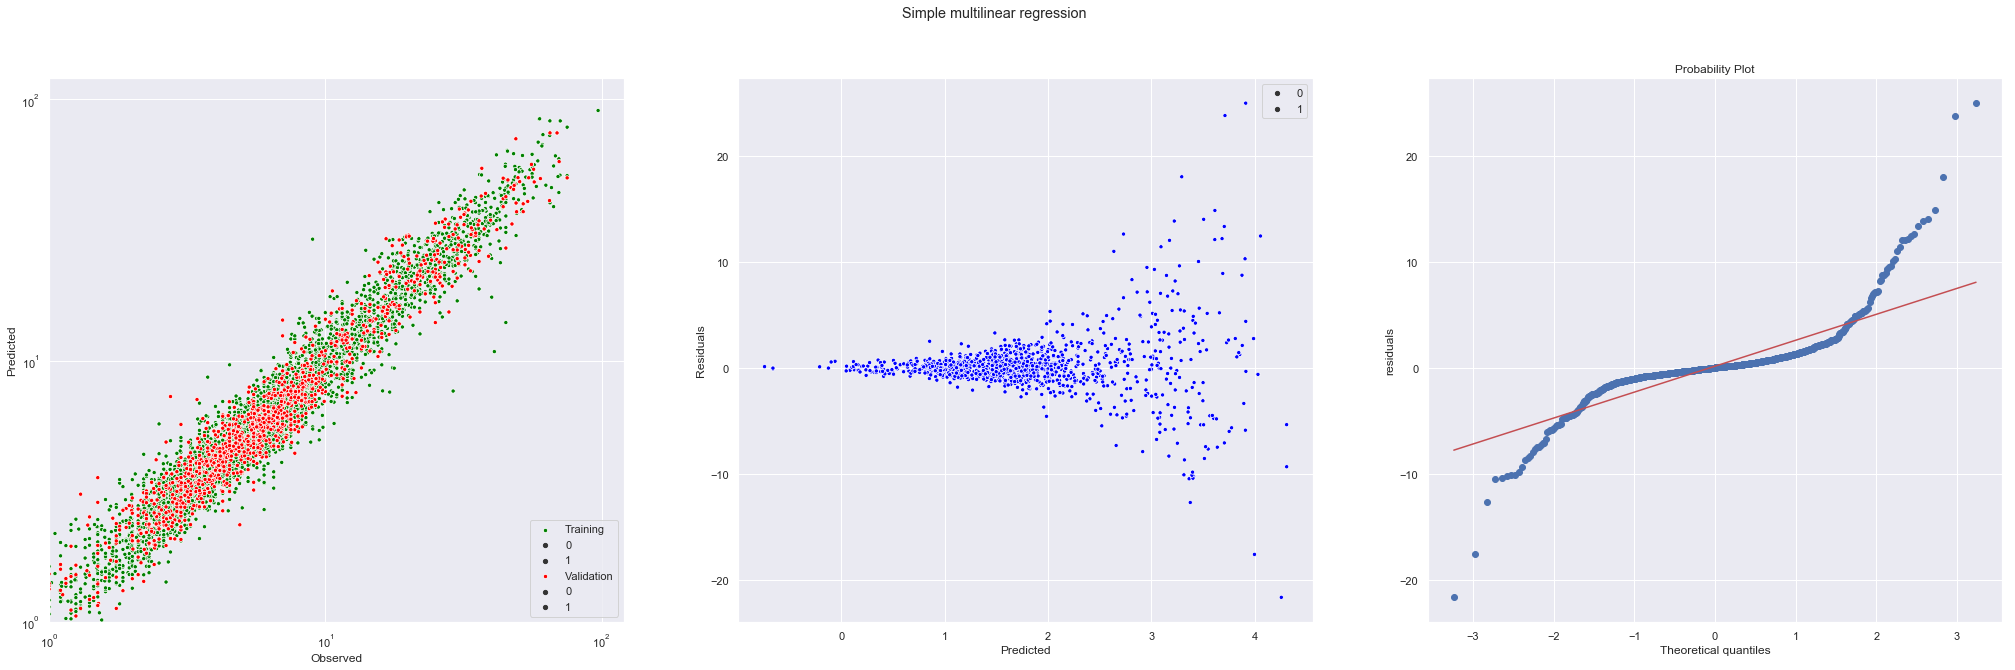

In [128]:
#TransformPipeline.fit(X_train,y=np.log(y_train))

train_pred_y = np.exp(TransformPipeline.fit_transform(X_train,y=np.log(y_train)))
test_pred_y = np.exp(TransformPipeline.transform(X_test))


#---- Generating Model summary results using OLS from statsmodel
X_ols = sm.add_constant(train_x)
ols = sm.OLS(y_train, X_ols)
results = ols.fit()
print(results.summary())


#---- Clipping more than zero

vfunc = np.vectorize(lambda x: max(0,x))
train_pred_y = vfunc(train_pred_y)
test_pred_y = vfunc(test_pred_y)



'''#   ****** Pipeline Grid Parameter ********

svm_param_grid = {
    "reduce_dim": ["passthrough", TruncatedSVD(10), TruncatedSVD(20)],
    "tfidf__analyzer": ["word", "char"],
    "tfidf__smooth_idf": [True, False],
    "tfidf__ngram_range": [(1, 1), (1, 2)],
    "tfidf__use_idf": [True, False],
    "tfidf__stop_words": [None, STOP_WORDS],
    "classifier__class_weight": [None, "balanced"],
    "classifier__C": [1, 10, 100, 1000],
    "classifier__gamma": [0.001, 0.0001],
    "classifier__kernel": ["linear", "rbf"],
}

# ******* Use them in Grid Search *****
search = RandomizedSearchCV(pipeline, param_distributions=svm_param_grid, verbose=8)
search.fit(train_data, train_target)'''

#--- Printing the score for validation sets

print(f"\n\n Linear Regression R-Squared: Training = {round(r2_score(train_pred_y, y_train),3)}, Validation = {round(r2_score(test_pred_y, y_test),3)}")
print(f"\n Linear Regression SCORE: Training = {round(score(train_pred_y, y_train),3)}, Validation = {round(score(test_pred_y, y_test),3)}")




#          *********** Plot validation and Residuals  ********
plt.figure(figsize= (35,10))
plt.suptitle('Simple multilinear regression')
ax1 = plt.subplot(131)
plt.xscale('log')
plt.yscale('log')
sns.scatterplot(y_train,train_pred_y,size=1, color = 'green',label = 'Training',ax=ax1);
sns.scatterplot(y_test,test_pred_y,size=1,color = 'red', label = 'Validation',ax=ax1);
plt.axis([1,120,1,120]);
plt.xlabel('Observed');
plt.ylabel('Predicted');
plt.legend(loc = 4);


ax2 = plt.subplot(132)
sns.scatterplot(np.log(test_pred_y),(y_test-test_pred_y) ,size=1, color = 'blue',ax=ax2)
plt.xlabel('Predicted');
plt.ylabel('Residuals');

ax3 = plt.subplot(133)
stats.probplot((y_test-test_pred_y), plot=ax3)
plt.ylabel('residuals');

####  Linear Regression with Lasso regression

In [25]:
from sklearn.linear_model import ridge_regression, Ridge, Lasso
TransformPipeline_reg = Pipeline([
    ('features',DFFeatureUnion([
        ('numerics', Pipeline([
            ('extract',ColumnExtractor(con_cols)),
            ('log', Log1pTransformer()),
            ('col_Interact',DFadd_ColInteraction('Kilometers_Driven','Mileage')),
            ('col_drop',DFdrop_Cols(cols=['Kilometers_Driven','Mileage']))])),
        ('nominal_OneHot',Pipeline([
            ('extract',ColumnExtractor(One_hot_cols)),
            ('dummy',DummyTransformer())])),
        ('nominal_Target', Pipeline([
            ('extract',ColumnExtractor(Tar_cols)),
            ('Mean_Enc',TargetEncoder())])),
        ('Year',Pipeline([
            ('extract',ColumnExtractor(Year)),
            ('Shift',ShiftTranformer(par=2019))])),
        ('Seats',Pipeline([
            ('extract',ColumnExtractor(Seats))]))
            
        ])),
    ('poly_transform', DF_PolynomialFeatures()),
    ('scale', DFRobustScaler()),
    ('feature_selection',DFRecursiveFeatureSelector()),
    ('Model_fit',DF_Model())
])

In [29]:
pipe_params= {'Model_fit__estimator':[Lasso(),Ridge()],
            'Model_fit__estimator__alpha':[0.01,0.1,0.5,1,2],
              'feature_selection__estimator':[Lasso(),Ridge()],
              'poly_transform__degree':[1,2],
              'feature_selection__n_features':[10,15,20]}

regressor = GridSearchCV(TransformPipeline_reg,
                         param_grid=pipe_params,
                        scoring = 'r2', #neg_mean_squared_error
                        cv = 5, n_jobs=6, verbose=50)
regressor.fit(X_train,y=np.log(y_train))

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=6)]: Done   2 tasks      | elapsed:    1.4s
[Parallel(n_jobs=6)]: Done   3 tasks      | elapsed:    1.5s
[Parallel(n_jobs=6)]: Done   4 tasks      | elapsed:    1.5s
[Parallel(n_jobs=6)]: Done   5 tasks      | elapsed:    1.6s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    2.0s
[Parallel(n_jobs=6)]: Done   7 tasks      | elapsed:    2.5s
[Parallel(n_jobs=6)]: Done   8 tasks      | elapsed:    2.6s
[Parallel(n_jobs=6)]: Done   9 tasks      | elapsed:    2.6s
[Parallel(n_jobs=6)]: Done  10 tasks      | elapsed:    2.8s
[Parallel(n_jobs=6)]: Done  11 tasks      | elapsed:    2.9s
[Parallel(n_jobs=6)]: Done  12 tasks      | elapsed:    2.9s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:    3.2s
[Parallel(n_jobs=6)]: Done  14 tasks      | elapsed:    3.3s
[Paralle

[Parallel(n_jobs=6)]: Done 135 tasks      | elapsed:   28.7s
[Parallel(n_jobs=6)]: Done 136 tasks      | elapsed:   29.2s
[Parallel(n_jobs=6)]: Done 137 tasks      | elapsed:   29.3s
[Parallel(n_jobs=6)]: Done 138 tasks      | elapsed:   29.6s
[Parallel(n_jobs=6)]: Done 139 tasks      | elapsed:   29.6s
[Parallel(n_jobs=6)]: Done 140 tasks      | elapsed:   29.8s
[Parallel(n_jobs=6)]: Done 141 tasks      | elapsed:   29.8s
[Parallel(n_jobs=6)]: Done 142 tasks      | elapsed:   30.0s
[Parallel(n_jobs=6)]: Done 143 tasks      | elapsed:   30.1s
[Parallel(n_jobs=6)]: Done 144 tasks      | elapsed:   30.2s
[Parallel(n_jobs=6)]: Done 145 tasks      | elapsed:   30.3s
[Parallel(n_jobs=6)]: Done 146 tasks      | elapsed:   31.1s
[Parallel(n_jobs=6)]: Done 147 tasks      | elapsed:   31.1s
[Parallel(n_jobs=6)]: Done 148 tasks      | elapsed:   31.2s
[Parallel(n_jobs=6)]: Done 149 tasks      | elapsed:   31.2s
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:   31.2s
[Parallel(n_jobs=6)]: Do

[Parallel(n_jobs=6)]: Done 270 tasks      | elapsed:   56.1s
[Parallel(n_jobs=6)]: Done 271 tasks      | elapsed:   56.3s
[Parallel(n_jobs=6)]: Done 272 tasks      | elapsed:   56.5s
[Parallel(n_jobs=6)]: Done 273 tasks      | elapsed:   56.6s
[Parallel(n_jobs=6)]: Done 274 tasks      | elapsed:   56.7s
[Parallel(n_jobs=6)]: Done 275 tasks      | elapsed:   56.8s
[Parallel(n_jobs=6)]: Done 276 tasks      | elapsed:   57.9s
[Parallel(n_jobs=6)]: Done 277 tasks      | elapsed:   58.4s
[Parallel(n_jobs=6)]: Done 278 tasks      | elapsed:   58.5s
[Parallel(n_jobs=6)]: Done 279 tasks      | elapsed:   58.5s
[Parallel(n_jobs=6)]: Done 280 tasks      | elapsed:   58.5s
[Parallel(n_jobs=6)]: Done 281 tasks      | elapsed:   58.6s
[Parallel(n_jobs=6)]: Done 282 tasks      | elapsed:   58.8s
[Parallel(n_jobs=6)]: Done 283 tasks      | elapsed:   59.1s
[Parallel(n_jobs=6)]: Done 284 tasks      | elapsed:   59.4s
[Parallel(n_jobs=6)]: Done 285 tasks      | elapsed:   59.5s
[Parallel(n_jobs=6)]: Do

[Parallel(n_jobs=6)]: Done 405 tasks      | elapsed:  1.4min
[Parallel(n_jobs=6)]: Done 406 tasks      | elapsed:  1.4min
[Parallel(n_jobs=6)]: Done 407 tasks      | elapsed:  1.4min
[Parallel(n_jobs=6)]: Done 408 tasks      | elapsed:  1.4min
[Parallel(n_jobs=6)]: Done 409 tasks      | elapsed:  1.4min
[Parallel(n_jobs=6)]: Done 410 tasks      | elapsed:  1.5min
[Parallel(n_jobs=6)]: Done 411 tasks      | elapsed:  1.5min
[Parallel(n_jobs=6)]: Done 412 tasks      | elapsed:  1.5min
[Parallel(n_jobs=6)]: Done 413 tasks      | elapsed:  1.5min
[Parallel(n_jobs=6)]: Done 414 tasks      | elapsed:  1.5min
[Parallel(n_jobs=6)]: Done 415 tasks      | elapsed:  1.5min
[Parallel(n_jobs=6)]: Done 416 tasks      | elapsed:  1.5min
[Parallel(n_jobs=6)]: Done 417 tasks      | elapsed:  1.5min
[Parallel(n_jobs=6)]: Done 418 tasks      | elapsed:  1.5min
[Parallel(n_jobs=6)]: Done 419 tasks      | elapsed:  1.5min
[Parallel(n_jobs=6)]: Done 420 tasks      | elapsed:  1.5min
[Parallel(n_jobs=6)]: Do

[Parallel(n_jobs=6)]: Done 540 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done 541 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done 542 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done 543 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done 544 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done 545 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done 546 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done 547 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done 548 tasks      | elapsed:  2.0min
[Parallel(n_jobs=6)]: Done 549 tasks      | elapsed:  2.0min
[Parallel(n_jobs=6)]: Done 550 tasks      | elapsed:  2.0min
[Parallel(n_jobs=6)]: Done 551 tasks      | elapsed:  2.0min
[Parallel(n_jobs=6)]: Done 552 tasks      | elapsed:  2.0min
[Parallel(n_jobs=6)]: Done 553 tasks      | elapsed:  2.0min
[Parallel(n_jobs=6)]: Done 554 tasks      | elapsed:  2.0min
[Parallel(n_jobs=6)]: Done 555 tasks      | elapsed:  2.0min
[Parallel(n_jobs=6)]: Do

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('features', DFFeatureUnion(transformer_list=[('numerics', Pipeline(memory=None,
     steps=[('extract', ColumnExtractor(cols=['Kilometers_Driven', 'Mileage', 'Engine', 'Power'])), ('log', Log1pTransformer()), ('col_Interact', DFadd_ColInteraction(col1='Kilometers_Driven', col2='Mileage')), (..., splitter='best'),
              n_features=10, step=10)), ('Model_fit', DF_Model(estimator=None))]),
       fit_params=None, iid='warn', n_jobs=6,
       param_grid={'Model_fit__estimator': [Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False), Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
   nor...auto', tol=0.001)], 'poly_transform__degree': [1, 2], 'feature_selection__n_features': [10, 15, 20]},
       pre_dispatch='2*n_jobs', refit=Tr



 Linear Regression R-Squared: Training = 0.933, Validation = 0.933

 Linear Regression SCORE: Training = 0.952, Validation = 0.953


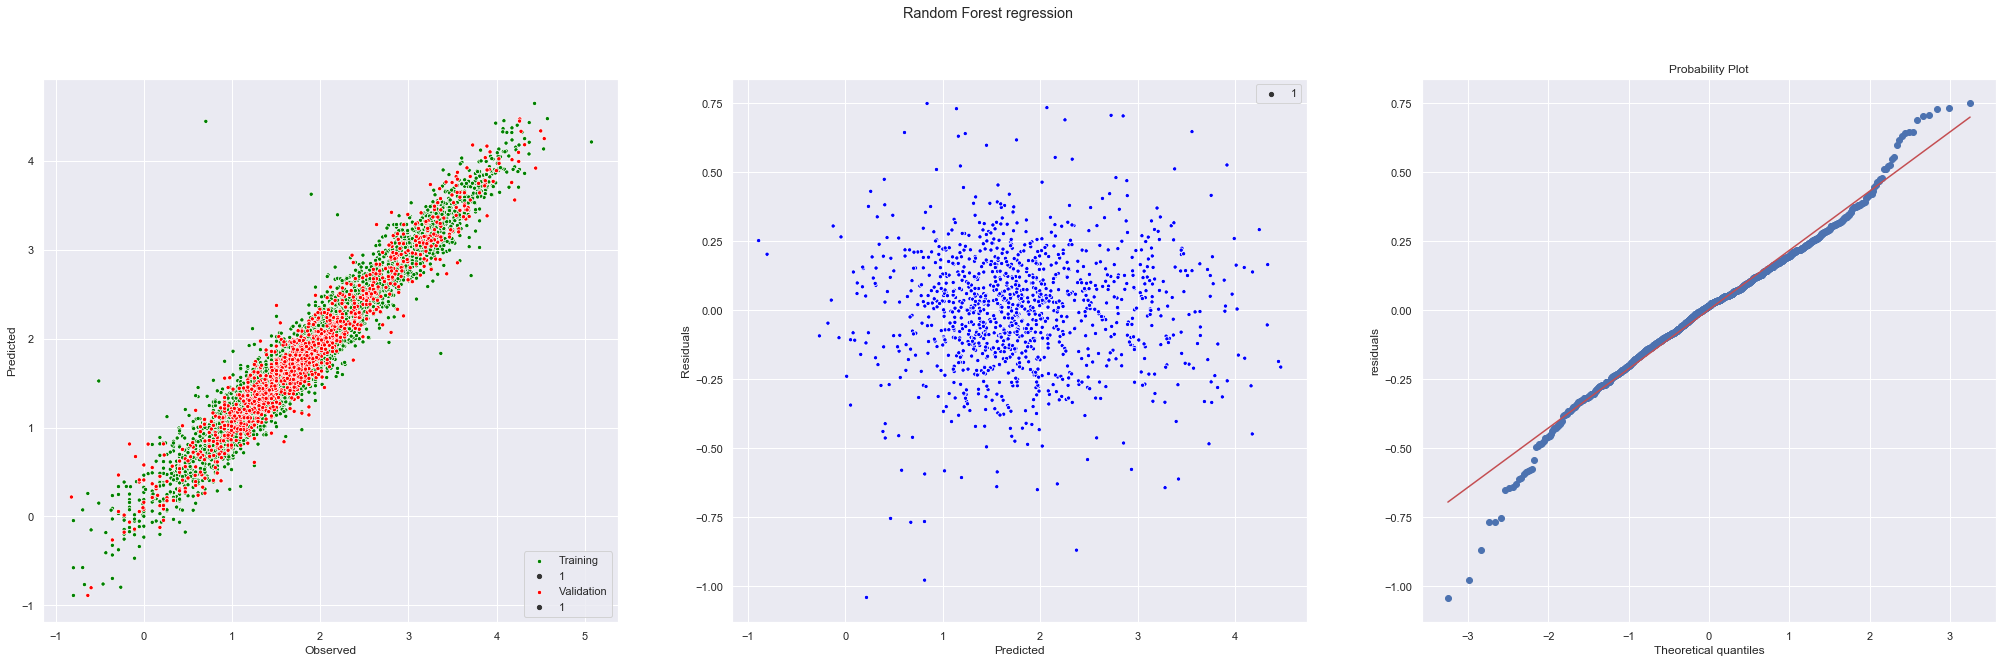

In [30]:
from sklearn.metrics import mean_squared_error as score

train_pred_y = regressor.predict(X_train)
test_pred_y = regressor.predict(X_test)


#---- Clipping more than zero

vfunc = np.vectorize(lambda x: max(0,x))
#train_pred_y = vfunc(train_pred_y)
#test_pred_y = vfunc(test_pred_y)


#--- Printing the score for validation sets

print(f"\n\n Linear Regression R-Squared: Training = {round(r2_score(train_pred_y, np.log(y_train)),3)}, Validation = {round(r2_score(test_pred_y, np.log(y_test)),3)}")
print(f"\n Linear Regression SCORE: Training = {round(1 - score(train_pred_y, np.log(y_train)),3)}, Validation = {1 - round(score(test_pred_y, np.log(y_test)),3)}")




#          *********** Plot validation and Residuals  ********
plt.figure(figsize= (35,10))
plt.suptitle('Random Forest regression')
ax1 = plt.subplot(131)
#plt.xscale('log')
#plt.yscale('log')
sns.scatterplot(np.log(y_train),train_pred_y,size=1, color = 'green',label = 'Training',ax=ax1);
sns.scatterplot(np.log(y_test),test_pred_y,size=1,color = 'red', label = 'Validation',ax=ax1);
#plt.axis([1,120,1,120]);
plt.xlabel('Observed');
plt.ylabel('Predicted');
plt.legend(loc = 4);


ax2 = plt.subplot(132)
sns.scatterplot(test_pred_y,(np.log(y_test)-test_pred_y) ,size=1, color = 'blue',ax=ax2)
plt.xlabel('Predicted');
plt.ylabel('Residuals');

ax3 = plt.subplot(133)
stats.probplot(np.log(y_test)-test_pred_y, plot=ax3)
plt.ylabel('residuals');

In [31]:
regressor.best_params_

{'Model_fit__estimator': Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
    normalize=False, random_state=None, solver='auto', tol=0.001),
 'Model_fit__estimator__alpha': 0.5,
 'feature_selection__estimator': Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
    normalize=False, random_state=None, solver='auto', tol=0.001),
 'feature_selection__n_features': 20,
 'poly_transform__degree': 2}

### Support Vertors machines

In [19]:
TransformPipeline_svc = Pipeline([
    ('features',DFFeatureUnion([
        ('numerics', Pipeline([
            ('extract',ColumnExtractor(con_cols)),
            ('log', Log1pTransformer()),
            ('col_Interact',DFadd_ColInteraction('Kilometers_Driven','Mileage')),
            ('col_drop',DFdrop_Cols(cols=['Kilometers_Driven','Mileage','Engine']))])),
        ('nominal_OneHot',Pipeline([
            ('extract',ColumnExtractor(One_hot_cols)),
            ('dummy',DummyTransformer()),
            ('col_drop',DFdrop_Cols(cols=['Transmission=Manual']))])),
        ('nominal_Target', Pipeline([
            ('extract',ColumnExtractor(Tar_cols)),
            ('Mean_Enc',TargetEncoder())])),
        ('Year',Pipeline([
            ('extract',ColumnExtractor(Year)),
            ('Shift',ShiftTranformer(par=2019))])),
        ('Seats',Pipeline([
            ('extract',ColumnExtractor(Seats))]))
            
        ])),
    ('feature_selection',DFRecursiveFeatureSelector(RandomForestRegressor(n_estimators=100),n_features=20)),
    ('scale', DFRobustScaler()),
    ('Model_fit',DF_Model(estimator = SVR()))
    ])

In [20]:
def score(y,pred):
    return 1-(mean_squared_log_error(y,pred))**0.5

pipe_params= {'Model_fit__estimator__kernel':['linear', 'rbf', 'poly'],
              'Model_fit__estimator__gamma':[0.1,1,10,100],
              'Model_fit__estimator__C':[0.1,1,10,100],
              'Model_fit__estimator__degree':[2],
              'feature_selection__estimator':[RandomForestRegressor()],
              'feature_selection__estimator__n_estimators':[10],
              'feature_selection__n_features':[10,15,20]}



In [21]:
SV_Regressor = GridSearchCV(TransformPipeline_svc,
                         param_grid=pipe_params,
                        scoring = 'neg_mean_squared_error',
                            n_jobs = 1,
                        cv = 5,verbose=50)
SV_Regressor.fit(X_train,y=np.log(y_train))

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] Model_fit__estimator__C=0.1, Model_fit__estimator__degree=2, Model_fit__estimator__gamma=0.1, Model_fit__estimator__kernel=linear, feature_selection__estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False), feature_selection__estimator__n_estimators=10, feature_selection__n_features=10 
[CV]  Model_fit__estimator__C=0.1, Model_fit__estimator__degree=2, Model_fit__estimator__gamma=0.1, Model_fit__e

[CV]  Model_fit__estimator__C=0.1, Model_fit__estimator__degree=2, Model_fit__estimator__gamma=0.1, Model_fit__estimator__kernel=linear, feature_selection__estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False), feature_selection__estimator__n_estimators=10, feature_selection__n_features=15, score=-0.051, total=   0.5s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    3.1s remaining:    0.0s
[CV] Model_fit__estimator__C=0.1, Model_fit__estimator__degree=2, Model_fit__estimator__gamma=0.1, Model_fit__estimator__kernel=linear, feature_sel

[CV]  Model_fit__estimator__C=0.1, Model_fit__estimator__degree=2, Model_fit__estimator__gamma=0.1, Model_fit__estimator__kernel=linear, feature_selection__estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False), feature_selection__estimator__n_estimators=10, feature_selection__n_features=20, score=-0.058, total=   0.5s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    6.2s remaining:    0.0s
[CV] Model_fit__estimator__C=0.1, Model_fit__estimator__degree=2, Model_fit__estimator__gamma=0.1, Model_fit__estimator__kernel=linear, feature_sel

[CV]  Model_fit__estimator__C=0.1, Model_fit__estimator__degree=2, Model_fit__estimator__gamma=0.1, Model_fit__estimator__kernel=rbf, feature_selection__estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False), feature_selection__estimator__n_estimators=10, feature_selection__n_features=10, score=-0.055, total=   0.6s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:    9.4s remaining:    0.0s
[CV] Model_fit__estimator__C=0.1, Model_fit__estimator__degree=2, Model_fit__estimator__gamma=0.1, Model_fit__estimator__kernel=rbf, feature_selection

[CV]  Model_fit__estimator__C=0.1, Model_fit__estimator__degree=2, Model_fit__estimator__gamma=0.1, Model_fit__estimator__kernel=rbf, feature_selection__estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False), feature_selection__estimator__n_estimators=10, feature_selection__n_features=15, score=-0.070, total=   0.7s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:   13.3s remaining:    0.0s
[CV] Model_fit__estimator__C=0.1, Model_fit__estimator__degree=2, Model_fit__estimator__gamma=0.1, Model_fit__estimator__kernel=rbf, feature_selection

[CV]  Model_fit__estimator__C=0.1, Model_fit__estimator__degree=2, Model_fit__estimator__gamma=0.1, Model_fit__estimator__kernel=rbf, feature_selection__estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False), feature_selection__estimator__n_estimators=10, feature_selection__n_features=20, score=-0.055, total=   0.6s
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   16.8s remaining:    0.0s
[CV] Model_fit__estimator__C=0.1, Model_fit__estimator__degree=2, Model_fit__estimator__gamma=0.1, Model_fit__estimator__kernel=poly, feature_selectio

[CV]  Model_fit__estimator__C=0.1, Model_fit__estimator__degree=2, Model_fit__estimator__gamma=0.1, Model_fit__estimator__kernel=poly, feature_selection__estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False), feature_selection__estimator__n_estimators=10, feature_selection__n_features=15, score=-0.105, total=   0.5s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:   19.9s remaining:    0.0s
[CV] Model_fit__estimator__C=0.1, Model_fit__estimator__degree=2, Model_fit__estimator__gamma=0.1, Model_fit__estimator__kernel=poly, feature_selecti

[CV]  Model_fit__estimator__C=0.1, Model_fit__estimator__degree=2, Model_fit__estimator__gamma=0.1, Model_fit__estimator__kernel=poly, feature_selection__estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False), feature_selection__estimator__n_estimators=10, feature_selection__n_features=20, score=-0.133, total=   0.4s
[Parallel(n_jobs=1)]: Done  42 out of  42 | elapsed:   22.9s remaining:    0.0s
[CV] Model_fit__estimator__C=0.1, Model_fit__estimator__degree=2, Model_fit__estimator__gamma=0.1, Model_fit__estimator__kernel=poly, feature_selecti

[CV]  Model_fit__estimator__C=0.1, Model_fit__estimator__degree=2, Model_fit__estimator__gamma=1, Model_fit__estimator__kernel=linear, feature_selection__estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False), feature_selection__estimator__n_estimators=10, feature_selection__n_features=10, score=-0.054, total=   0.5s
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:   25.8s remaining:    0.0s
[CV] Model_fit__estimator__C=0.1, Model_fit__estimator__degree=2, Model_fit__estimator__gamma=1, Model_fit__estimator__kernel=linear, feature_selecti

[CV]  Model_fit__estimator__C=0.1, Model_fit__estimator__degree=2, Model_fit__estimator__gamma=1, Model_fit__estimator__kernel=linear, feature_selection__estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False), feature_selection__estimator__n_estimators=10, feature_selection__n_features=15, score=-0.072, total=   0.5s
[CV] Model_fit__estimator__C=0.1, Model_fit__estimator__degree=2, Model_fit__estimator__gamma=1, Model_fit__estimator__kernel=linear, feature_selection__estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='ms

[CV]  Model_fit__estimator__C=0.1, Model_fit__estimator__degree=2, Model_fit__estimator__gamma=1, Model_fit__estimator__kernel=linear, feature_selection__estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False), feature_selection__estimator__n_estimators=10, feature_selection__n_features=20, score=-0.058, total=   0.5s
[CV] Model_fit__estimator__C=0.1, Model_fit__estimator__degree=2, Model_fit__estimator__gamma=1, Model_fit__estimator__kernel=rbf, feature_selection__estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',

[CV]  Model_fit__estimator__C=0.1, Model_fit__estimator__degree=2, Model_fit__estimator__gamma=1, Model_fit__estimator__kernel=rbf, feature_selection__estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False), feature_selection__estimator__n_estimators=10, feature_selection__n_features=15, score=-0.125, total=   0.7s
[CV] Model_fit__estimator__C=0.1, Model_fit__estimator__degree=2, Model_fit__estimator__gamma=1, Model_fit__estimator__kernel=rbf, feature_selection__estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
  

[CV]  Model_fit__estimator__C=0.1, Model_fit__estimator__degree=2, Model_fit__estimator__gamma=1, Model_fit__estimator__kernel=rbf, feature_selection__estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False), feature_selection__estimator__n_estimators=10, feature_selection__n_features=20, score=-0.142, total=   0.6s
[CV] Model_fit__estimator__C=0.1, Model_fit__estimator__degree=2, Model_fit__estimator__gamma=1, Model_fit__estimator__kernel=rbf, feature_selection__estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
  

[CV]  Model_fit__estimator__C=0.1, Model_fit__estimator__degree=2, Model_fit__estimator__gamma=1, Model_fit__estimator__kernel=poly, feature_selection__estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False), feature_selection__estimator__n_estimators=10, feature_selection__n_features=10, score=-0.110, total=   0.9s
[CV] Model_fit__estimator__C=0.1, Model_fit__estimator__degree=2, Model_fit__estimator__gamma=1, Model_fit__estimator__kernel=poly, feature_selection__estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',


[CV]  Model_fit__estimator__C=0.1, Model_fit__estimator__degree=2, Model_fit__estimator__gamma=1, Model_fit__estimator__kernel=poly, feature_selection__estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False), feature_selection__estimator__n_estimators=10, feature_selection__n_features=15, score=-0.142, total=   1.0s
[CV] Model_fit__estimator__C=0.1, Model_fit__estimator__degree=2, Model_fit__estimator__gamma=1, Model_fit__estimator__kernel=poly, feature_selection__estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',


[CV]  Model_fit__estimator__C=0.1, Model_fit__estimator__degree=2, Model_fit__estimator__gamma=1, Model_fit__estimator__kernel=poly, feature_selection__estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False), feature_selection__estimator__n_estimators=10, feature_selection__n_features=20, score=-0.095, total=   0.9s
[CV] Model_fit__estimator__C=0.1, Model_fit__estimator__degree=2, Model_fit__estimator__gamma=10, Model_fit__estimator__kernel=linear, feature_selection__estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse

[CV]  Model_fit__estimator__C=0.1, Model_fit__estimator__degree=2, Model_fit__estimator__gamma=10, Model_fit__estimator__kernel=linear, feature_selection__estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False), feature_selection__estimator__n_estimators=10, feature_selection__n_features=15, score=-0.051, total=   0.5s
[CV] Model_fit__estimator__C=0.1, Model_fit__estimator__degree=2, Model_fit__estimator__gamma=10, Model_fit__estimator__kernel=linear, feature_selection__estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='

[CV]  Model_fit__estimator__C=0.1, Model_fit__estimator__degree=2, Model_fit__estimator__gamma=10, Model_fit__estimator__kernel=linear, feature_selection__estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False), feature_selection__estimator__n_estimators=10, feature_selection__n_features=20, score=-0.058, total=   0.4s
[CV] Model_fit__estimator__C=0.1, Model_fit__estimator__degree=2, Model_fit__estimator__gamma=10, Model_fit__estimator__kernel=linear, feature_selection__estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='

[CV]  Model_fit__estimator__C=0.1, Model_fit__estimator__degree=2, Model_fit__estimator__gamma=10, Model_fit__estimator__kernel=rbf, feature_selection__estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False), feature_selection__estimator__n_estimators=10, feature_selection__n_features=10, score=-0.647, total=   0.7s
[CV] Model_fit__estimator__C=0.1, Model_fit__estimator__degree=2, Model_fit__estimator__gamma=10, Model_fit__estimator__kernel=rbf, feature_selection__estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',


[CV]  Model_fit__estimator__C=0.1, Model_fit__estimator__degree=2, Model_fit__estimator__gamma=10, Model_fit__estimator__kernel=rbf, feature_selection__estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False), feature_selection__estimator__n_estimators=10, feature_selection__n_features=15, score=-0.639, total=   0.8s
[CV] Model_fit__estimator__C=0.1, Model_fit__estimator__degree=2, Model_fit__estimator__gamma=10, Model_fit__estimator__kernel=rbf, feature_selection__estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',


[CV]  Model_fit__estimator__C=0.1, Model_fit__estimator__degree=2, Model_fit__estimator__gamma=10, Model_fit__estimator__kernel=rbf, feature_selection__estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False), feature_selection__estimator__n_estimators=10, feature_selection__n_features=20, score=-0.692, total=   0.7s
[CV] Model_fit__estimator__C=0.1, Model_fit__estimator__degree=2, Model_fit__estimator__gamma=10, Model_fit__estimator__kernel=poly, feature_selection__estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',

KeyboardInterrupt: 

### K - Nearest neighbours 

In [ ]:
TransformPipeline_knn = Pipeline([
    ('features',DFFeatureUnion([
        ('numerics', Pipeline([
            ('extract',ColumnExtractor(con_cols)),
            ('log', Log1pTransformer()),
            ('col_Interact',DFadd_ColInteraction('Kilometers_Driven','Mileage')),
            ('col_drop',DFdrop_Cols(cols=['Kilometers_Driven','Mileage','Engine']))])),
        ('nominal_OneHot',Pipeline([
            ('extract',ColumnExtractor(One_hot_cols)),
            ('dummy',DummyTransformer()),
            ('col_drop',DFdrop_Cols(cols=['Transmission=Manual']))])),
        ('nominal_Target', Pipeline([
            ('extract',ColumnExtractor(Tar_cols)),
            ('Mean_Enc',TargetEncoder())])),
        ('Year',Pipeline([
            ('extract',ColumnExtractor(Year)),
            ('Shift',ShiftTranformer(par=2019))])),
        ('Seats',Pipeline([
            ('extract',ColumnExtractor(Seats))]))
            
        ])),
    ('feature_selection',DFRecursiveFeatureSelector(RandomForestRegressor(n_estimators=100),n_features=20)),
    ('scale', DFRobustScaler()),
    ('Model_fit',DF_Model(estimator = SVR()))
    ])

### Random Forest 

In [41]:
TransformPipeline_RV = Pipeline([
    ('features',DFFeatureUnion([
        ('numerics', Pipeline([
            ('extract',ColumnExtractor(con_cols)),
            ('log', Log1pTransformer()),
            ('col_Interact',DFadd_ColInteraction('Kilometers_Driven','Mileage')),
            #('col_drop',DFdrop_Cols(cols=['Kilometers_Driven','Mileage','Engine']))
        ])),
        ('nominal_OneHot',Pipeline([
            ('extract',ColumnExtractor(One_hot_cols)),
            ('dummy',DummyTransformer())])),
        ('nominal_Target', Pipeline([
            ('extract',ColumnExtractor(Tar_cols)),
            ('Mean_Enc',TargetEncoder())])),
        ('Year',Pipeline([
            ('extract',ColumnExtractor(Year)),
            ('Shift',ShiftTranformer(par=2019))])),
        ('Seats',Pipeline([
            ('extract',ColumnExtractor(Seats))]))
            
        ])),
    ('Model_fit',DF_Model(estimator = RandomForestRegressor()))])

In [42]:
pipe_params= {'Model_fit__estimator__n_estimators':[20,40,80,100,120,150],
              'Model_fit__estimator__min_samples_split':[20,40,60],
              'Model_fit__estimator__max_depth':[4,6,8],
              'Model_fit__estimator__min_samples_leaf':[20,40,60],
              }
RV_Regressor = GridSearchCV(TransformPipeline_RV,
                         param_grid=pipe_params,
                        scoring = 'neg_mean_squared_error',
                            n_jobs = 6,
                        cv = 5,verbose=50)
RV_Regressor.fit(X_train,y=np.log(y_train))

Fitting 5 folds for each of 162 candidates, totalling 810 fits
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=6)]: Done   2 tasks      | elapsed:    1.0s
[Parallel(n_jobs=6)]: Done   3 tasks      | elapsed:    1.1s
[Parallel(n_jobs=6)]: Done   4 tasks      | elapsed:    1.1s
[Parallel(n_jobs=6)]: Done   5 tasks      | elapsed:    1.2s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:    1.3s
[Parallel(n_jobs=6)]: Done   7 tasks      | elapsed:    1.4s
[Parallel(n_jobs=6)]: Done   8 tasks      | elapsed:    1.4s
[Parallel(n_jobs=6)]: Done   9 tasks      | elapsed:    1.5s
[Parallel(n_jobs=6)]: Done  10 tasks      | elapsed:    1.5s
[Parallel(n_jobs=6)]: Done  11 tasks      | elapsed:    1.9s
[Parallel(n_jobs=6)]: Done  12 tasks      | elapsed:    2.0s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:    2.0s
[Parallel(n_jobs=6)]: Done  14 tasks      | elapsed:    2.1s
[Paralle

[Parallel(n_jobs=6)]: Done 135 tasks      | elapsed:   15.5s
[Parallel(n_jobs=6)]: Done 136 tasks      | elapsed:   15.5s
[Parallel(n_jobs=6)]: Done 137 tasks      | elapsed:   15.9s
[Parallel(n_jobs=6)]: Done 138 tasks      | elapsed:   15.9s
[Parallel(n_jobs=6)]: Done 139 tasks      | elapsed:   16.0s
[Parallel(n_jobs=6)]: Done 140 tasks      | elapsed:   16.0s
[Parallel(n_jobs=6)]: Done 141 tasks      | elapsed:   16.3s
[Parallel(n_jobs=6)]: Done 142 tasks      | elapsed:   16.4s
[Parallel(n_jobs=6)]: Done 143 tasks      | elapsed:   16.7s
[Parallel(n_jobs=6)]: Done 144 tasks      | elapsed:   16.7s
[Parallel(n_jobs=6)]: Done 145 tasks      | elapsed:   16.9s
[Parallel(n_jobs=6)]: Done 146 tasks      | elapsed:   17.0s
[Parallel(n_jobs=6)]: Done 147 tasks      | elapsed:   17.2s
[Parallel(n_jobs=6)]: Done 148 tasks      | elapsed:   17.3s
[Parallel(n_jobs=6)]: Done 149 tasks      | elapsed:   17.3s
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:   17.4s
[Parallel(n_jobs=6)]: Do

[Parallel(n_jobs=6)]: Done 272 tasks      | elapsed:   31.1s
[Parallel(n_jobs=6)]: Done 273 tasks      | elapsed:   31.1s
[Parallel(n_jobs=6)]: Done 274 tasks      | elapsed:   31.2s
[Parallel(n_jobs=6)]: Done 275 tasks      | elapsed:   31.2s
[Parallel(n_jobs=6)]: Done 276 tasks      | elapsed:   31.4s
[Parallel(n_jobs=6)]: Done 277 tasks      | elapsed:   31.5s
[Parallel(n_jobs=6)]: Done 278 tasks      | elapsed:   31.6s
[Parallel(n_jobs=6)]: Done 279 tasks      | elapsed:   31.6s
[Parallel(n_jobs=6)]: Done 280 tasks      | elapsed:   31.6s
[Parallel(n_jobs=6)]: Done 281 tasks      | elapsed:   32.1s
[Parallel(n_jobs=6)]: Done 282 tasks      | elapsed:   32.2s
[Parallel(n_jobs=6)]: Done 283 tasks      | elapsed:   32.3s
[Parallel(n_jobs=6)]: Done 284 tasks      | elapsed:   32.3s
[Parallel(n_jobs=6)]: Done 285 tasks      | elapsed:   32.3s
[Parallel(n_jobs=6)]: Done 286 tasks      | elapsed:   32.5s
[Parallel(n_jobs=6)]: Done 287 tasks      | elapsed:   33.0s
[Parallel(n_jobs=6)]: Do

[Parallel(n_jobs=6)]: Done 407 tasks      | elapsed:   49.2s
[Parallel(n_jobs=6)]: Done 408 tasks      | elapsed:   49.3s
[Parallel(n_jobs=6)]: Done 409 tasks      | elapsed:   49.3s
[Parallel(n_jobs=6)]: Done 410 tasks      | elapsed:   49.5s
[Parallel(n_jobs=6)]: Done 411 tasks      | elapsed:   49.7s
[Parallel(n_jobs=6)]: Done 412 tasks      | elapsed:   50.1s
[Parallel(n_jobs=6)]: Done 413 tasks      | elapsed:   50.3s
[Parallel(n_jobs=6)]: Done 414 tasks      | elapsed:   50.4s
[Parallel(n_jobs=6)]: Done 415 tasks      | elapsed:   50.5s
[Parallel(n_jobs=6)]: Done 416 tasks      | elapsed:   50.7s
[Parallel(n_jobs=6)]: Done 417 tasks      | elapsed:   50.8s
[Parallel(n_jobs=6)]: Done 418 tasks      | elapsed:   51.0s
[Parallel(n_jobs=6)]: Done 419 tasks      | elapsed:   51.0s
[Parallel(n_jobs=6)]: Done 420 tasks      | elapsed:   51.1s
[Parallel(n_jobs=6)]: Done 421 tasks      | elapsed:   51.3s
[Parallel(n_jobs=6)]: Done 422 tasks      | elapsed:   51.4s
[Parallel(n_jobs=6)]: Do

[Parallel(n_jobs=6)]: Done 546 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done 547 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done 548 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done 549 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done 550 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done 551 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done 552 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done 553 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done 554 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done 555 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done 556 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done 557 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done 558 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done 559 tasks      | elapsed:  1.2min
[Parallel(n_jobs=6)]: Done 560 tasks      | elapsed:  1.2min
[Parallel(n_jobs=6)]: Done 561 tasks      | elapsed:  1.2min
[Parallel(n_jobs=6)]: Do

[Parallel(n_jobs=6)]: Done 681 tasks      | elapsed:  1.5min
[Parallel(n_jobs=6)]: Done 682 tasks      | elapsed:  1.5min
[Parallel(n_jobs=6)]: Done 683 tasks      | elapsed:  1.5min
[Parallel(n_jobs=6)]: Done 684 tasks      | elapsed:  1.5min
[Parallel(n_jobs=6)]: Done 685 tasks      | elapsed:  1.5min
[Parallel(n_jobs=6)]: Done 686 tasks      | elapsed:  1.5min
[Parallel(n_jobs=6)]: Done 687 tasks      | elapsed:  1.5min
[Parallel(n_jobs=6)]: Done 688 tasks      | elapsed:  1.5min
[Parallel(n_jobs=6)]: Done 689 tasks      | elapsed:  1.5min
[Parallel(n_jobs=6)]: Done 690 tasks      | elapsed:  1.5min
[Parallel(n_jobs=6)]: Done 691 tasks      | elapsed:  1.5min
[Parallel(n_jobs=6)]: Done 692 tasks      | elapsed:  1.5min
[Parallel(n_jobs=6)]: Done 693 tasks      | elapsed:  1.5min
[Parallel(n_jobs=6)]: Done 694 tasks      | elapsed:  1.5min
[Parallel(n_jobs=6)]: Done 695 tasks      | elapsed:  1.5min
[Parallel(n_jobs=6)]: Done 696 tasks      | elapsed:  1.5min
[Parallel(n_jobs=6)]: Do

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('features', DFFeatureUnion(transformer_list=[('numerics', Pipeline(memory=None,
     steps=[('extract', ColumnExtractor(cols=['Kilometers_Driven', 'Mileage', 'Engine', 'Power'])), ('log', Log1pTransformer()), ('col_Interact', DFadd_ColInteraction(col1='Kilometers_Driven', col2='Mileage'))]))...='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)))]),
       fit_params=None, iid='warn', n_jobs=6,
       param_grid={'Model_fit__estimator__n_estimators': [20, 40, 80, 100, 120, 150], 'Model_fit__estimator__min_samples_split': [20, 40, 60], 'Model_fit__estimator__max_depth': [4, 6, 8], 'Model_fit__estimator__min_samples_leaf': [20, 40, 60]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=50)

In [43]:
RV_Regressor.best_params_

{'Model_fit__estimator__max_depth': 8,
 'Model_fit__estimator__min_samples_leaf': 20,
 'Model_fit__estimator__min_samples_split': 40,
 'Model_fit__estimator__n_estimators': 150}



 Linear Regression R-Squared: Training = 0.94, Validation = 0.927

 Linear Regression SCORE: Training = 0.959, Validation = 0.951


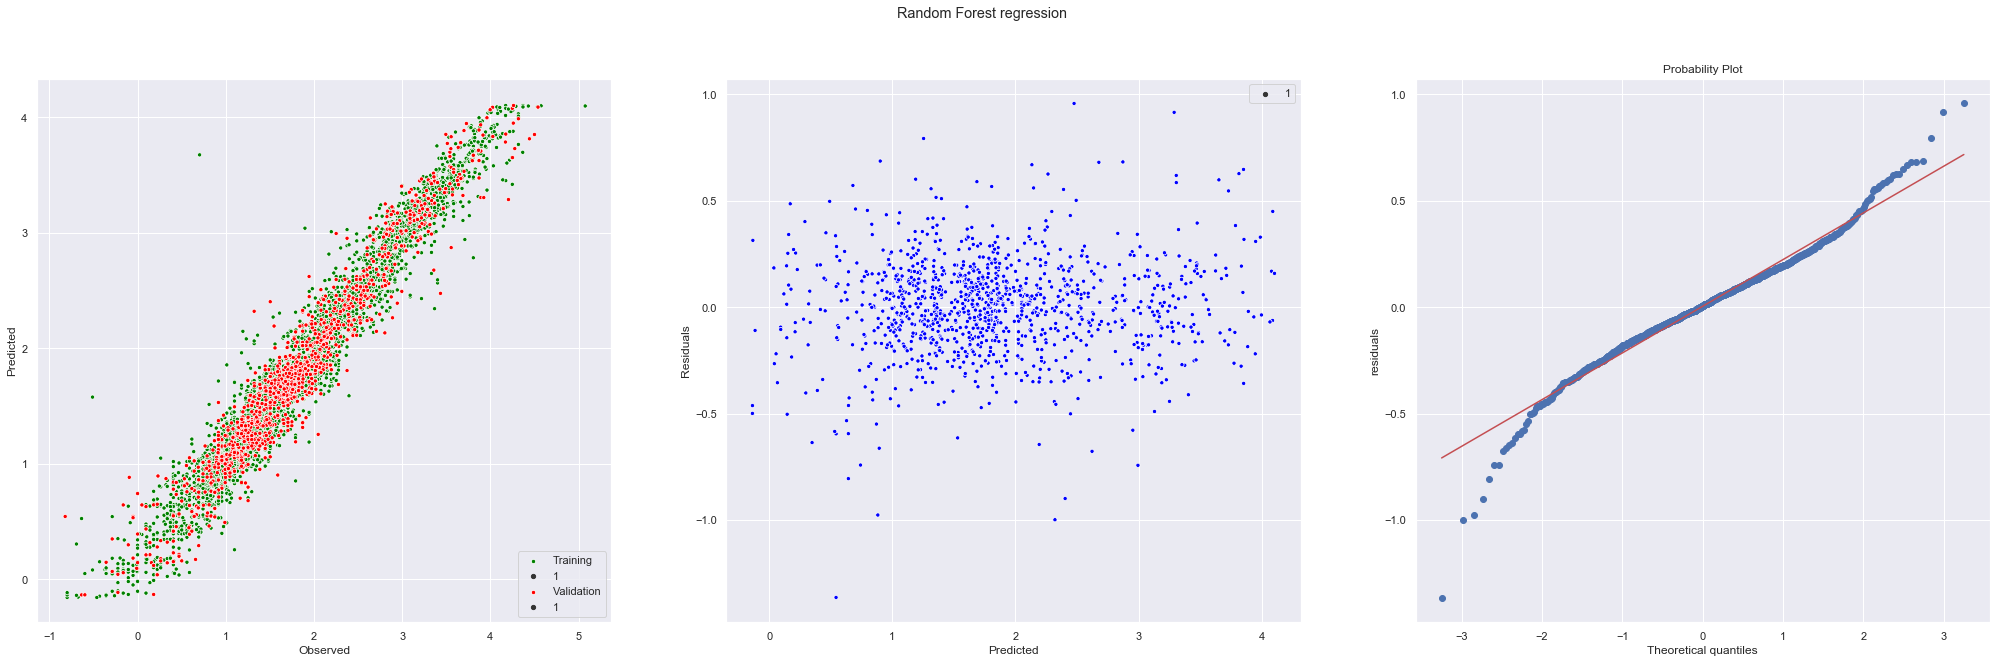

In [44]:
from sklearn.metrics import mean_squared_error as score

train_pred_y = RV_Regressor.predict(X_train)
test_pred_y = RV_Regressor.predict(X_test)


#---- Clipping more than zero

vfunc = np.vectorize(lambda x: max(0,x))
#train_pred_y = vfunc(train_pred_y)
#test_pred_y = vfunc(test_pred_y)


#--- Printing the score for validation sets

print(f"\n\n Linear Regression R-Squared: Training = {round(r2_score(train_pred_y, np.log(y_train)),3)}, Validation = {round(r2_score(test_pred_y, np.log(y_test)),3)}")
print(f"\n Linear Regression SCORE: Training = {round(1 - score(train_pred_y, np.log(y_train)),3)}, Validation = {1 - round(score(test_pred_y, np.log(y_test)),3)}")




#          *********** Plot validation and Residuals  ********
plt.figure(figsize= (35,10))
plt.suptitle('Random Forest regression')
ax1 = plt.subplot(131)
#plt.xscale('log')
#plt.yscale('log')
sns.scatterplot(np.log(y_train),train_pred_y,size=1, color = 'green',label = 'Training',ax=ax1);
sns.scatterplot(np.log(y_test),test_pred_y,size=1,color = 'red', label = 'Validation',ax=ax1);
#plt.axis([1,120,1,120]);
plt.xlabel('Observed');
plt.ylabel('Predicted');
plt.legend(loc = 4);


ax2 = plt.subplot(132)
sns.scatterplot(test_pred_y,(np.log(y_test)-test_pred_y) ,size=1, color = 'blue',ax=ax2)
plt.xlabel('Predicted');
plt.ylabel('Residuals');

ax3 = plt.subplot(133)
stats.probplot(np.log(y_test)-test_pred_y, plot=ax3)
plt.ylabel('residuals');

In [128]:
RV_Regressor.best_params_

{'Model_fit__estimator__max_depth': 8,
 'Model_fit__estimator__min_samples_leaf': 20,
 'Model_fit__estimator__min_samples_split': 40,
 'Model_fit__estimator__n_estimators': 80}

### GBM regressor

In [45]:
TransformPipeline_GBM = Pipeline([
    ('features',DFFeatureUnion([
        ('numerics', Pipeline([
            ('extract',ColumnExtractor(con_cols)),
            ('log', Log1pTransformer()),
            ('col_Interact',DFadd_ColInteraction('Kilometers_Driven','Mileage')),
        #    ('col_drop',DFdrop_Cols(cols=['Kilometers_Driven','Mileage','Engine']))
        ])),
        ('nominal_OneHot',Pipeline([
            ('extract',ColumnExtractor(One_hot_cols)),
            ('dummy',DummyTransformer())])),
        ('nominal_Target', Pipeline([
            ('extract',ColumnExtractor(Tar_cols)),
            ('Mean_Enc',TargetEncoder())])),
        ('Year',Pipeline([
            ('extract',ColumnExtractor(Year)),
            ('Shift',ShiftTranformer(par=2019))])),
        ('Seats',Pipeline([
            ('extract',ColumnExtractor(Seats))]))
            
        ])),
    ('feature_selection',DFRecursiveFeatureSelector(RandomForestRegressor(n_estimators=50),n_features=20)),
    ('Model_fit',DF_Model(estimator = GradientBoostingRegressor()))])

In [46]:
pipe_params= {'Model_fit__estimator__learning_rate':[0.2,0.4,0.6,0.8],
              'Model_fit__estimator__n_estimators':[20,40,80,100,120],
              'Model_fit__estimator__min_samples_split':[20,40,60],
              'Model_fit__estimator__max_depth':[3,4,6,8,12],
              'Model_fit__estimator__min_samples_leaf':[20,40,60],
              'feature_selection__n_features':[10,15,20]
              }

GBM_Regressor = GridSearchCV(TransformPipeline_GBM,
                         param_grid=pipe_params,
                        scoring = 'r2',
                            n_jobs = 5,
                        cv = 3,verbose=50)
GBM_Regressor.fit(X_train,y=np.log(y_train))

Fitting 3 folds for each of 2700 candidates, totalling 8100 fits
[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=5)]: Done   2 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done   3 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done   4 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=5)]: Done   6 tasks      | elapsed:    2.6s
[Parallel(n_jobs=5)]: Done   7 tasks      | elapsed:    2.7s
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    2.7s
[Parallel(n_jobs=5)]: Done   9 tasks      | elapsed:    3.1s
[Parallel(n_jobs=5)]: Done  10 tasks      | elapsed:    3.5s
[Parallel(n_jobs=5)]: Done  11 tasks      | elapsed:    4.0s
[Parallel(n_jobs=5)]: Done  12 tasks      | elapsed:    4.1s
[Parallel(n_jobs=5)]: Done  13 tasks      | elapsed:    4.2s
[Parallel(n_jobs=5)]: Done  14 tasks      | elapsed:    4.7s
[Paral

[Parallel(n_jobs=5)]: Done 135 tasks      | elapsed:   40.0s
[Parallel(n_jobs=5)]: Done 136 tasks      | elapsed:   40.5s
[Parallel(n_jobs=5)]: Done 137 tasks      | elapsed:   40.8s
[Parallel(n_jobs=5)]: Done 138 tasks      | elapsed:   41.0s
[Parallel(n_jobs=5)]: Done 139 tasks      | elapsed:   41.0s
[Parallel(n_jobs=5)]: Done 140 tasks      | elapsed:   41.5s
[Parallel(n_jobs=5)]: Done 141 tasks      | elapsed:   41.8s
[Parallel(n_jobs=5)]: Done 142 tasks      | elapsed:   42.0s
[Parallel(n_jobs=5)]: Done 143 tasks      | elapsed:   42.0s
[Parallel(n_jobs=5)]: Done 144 tasks      | elapsed:   42.1s
[Parallel(n_jobs=5)]: Done 145 tasks      | elapsed:   43.1s
[Parallel(n_jobs=5)]: Done 146 tasks      | elapsed:   43.2s
[Parallel(n_jobs=5)]: Done 147 tasks      | elapsed:   43.4s
[Parallel(n_jobs=5)]: Done 148 tasks      | elapsed:   43.6s
[Parallel(n_jobs=5)]: Done 149 tasks      | elapsed:   43.7s
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:   44.1s
[Parallel(n_jobs=5)]: Do

[Parallel(n_jobs=5)]: Done 271 tasks      | elapsed:  1.3min
[Parallel(n_jobs=5)]: Done 272 tasks      | elapsed:  1.3min
[Parallel(n_jobs=5)]: Done 273 tasks      | elapsed:  1.3min
[Parallel(n_jobs=5)]: Done 274 tasks      | elapsed:  1.3min
[Parallel(n_jobs=5)]: Done 275 tasks      | elapsed:  1.3min
[Parallel(n_jobs=5)]: Done 276 tasks      | elapsed:  1.3min
[Parallel(n_jobs=5)]: Done 277 tasks      | elapsed:  1.3min
[Parallel(n_jobs=5)]: Done 278 tasks      | elapsed:  1.4min
[Parallel(n_jobs=5)]: Done 279 tasks      | elapsed:  1.4min
[Parallel(n_jobs=5)]: Done 280 tasks      | elapsed:  1.4min
[Parallel(n_jobs=5)]: Done 281 tasks      | elapsed:  1.4min
[Parallel(n_jobs=5)]: Done 282 tasks      | elapsed:  1.4min
[Parallel(n_jobs=5)]: Done 283 tasks      | elapsed:  1.4min
[Parallel(n_jobs=5)]: Done 284 tasks      | elapsed:  1.4min
[Parallel(n_jobs=5)]: Done 285 tasks      | elapsed:  1.4min
[Parallel(n_jobs=5)]: Done 286 tasks      | elapsed:  1.4min
[Parallel(n_jobs=5)]: Do

[Parallel(n_jobs=5)]: Done 406 tasks      | elapsed:  2.0min
[Parallel(n_jobs=5)]: Done 407 tasks      | elapsed:  2.0min
[Parallel(n_jobs=5)]: Done 408 tasks      | elapsed:  2.0min
[Parallel(n_jobs=5)]: Done 409 tasks      | elapsed:  2.0min
[Parallel(n_jobs=5)]: Done 410 tasks      | elapsed:  2.0min
[Parallel(n_jobs=5)]: Done 411 tasks      | elapsed:  2.0min
[Parallel(n_jobs=5)]: Done 412 tasks      | elapsed:  2.1min
[Parallel(n_jobs=5)]: Done 413 tasks      | elapsed:  2.1min
[Parallel(n_jobs=5)]: Done 414 tasks      | elapsed:  2.1min
[Parallel(n_jobs=5)]: Done 415 tasks      | elapsed:  2.1min
[Parallel(n_jobs=5)]: Done 416 tasks      | elapsed:  2.1min
[Parallel(n_jobs=5)]: Done 417 tasks      | elapsed:  2.1min
[Parallel(n_jobs=5)]: Done 418 tasks      | elapsed:  2.1min
[Parallel(n_jobs=5)]: Done 419 tasks      | elapsed:  2.1min
[Parallel(n_jobs=5)]: Done 420 tasks      | elapsed:  2.1min
[Parallel(n_jobs=5)]: Done 421 tasks      | elapsed:  2.1min
[Parallel(n_jobs=5)]: Do

[Parallel(n_jobs=5)]: Done 541 tasks      | elapsed:  2.7min
[Parallel(n_jobs=5)]: Done 542 tasks      | elapsed:  2.7min
[Parallel(n_jobs=5)]: Done 543 tasks      | elapsed:  2.7min
[Parallel(n_jobs=5)]: Done 544 tasks      | elapsed:  2.7min
[Parallel(n_jobs=5)]: Done 545 tasks      | elapsed:  2.7min
[Parallel(n_jobs=5)]: Done 546 tasks      | elapsed:  2.8min
[Parallel(n_jobs=5)]: Done 547 tasks      | elapsed:  2.8min
[Parallel(n_jobs=5)]: Done 548 tasks      | elapsed:  2.8min
[Parallel(n_jobs=5)]: Done 549 tasks      | elapsed:  2.8min
[Parallel(n_jobs=5)]: Done 550 tasks      | elapsed:  2.8min
[Parallel(n_jobs=5)]: Done 551 tasks      | elapsed:  2.8min
[Parallel(n_jobs=5)]: Done 552 tasks      | elapsed:  2.8min
[Parallel(n_jobs=5)]: Done 553 tasks      | elapsed:  2.8min
[Parallel(n_jobs=5)]: Done 554 tasks      | elapsed:  2.8min
[Parallel(n_jobs=5)]: Done 555 tasks      | elapsed:  2.8min
[Parallel(n_jobs=5)]: Done 556 tasks      | elapsed:  2.8min
[Parallel(n_jobs=5)]: Do

[Parallel(n_jobs=5)]: Done 676 tasks      | elapsed:  3.4min
[Parallel(n_jobs=5)]: Done 677 tasks      | elapsed:  3.4min
[Parallel(n_jobs=5)]: Done 678 tasks      | elapsed:  3.4min
[Parallel(n_jobs=5)]: Done 679 tasks      | elapsed:  3.4min
[Parallel(n_jobs=5)]: Done 680 tasks      | elapsed:  3.4min
[Parallel(n_jobs=5)]: Done 681 tasks      | elapsed:  3.4min
[Parallel(n_jobs=5)]: Done 682 tasks      | elapsed:  3.4min
[Parallel(n_jobs=5)]: Done 683 tasks      | elapsed:  3.4min
[Parallel(n_jobs=5)]: Done 684 tasks      | elapsed:  3.4min
[Parallel(n_jobs=5)]: Done 685 tasks      | elapsed:  3.4min
[Parallel(n_jobs=5)]: Done 686 tasks      | elapsed:  3.5min
[Parallel(n_jobs=5)]: Done 687 tasks      | elapsed:  3.5min
[Parallel(n_jobs=5)]: Done 688 tasks      | elapsed:  3.5min
[Parallel(n_jobs=5)]: Done 689 tasks      | elapsed:  3.5min
[Parallel(n_jobs=5)]: Done 690 tasks      | elapsed:  3.5min
[Parallel(n_jobs=5)]: Done 691 tasks      | elapsed:  3.5min
[Parallel(n_jobs=5)]: Do

[Parallel(n_jobs=5)]: Done 811 tasks      | elapsed:  4.2min
[Parallel(n_jobs=5)]: Done 812 tasks      | elapsed:  4.2min
[Parallel(n_jobs=5)]: Done 813 tasks      | elapsed:  4.2min
[Parallel(n_jobs=5)]: Done 814 tasks      | elapsed:  4.2min
[Parallel(n_jobs=5)]: Done 815 tasks      | elapsed:  4.2min
[Parallel(n_jobs=5)]: Done 816 tasks      | elapsed:  4.2min
[Parallel(n_jobs=5)]: Done 817 tasks      | elapsed:  4.2min
[Parallel(n_jobs=5)]: Done 818 tasks      | elapsed:  4.2min
[Parallel(n_jobs=5)]: Done 819 tasks      | elapsed:  4.2min
[Parallel(n_jobs=5)]: Done 820 tasks      | elapsed:  4.2min
[Parallel(n_jobs=5)]: Done 821 tasks      | elapsed:  4.2min
[Parallel(n_jobs=5)]: Done 822 tasks      | elapsed:  4.2min
[Parallel(n_jobs=5)]: Done 823 tasks      | elapsed:  4.3min
[Parallel(n_jobs=5)]: Done 824 tasks      | elapsed:  4.3min
[Parallel(n_jobs=5)]: Done 825 tasks      | elapsed:  4.3min
[Parallel(n_jobs=5)]: Done 826 tasks      | elapsed:  4.3min
[Parallel(n_jobs=5)]: Do

[Parallel(n_jobs=5)]: Done 947 tasks      | elapsed:  5.0min
[Parallel(n_jobs=5)]: Done 948 tasks      | elapsed:  5.0min
[Parallel(n_jobs=5)]: Done 949 tasks      | elapsed:  5.0min
[Parallel(n_jobs=5)]: Done 950 tasks      | elapsed:  5.0min
[Parallel(n_jobs=5)]: Done 951 tasks      | elapsed:  5.0min
[Parallel(n_jobs=5)]: Done 952 tasks      | elapsed:  5.0min
[Parallel(n_jobs=5)]: Done 953 tasks      | elapsed:  5.0min
[Parallel(n_jobs=5)]: Done 954 tasks      | elapsed:  5.0min
[Parallel(n_jobs=5)]: Done 955 tasks      | elapsed:  5.0min
[Parallel(n_jobs=5)]: Done 956 tasks      | elapsed:  5.0min
[Parallel(n_jobs=5)]: Done 957 tasks      | elapsed:  5.0min
[Parallel(n_jobs=5)]: Done 958 tasks      | elapsed:  5.0min
[Parallel(n_jobs=5)]: Done 959 tasks      | elapsed:  5.0min
[Parallel(n_jobs=5)]: Done 960 tasks      | elapsed:  5.0min
[Parallel(n_jobs=5)]: Done 961 tasks      | elapsed:  5.1min
[Parallel(n_jobs=5)]: Done 962 tasks      | elapsed:  5.1min
[Parallel(n_jobs=5)]: Do

[Parallel(n_jobs=5)]: Done 1080 tasks      | elapsed:  5.7min
[Parallel(n_jobs=5)]: Done 1081 tasks      | elapsed:  5.7min
[Parallel(n_jobs=5)]: Done 1082 tasks      | elapsed:  5.8min
[Parallel(n_jobs=5)]: Done 1083 tasks      | elapsed:  5.8min
[Parallel(n_jobs=5)]: Done 1084 tasks      | elapsed:  5.8min
[Parallel(n_jobs=5)]: Done 1085 tasks      | elapsed:  5.8min
[Parallel(n_jobs=5)]: Done 1086 tasks      | elapsed:  5.8min
[Parallel(n_jobs=5)]: Done 1087 tasks      | elapsed:  5.8min
[Parallel(n_jobs=5)]: Done 1088 tasks      | elapsed:  5.8min
[Parallel(n_jobs=5)]: Done 1089 tasks      | elapsed:  5.8min
[Parallel(n_jobs=5)]: Done 1090 tasks      | elapsed:  5.8min
[Parallel(n_jobs=5)]: Done 1091 tasks      | elapsed:  5.8min
[Parallel(n_jobs=5)]: Done 1092 tasks      | elapsed:  5.8min
[Parallel(n_jobs=5)]: Done 1093 tasks      | elapsed:  5.8min
[Parallel(n_jobs=5)]: Done 1094 tasks      | elapsed:  5.8min
[Parallel(n_jobs=5)]: Done 1095 tasks      | elapsed:  5.8min
[Paralle

[Parallel(n_jobs=5)]: Done 1213 tasks      | elapsed:  6.4min
[Parallel(n_jobs=5)]: Done 1214 tasks      | elapsed:  6.4min
[Parallel(n_jobs=5)]: Done 1215 tasks      | elapsed:  6.4min
[Parallel(n_jobs=5)]: Done 1216 tasks      | elapsed:  6.4min
[Parallel(n_jobs=5)]: Done 1217 tasks      | elapsed:  6.5min
[Parallel(n_jobs=5)]: Done 1218 tasks      | elapsed:  6.5min
[Parallel(n_jobs=5)]: Done 1219 tasks      | elapsed:  6.5min
[Parallel(n_jobs=5)]: Done 1220 tasks      | elapsed:  6.5min
[Parallel(n_jobs=5)]: Done 1221 tasks      | elapsed:  6.5min
[Parallel(n_jobs=5)]: Done 1222 tasks      | elapsed:  6.5min
[Parallel(n_jobs=5)]: Done 1223 tasks      | elapsed:  6.5min
[Parallel(n_jobs=5)]: Done 1224 tasks      | elapsed:  6.5min
[Parallel(n_jobs=5)]: Done 1225 tasks      | elapsed:  6.5min
[Parallel(n_jobs=5)]: Done 1226 tasks      | elapsed:  6.5min
[Parallel(n_jobs=5)]: Done 1227 tasks      | elapsed:  6.5min
[Parallel(n_jobs=5)]: Done 1228 tasks      | elapsed:  6.5min
[Paralle

[Parallel(n_jobs=5)]: Done 1346 tasks      | elapsed:  7.2min
[Parallel(n_jobs=5)]: Done 1347 tasks      | elapsed:  7.2min
[Parallel(n_jobs=5)]: Done 1348 tasks      | elapsed:  7.2min
[Parallel(n_jobs=5)]: Done 1349 tasks      | elapsed:  7.2min
[Parallel(n_jobs=5)]: Done 1350 tasks      | elapsed:  7.2min
[Parallel(n_jobs=5)]: Done 1351 tasks      | elapsed:  7.3min
[Parallel(n_jobs=5)]: Done 1352 tasks      | elapsed:  7.3min
[Parallel(n_jobs=5)]: Done 1353 tasks      | elapsed:  7.3min
[Parallel(n_jobs=5)]: Done 1354 tasks      | elapsed:  7.3min
[Parallel(n_jobs=5)]: Done 1355 tasks      | elapsed:  7.3min
[Parallel(n_jobs=5)]: Done 1356 tasks      | elapsed:  7.3min
[Parallel(n_jobs=5)]: Done 1357 tasks      | elapsed:  7.3min
[Parallel(n_jobs=5)]: Done 1358 tasks      | elapsed:  7.3min
[Parallel(n_jobs=5)]: Done 1359 tasks      | elapsed:  7.3min
[Parallel(n_jobs=5)]: Done 1360 tasks      | elapsed:  7.3min
[Parallel(n_jobs=5)]: Done 1361 tasks      | elapsed:  7.3min
[Paralle

[Parallel(n_jobs=5)]: Done 1480 tasks      | elapsed:  8.0min
[Parallel(n_jobs=5)]: Done 1481 tasks      | elapsed:  8.0min
[Parallel(n_jobs=5)]: Done 1482 tasks      | elapsed:  8.0min
[Parallel(n_jobs=5)]: Done 1483 tasks      | elapsed:  8.0min
[Parallel(n_jobs=5)]: Done 1484 tasks      | elapsed:  8.0min
[Parallel(n_jobs=5)]: Done 1485 tasks      | elapsed:  8.0min
[Parallel(n_jobs=5)]: Done 1486 tasks      | elapsed:  8.0min
[Parallel(n_jobs=5)]: Done 1487 tasks      | elapsed:  8.1min
[Parallel(n_jobs=5)]: Done 1488 tasks      | elapsed:  8.1min
[Parallel(n_jobs=5)]: Done 1489 tasks      | elapsed:  8.1min
[Parallel(n_jobs=5)]: Done 1490 tasks      | elapsed:  8.1min
[Parallel(n_jobs=5)]: Done 1491 tasks      | elapsed:  8.1min
[Parallel(n_jobs=5)]: Done 1492 tasks      | elapsed:  8.1min
[Parallel(n_jobs=5)]: Done 1493 tasks      | elapsed:  8.1min
[Parallel(n_jobs=5)]: Done 1494 tasks      | elapsed:  8.1min
[Parallel(n_jobs=5)]: Done 1495 tasks      | elapsed:  8.1min
[Paralle

[Parallel(n_jobs=5)]: Done 1613 tasks      | elapsed:  8.8min
[Parallel(n_jobs=5)]: Done 1614 tasks      | elapsed:  8.8min
[Parallel(n_jobs=5)]: Done 1615 tasks      | elapsed:  8.8min
[Parallel(n_jobs=5)]: Done 1616 tasks      | elapsed:  8.8min
[Parallel(n_jobs=5)]: Done 1617 tasks      | elapsed:  8.8min
[Parallel(n_jobs=5)]: Done 1618 tasks      | elapsed:  8.8min
[Parallel(n_jobs=5)]: Done 1619 tasks      | elapsed:  8.8min
[Parallel(n_jobs=5)]: Done 1620 tasks      | elapsed:  8.8min
[Parallel(n_jobs=5)]: Done 1621 tasks      | elapsed:  8.8min
[Parallel(n_jobs=5)]: Done 1622 tasks      | elapsed:  8.8min
[Parallel(n_jobs=5)]: Done 1623 tasks      | elapsed:  8.8min
[Parallel(n_jobs=5)]: Done 1624 tasks      | elapsed:  8.8min
[Parallel(n_jobs=5)]: Done 1625 tasks      | elapsed:  8.8min
[Parallel(n_jobs=5)]: Done 1626 tasks      | elapsed:  8.8min
[Parallel(n_jobs=5)]: Done 1627 tasks      | elapsed:  8.8min
[Parallel(n_jobs=5)]: Done 1628 tasks      | elapsed:  8.8min
[Paralle

[Parallel(n_jobs=5)]: Done 1746 tasks      | elapsed:  9.6min
[Parallel(n_jobs=5)]: Done 1747 tasks      | elapsed:  9.6min
[Parallel(n_jobs=5)]: Done 1748 tasks      | elapsed:  9.6min
[Parallel(n_jobs=5)]: Done 1749 tasks      | elapsed:  9.6min
[Parallel(n_jobs=5)]: Done 1750 tasks      | elapsed:  9.6min
[Parallel(n_jobs=5)]: Done 1751 tasks      | elapsed:  9.7min
[Parallel(n_jobs=5)]: Done 1752 tasks      | elapsed:  9.7min
[Parallel(n_jobs=5)]: Done 1753 tasks      | elapsed:  9.7min
[Parallel(n_jobs=5)]: Done 1754 tasks      | elapsed:  9.7min
[Parallel(n_jobs=5)]: Done 1755 tasks      | elapsed:  9.7min
[Parallel(n_jobs=5)]: Done 1756 tasks      | elapsed:  9.7min
[Parallel(n_jobs=5)]: Done 1757 tasks      | elapsed:  9.7min
[Parallel(n_jobs=5)]: Done 1758 tasks      | elapsed:  9.7min
[Parallel(n_jobs=5)]: Done 1759 tasks      | elapsed:  9.7min
[Parallel(n_jobs=5)]: Done 1760 tasks      | elapsed:  9.7min
[Parallel(n_jobs=5)]: Done 1761 tasks      | elapsed:  9.7min
[Paralle

[Parallel(n_jobs=5)]: Done 1880 tasks      | elapsed: 10.5min
[Parallel(n_jobs=5)]: Done 1881 tasks      | elapsed: 10.5min
[Parallel(n_jobs=5)]: Done 1882 tasks      | elapsed: 10.5min
[Parallel(n_jobs=5)]: Done 1883 tasks      | elapsed: 10.5min
[Parallel(n_jobs=5)]: Done 1884 tasks      | elapsed: 10.5min
[Parallel(n_jobs=5)]: Done 1885 tasks      | elapsed: 10.5min
[Parallel(n_jobs=5)]: Done 1886 tasks      | elapsed: 10.5min
[Parallel(n_jobs=5)]: Done 1887 tasks      | elapsed: 10.5min
[Parallel(n_jobs=5)]: Done 1888 tasks      | elapsed: 10.5min
[Parallel(n_jobs=5)]: Done 1889 tasks      | elapsed: 10.5min
[Parallel(n_jobs=5)]: Done 1890 tasks      | elapsed: 10.5min
[Parallel(n_jobs=5)]: Done 1891 tasks      | elapsed: 10.6min
[Parallel(n_jobs=5)]: Done 1892 tasks      | elapsed: 10.6min
[Parallel(n_jobs=5)]: Done 1893 tasks      | elapsed: 10.6min
[Parallel(n_jobs=5)]: Done 1894 tasks      | elapsed: 10.6min
[Parallel(n_jobs=5)]: Done 1895 tasks      | elapsed: 10.6min
[Paralle

[Parallel(n_jobs=5)]: Done 2013 tasks      | elapsed: 11.3min
[Parallel(n_jobs=5)]: Done 2014 tasks      | elapsed: 11.3min
[Parallel(n_jobs=5)]: Done 2015 tasks      | elapsed: 11.3min
[Parallel(n_jobs=5)]: Done 2016 tasks      | elapsed: 11.3min
[Parallel(n_jobs=5)]: Done 2017 tasks      | elapsed: 11.3min
[Parallel(n_jobs=5)]: Done 2018 tasks      | elapsed: 11.4min
[Parallel(n_jobs=5)]: Done 2019 tasks      | elapsed: 11.4min
[Parallel(n_jobs=5)]: Done 2020 tasks      | elapsed: 11.4min
[Parallel(n_jobs=5)]: Done 2021 tasks      | elapsed: 11.4min
[Parallel(n_jobs=5)]: Done 2022 tasks      | elapsed: 11.4min
[Parallel(n_jobs=5)]: Done 2023 tasks      | elapsed: 11.4min
[Parallel(n_jobs=5)]: Done 2024 tasks      | elapsed: 11.4min
[Parallel(n_jobs=5)]: Done 2025 tasks      | elapsed: 11.4min
[Parallel(n_jobs=5)]: Done 2026 tasks      | elapsed: 11.4min
[Parallel(n_jobs=5)]: Done 2027 tasks      | elapsed: 11.4min
[Parallel(n_jobs=5)]: Done 2028 tasks      | elapsed: 11.4min
[Paralle

[Parallel(n_jobs=5)]: Done 2146 tasks      | elapsed: 12.0min
[Parallel(n_jobs=5)]: Done 2147 tasks      | elapsed: 12.0min
[Parallel(n_jobs=5)]: Done 2148 tasks      | elapsed: 12.0min
[Parallel(n_jobs=5)]: Done 2149 tasks      | elapsed: 12.0min
[Parallel(n_jobs=5)]: Done 2150 tasks      | elapsed: 12.0min
[Parallel(n_jobs=5)]: Done 2151 tasks      | elapsed: 12.0min
[Parallel(n_jobs=5)]: Done 2152 tasks      | elapsed: 12.0min
[Parallel(n_jobs=5)]: Done 2153 tasks      | elapsed: 12.0min
[Parallel(n_jobs=5)]: Done 2154 tasks      | elapsed: 12.0min
[Parallel(n_jobs=5)]: Done 2155 tasks      | elapsed: 12.0min
[Parallel(n_jobs=5)]: Done 2156 tasks      | elapsed: 12.1min
[Parallel(n_jobs=5)]: Done 2157 tasks      | elapsed: 12.1min
[Parallel(n_jobs=5)]: Done 2158 tasks      | elapsed: 12.1min
[Parallel(n_jobs=5)]: Done 2159 tasks      | elapsed: 12.1min
[Parallel(n_jobs=5)]: Done 2160 tasks      | elapsed: 12.1min
[Parallel(n_jobs=5)]: Done 2161 tasks      | elapsed: 12.1min
[Paralle

[Parallel(n_jobs=5)]: Done 2279 tasks      | elapsed: 12.7min
[Parallel(n_jobs=5)]: Done 2280 tasks      | elapsed: 12.7min
[Parallel(n_jobs=5)]: Done 2281 tasks      | elapsed: 12.7min
[Parallel(n_jobs=5)]: Done 2282 tasks      | elapsed: 12.7min
[Parallel(n_jobs=5)]: Done 2283 tasks      | elapsed: 12.7min
[Parallel(n_jobs=5)]: Done 2284 tasks      | elapsed: 12.7min
[Parallel(n_jobs=5)]: Done 2285 tasks      | elapsed: 12.7min
[Parallel(n_jobs=5)]: Done 2286 tasks      | elapsed: 12.7min
[Parallel(n_jobs=5)]: Done 2287 tasks      | elapsed: 12.7min
[Parallel(n_jobs=5)]: Done 2288 tasks      | elapsed: 12.7min
[Parallel(n_jobs=5)]: Done 2289 tasks      | elapsed: 12.7min
[Parallel(n_jobs=5)]: Done 2290 tasks      | elapsed: 12.7min
[Parallel(n_jobs=5)]: Done 2291 tasks      | elapsed: 12.7min
[Parallel(n_jobs=5)]: Done 2292 tasks      | elapsed: 12.7min
[Parallel(n_jobs=5)]: Done 2293 tasks      | elapsed: 12.7min
[Parallel(n_jobs=5)]: Done 2294 tasks      | elapsed: 12.7min
[Paralle

[Parallel(n_jobs=5)]: Done 2413 tasks      | elapsed: 13.3min
[Parallel(n_jobs=5)]: Done 2414 tasks      | elapsed: 13.3min
[Parallel(n_jobs=5)]: Done 2415 tasks      | elapsed: 13.3min
[Parallel(n_jobs=5)]: Done 2416 tasks      | elapsed: 13.3min
[Parallel(n_jobs=5)]: Done 2417 tasks      | elapsed: 13.3min
[Parallel(n_jobs=5)]: Done 2418 tasks      | elapsed: 13.3min
[Parallel(n_jobs=5)]: Done 2419 tasks      | elapsed: 13.3min
[Parallel(n_jobs=5)]: Done 2420 tasks      | elapsed: 13.3min
[Parallel(n_jobs=5)]: Done 2421 tasks      | elapsed: 13.3min
[Parallel(n_jobs=5)]: Done 2422 tasks      | elapsed: 13.4min
[Parallel(n_jobs=5)]: Done 2423 tasks      | elapsed: 13.4min
[Parallel(n_jobs=5)]: Done 2424 tasks      | elapsed: 13.4min
[Parallel(n_jobs=5)]: Done 2425 tasks      | elapsed: 13.4min
[Parallel(n_jobs=5)]: Done 2426 tasks      | elapsed: 13.4min
[Parallel(n_jobs=5)]: Done 2427 tasks      | elapsed: 13.4min
[Parallel(n_jobs=5)]: Done 2428 tasks      | elapsed: 13.4min
[Paralle

[Parallel(n_jobs=5)]: Done 2546 tasks      | elapsed: 14.0min
[Parallel(n_jobs=5)]: Done 2547 tasks      | elapsed: 14.0min
[Parallel(n_jobs=5)]: Done 2548 tasks      | elapsed: 14.0min
[Parallel(n_jobs=5)]: Done 2549 tasks      | elapsed: 14.0min
[Parallel(n_jobs=5)]: Done 2550 tasks      | elapsed: 14.0min
[Parallel(n_jobs=5)]: Done 2551 tasks      | elapsed: 14.0min
[Parallel(n_jobs=5)]: Done 2552 tasks      | elapsed: 14.0min
[Parallel(n_jobs=5)]: Done 2553 tasks      | elapsed: 14.0min
[Parallel(n_jobs=5)]: Done 2554 tasks      | elapsed: 14.0min
[Parallel(n_jobs=5)]: Done 2555 tasks      | elapsed: 14.0min
[Parallel(n_jobs=5)]: Done 2556 tasks      | elapsed: 14.0min
[Parallel(n_jobs=5)]: Done 2557 tasks      | elapsed: 14.1min
[Parallel(n_jobs=5)]: Done 2558 tasks      | elapsed: 14.1min
[Parallel(n_jobs=5)]: Done 2559 tasks      | elapsed: 14.1min
[Parallel(n_jobs=5)]: Done 2560 tasks      | elapsed: 14.1min
[Parallel(n_jobs=5)]: Done 2561 tasks      | elapsed: 14.1min
[Paralle

[Parallel(n_jobs=5)]: Done 2679 tasks      | elapsed: 14.6min
[Parallel(n_jobs=5)]: Done 2680 tasks      | elapsed: 14.7min
[Parallel(n_jobs=5)]: Done 2681 tasks      | elapsed: 14.7min
[Parallel(n_jobs=5)]: Done 2682 tasks      | elapsed: 14.7min
[Parallel(n_jobs=5)]: Done 2683 tasks      | elapsed: 14.7min
[Parallel(n_jobs=5)]: Done 2684 tasks      | elapsed: 14.7min
[Parallel(n_jobs=5)]: Done 2685 tasks      | elapsed: 14.7min
[Parallel(n_jobs=5)]: Done 2686 tasks      | elapsed: 14.7min
[Parallel(n_jobs=5)]: Done 2687 tasks      | elapsed: 14.7min
[Parallel(n_jobs=5)]: Done 2688 tasks      | elapsed: 14.7min
[Parallel(n_jobs=5)]: Done 2689 tasks      | elapsed: 14.7min
[Parallel(n_jobs=5)]: Done 2690 tasks      | elapsed: 14.7min
[Parallel(n_jobs=5)]: Done 2691 tasks      | elapsed: 14.7min
[Parallel(n_jobs=5)]: Done 2692 tasks      | elapsed: 14.7min
[Parallel(n_jobs=5)]: Done 2693 tasks      | elapsed: 14.7min
[Parallel(n_jobs=5)]: Done 2694 tasks      | elapsed: 14.7min
[Paralle

[Parallel(n_jobs=5)]: Done 2812 tasks      | elapsed: 15.3min
[Parallel(n_jobs=5)]: Done 2813 tasks      | elapsed: 15.3min
[Parallel(n_jobs=5)]: Done 2814 tasks      | elapsed: 15.3min
[Parallel(n_jobs=5)]: Done 2815 tasks      | elapsed: 15.3min
[Parallel(n_jobs=5)]: Done 2816 tasks      | elapsed: 15.3min
[Parallel(n_jobs=5)]: Done 2817 tasks      | elapsed: 15.3min
[Parallel(n_jobs=5)]: Done 2818 tasks      | elapsed: 15.3min
[Parallel(n_jobs=5)]: Done 2819 tasks      | elapsed: 15.3min
[Parallel(n_jobs=5)]: Done 2820 tasks      | elapsed: 15.3min
[Parallel(n_jobs=5)]: Done 2821 tasks      | elapsed: 15.4min
[Parallel(n_jobs=5)]: Done 2822 tasks      | elapsed: 15.4min
[Parallel(n_jobs=5)]: Done 2823 tasks      | elapsed: 15.4min
[Parallel(n_jobs=5)]: Done 2824 tasks      | elapsed: 15.4min
[Parallel(n_jobs=5)]: Done 2825 tasks      | elapsed: 15.4min
[Parallel(n_jobs=5)]: Done 2826 tasks      | elapsed: 15.4min
[Parallel(n_jobs=5)]: Done 2827 tasks      | elapsed: 15.4min
[Paralle

[Parallel(n_jobs=5)]: Done 2945 tasks      | elapsed: 16.0min
[Parallel(n_jobs=5)]: Done 2946 tasks      | elapsed: 16.0min
[Parallel(n_jobs=5)]: Done 2947 tasks      | elapsed: 16.0min
[Parallel(n_jobs=5)]: Done 2948 tasks      | elapsed: 16.0min
[Parallel(n_jobs=5)]: Done 2949 tasks      | elapsed: 16.0min
[Parallel(n_jobs=5)]: Done 2950 tasks      | elapsed: 16.0min
[Parallel(n_jobs=5)]: Done 2951 tasks      | elapsed: 16.0min
[Parallel(n_jobs=5)]: Done 2952 tasks      | elapsed: 16.0min
[Parallel(n_jobs=5)]: Done 2953 tasks      | elapsed: 16.0min
[Parallel(n_jobs=5)]: Done 2954 tasks      | elapsed: 16.0min
[Parallel(n_jobs=5)]: Done 2955 tasks      | elapsed: 16.0min
[Parallel(n_jobs=5)]: Done 2956 tasks      | elapsed: 16.0min
[Parallel(n_jobs=5)]: Done 2957 tasks      | elapsed: 16.1min
[Parallel(n_jobs=5)]: Done 2958 tasks      | elapsed: 16.1min
[Parallel(n_jobs=5)]: Done 2959 tasks      | elapsed: 16.1min
[Parallel(n_jobs=5)]: Done 2960 tasks      | elapsed: 16.1min
[Paralle

[Parallel(n_jobs=5)]: Done 3078 tasks      | elapsed: 16.7min
[Parallel(n_jobs=5)]: Done 3079 tasks      | elapsed: 16.7min
[Parallel(n_jobs=5)]: Done 3080 tasks      | elapsed: 16.7min
[Parallel(n_jobs=5)]: Done 3081 tasks      | elapsed: 16.7min
[Parallel(n_jobs=5)]: Done 3082 tasks      | elapsed: 16.7min
[Parallel(n_jobs=5)]: Done 3083 tasks      | elapsed: 16.7min
[Parallel(n_jobs=5)]: Done 3084 tasks      | elapsed: 16.7min
[Parallel(n_jobs=5)]: Done 3085 tasks      | elapsed: 16.7min
[Parallel(n_jobs=5)]: Done 3086 tasks      | elapsed: 16.7min
[Parallel(n_jobs=5)]: Done 3087 tasks      | elapsed: 16.7min
[Parallel(n_jobs=5)]: Done 3088 tasks      | elapsed: 16.7min
[Parallel(n_jobs=5)]: Done 3089 tasks      | elapsed: 16.7min
[Parallel(n_jobs=5)]: Done 3090 tasks      | elapsed: 16.7min
[Parallel(n_jobs=5)]: Done 3091 tasks      | elapsed: 16.7min
[Parallel(n_jobs=5)]: Done 3092 tasks      | elapsed: 16.7min
[Parallel(n_jobs=5)]: Done 3093 tasks      | elapsed: 16.7min
[Paralle

[Parallel(n_jobs=5)]: Done 3213 tasks      | elapsed: 17.4min
[Parallel(n_jobs=5)]: Done 3214 tasks      | elapsed: 17.4min
[Parallel(n_jobs=5)]: Done 3215 tasks      | elapsed: 17.4min
[Parallel(n_jobs=5)]: Done 3216 tasks      | elapsed: 17.4min
[Parallel(n_jobs=5)]: Done 3217 tasks      | elapsed: 17.4min
[Parallel(n_jobs=5)]: Done 3218 tasks      | elapsed: 17.4min
[Parallel(n_jobs=5)]: Done 3219 tasks      | elapsed: 17.4min
[Parallel(n_jobs=5)]: Done 3220 tasks      | elapsed: 17.4min
[Parallel(n_jobs=5)]: Done 3221 tasks      | elapsed: 17.4min
[Parallel(n_jobs=5)]: Done 3222 tasks      | elapsed: 17.4min
[Parallel(n_jobs=5)]: Done 3223 tasks      | elapsed: 17.4min
[Parallel(n_jobs=5)]: Done 3224 tasks      | elapsed: 17.4min
[Parallel(n_jobs=5)]: Done 3225 tasks      | elapsed: 17.4min
[Parallel(n_jobs=5)]: Done 3226 tasks      | elapsed: 17.4min
[Parallel(n_jobs=5)]: Done 3227 tasks      | elapsed: 17.4min
[Parallel(n_jobs=5)]: Done 3228 tasks      | elapsed: 17.5min
[Paralle

[Parallel(n_jobs=5)]: Done 3348 tasks      | elapsed: 18.1min
[Parallel(n_jobs=5)]: Done 3349 tasks      | elapsed: 18.1min
[Parallel(n_jobs=5)]: Done 3350 tasks      | elapsed: 18.1min
[Parallel(n_jobs=5)]: Done 3351 tasks      | elapsed: 18.1min
[Parallel(n_jobs=5)]: Done 3352 tasks      | elapsed: 18.1min
[Parallel(n_jobs=5)]: Done 3353 tasks      | elapsed: 18.1min
[Parallel(n_jobs=5)]: Done 3354 tasks      | elapsed: 18.2min
[Parallel(n_jobs=5)]: Done 3355 tasks      | elapsed: 18.2min
[Parallel(n_jobs=5)]: Done 3356 tasks      | elapsed: 18.2min
[Parallel(n_jobs=5)]: Done 3357 tasks      | elapsed: 18.2min
[Parallel(n_jobs=5)]: Done 3358 tasks      | elapsed: 18.2min
[Parallel(n_jobs=5)]: Done 3359 tasks      | elapsed: 18.2min
[Parallel(n_jobs=5)]: Done 3360 tasks      | elapsed: 18.2min
[Parallel(n_jobs=5)]: Done 3361 tasks      | elapsed: 18.2min
[Parallel(n_jobs=5)]: Done 3362 tasks      | elapsed: 18.2min
[Parallel(n_jobs=5)]: Done 3363 tasks      | elapsed: 18.2min
[Paralle

[Parallel(n_jobs=5)]: Done 3483 tasks      | elapsed: 18.9min
[Parallel(n_jobs=5)]: Done 3484 tasks      | elapsed: 18.9min
[Parallel(n_jobs=5)]: Done 3485 tasks      | elapsed: 18.9min
[Parallel(n_jobs=5)]: Done 3486 tasks      | elapsed: 18.9min
[Parallel(n_jobs=5)]: Done 3487 tasks      | elapsed: 18.9min
[Parallel(n_jobs=5)]: Done 3488 tasks      | elapsed: 18.9min
[Parallel(n_jobs=5)]: Done 3489 tasks      | elapsed: 18.9min
[Parallel(n_jobs=5)]: Done 3490 tasks      | elapsed: 18.9min
[Parallel(n_jobs=5)]: Done 3491 tasks      | elapsed: 18.9min
[Parallel(n_jobs=5)]: Done 3492 tasks      | elapsed: 18.9min
[Parallel(n_jobs=5)]: Done 3493 tasks      | elapsed: 18.9min
[Parallel(n_jobs=5)]: Done 3494 tasks      | elapsed: 18.9min
[Parallel(n_jobs=5)]: Done 3495 tasks      | elapsed: 18.9min
[Parallel(n_jobs=5)]: Done 3496 tasks      | elapsed: 18.9min
[Parallel(n_jobs=5)]: Done 3497 tasks      | elapsed: 18.9min
[Parallel(n_jobs=5)]: Done 3498 tasks      | elapsed: 18.9min
[Paralle

[Parallel(n_jobs=5)]: Done 3616 tasks      | elapsed: 19.6min
[Parallel(n_jobs=5)]: Done 3617 tasks      | elapsed: 19.6min
[Parallel(n_jobs=5)]: Done 3618 tasks      | elapsed: 19.6min
[Parallel(n_jobs=5)]: Done 3619 tasks      | elapsed: 19.6min
[Parallel(n_jobs=5)]: Done 3620 tasks      | elapsed: 19.6min
[Parallel(n_jobs=5)]: Done 3621 tasks      | elapsed: 19.6min
[Parallel(n_jobs=5)]: Done 3622 tasks      | elapsed: 19.6min
[Parallel(n_jobs=5)]: Done 3623 tasks      | elapsed: 19.6min
[Parallel(n_jobs=5)]: Done 3624 tasks      | elapsed: 19.6min
[Parallel(n_jobs=5)]: Done 3625 tasks      | elapsed: 19.6min
[Parallel(n_jobs=5)]: Done 3626 tasks      | elapsed: 19.6min
[Parallel(n_jobs=5)]: Done 3627 tasks      | elapsed: 19.6min
[Parallel(n_jobs=5)]: Done 3628 tasks      | elapsed: 19.6min
[Parallel(n_jobs=5)]: Done 3629 tasks      | elapsed: 19.6min
[Parallel(n_jobs=5)]: Done 3630 tasks      | elapsed: 19.6min
[Parallel(n_jobs=5)]: Done 3631 tasks      | elapsed: 19.6min
[Paralle

[Parallel(n_jobs=5)]: Done 3749 tasks      | elapsed: 20.3min
[Parallel(n_jobs=5)]: Done 3750 tasks      | elapsed: 20.3min
[Parallel(n_jobs=5)]: Done 3751 tasks      | elapsed: 20.3min
[Parallel(n_jobs=5)]: Done 3752 tasks      | elapsed: 20.3min
[Parallel(n_jobs=5)]: Done 3753 tasks      | elapsed: 20.3min
[Parallel(n_jobs=5)]: Done 3754 tasks      | elapsed: 20.4min
[Parallel(n_jobs=5)]: Done 3755 tasks      | elapsed: 20.4min
[Parallel(n_jobs=5)]: Done 3756 tasks      | elapsed: 20.4min
[Parallel(n_jobs=5)]: Done 3757 tasks      | elapsed: 20.4min
[Parallel(n_jobs=5)]: Done 3758 tasks      | elapsed: 20.4min
[Parallel(n_jobs=5)]: Done 3759 tasks      | elapsed: 20.4min
[Parallel(n_jobs=5)]: Done 3760 tasks      | elapsed: 20.4min
[Parallel(n_jobs=5)]: Done 3761 tasks      | elapsed: 20.4min
[Parallel(n_jobs=5)]: Done 3762 tasks      | elapsed: 20.4min
[Parallel(n_jobs=5)]: Done 3763 tasks      | elapsed: 20.4min
[Parallel(n_jobs=5)]: Done 3764 tasks      | elapsed: 20.4min
[Paralle

[Parallel(n_jobs=5)]: Done 3883 tasks      | elapsed: 21.1min
[Parallel(n_jobs=5)]: Done 3884 tasks      | elapsed: 21.1min
[Parallel(n_jobs=5)]: Done 3885 tasks      | elapsed: 21.1min
[Parallel(n_jobs=5)]: Done 3886 tasks      | elapsed: 21.1min
[Parallel(n_jobs=5)]: Done 3887 tasks      | elapsed: 21.1min
[Parallel(n_jobs=5)]: Done 3888 tasks      | elapsed: 21.1min
[Parallel(n_jobs=5)]: Done 3889 tasks      | elapsed: 21.2min
[Parallel(n_jobs=5)]: Done 3890 tasks      | elapsed: 21.2min
[Parallel(n_jobs=5)]: Done 3891 tasks      | elapsed: 21.2min
[Parallel(n_jobs=5)]: Done 3892 tasks      | elapsed: 21.2min
[Parallel(n_jobs=5)]: Done 3893 tasks      | elapsed: 21.2min
[Parallel(n_jobs=5)]: Done 3894 tasks      | elapsed: 21.2min
[Parallel(n_jobs=5)]: Done 3895 tasks      | elapsed: 21.2min
[Parallel(n_jobs=5)]: Done 3896 tasks      | elapsed: 21.2min
[Parallel(n_jobs=5)]: Done 3897 tasks      | elapsed: 21.2min
[Parallel(n_jobs=5)]: Done 3898 tasks      | elapsed: 21.2min
[Paralle

[Parallel(n_jobs=5)]: Done 4016 tasks      | elapsed: 21.9min
[Parallel(n_jobs=5)]: Done 4017 tasks      | elapsed: 21.9min
[Parallel(n_jobs=5)]: Done 4018 tasks      | elapsed: 21.9min
[Parallel(n_jobs=5)]: Done 4019 tasks      | elapsed: 21.9min
[Parallel(n_jobs=5)]: Done 4020 tasks      | elapsed: 21.9min
[Parallel(n_jobs=5)]: Done 4021 tasks      | elapsed: 21.9min
[Parallel(n_jobs=5)]: Done 4022 tasks      | elapsed: 21.9min
[Parallel(n_jobs=5)]: Done 4023 tasks      | elapsed: 21.9min
[Parallel(n_jobs=5)]: Done 4024 tasks      | elapsed: 21.9min
[Parallel(n_jobs=5)]: Done 4025 tasks      | elapsed: 21.9min
[Parallel(n_jobs=5)]: Done 4026 tasks      | elapsed: 21.9min
[Parallel(n_jobs=5)]: Done 4027 tasks      | elapsed: 21.9min
[Parallel(n_jobs=5)]: Done 4028 tasks      | elapsed: 21.9min
[Parallel(n_jobs=5)]: Done 4029 tasks      | elapsed: 22.0min
[Parallel(n_jobs=5)]: Done 4030 tasks      | elapsed: 22.0min
[Parallel(n_jobs=5)]: Done 4031 tasks      | elapsed: 22.0min
[Paralle

[Parallel(n_jobs=5)]: Done 4150 tasks      | elapsed: 22.6min
[Parallel(n_jobs=5)]: Done 4151 tasks      | elapsed: 22.6min
[Parallel(n_jobs=5)]: Done 4152 tasks      | elapsed: 22.6min
[Parallel(n_jobs=5)]: Done 4153 tasks      | elapsed: 22.6min
[Parallel(n_jobs=5)]: Done 4154 tasks      | elapsed: 22.6min
[Parallel(n_jobs=5)]: Done 4155 tasks      | elapsed: 22.6min
[Parallel(n_jobs=5)]: Done 4156 tasks      | elapsed: 22.6min
[Parallel(n_jobs=5)]: Done 4157 tasks      | elapsed: 22.6min
[Parallel(n_jobs=5)]: Done 4158 tasks      | elapsed: 22.6min
[Parallel(n_jobs=5)]: Done 4159 tasks      | elapsed: 22.6min
[Parallel(n_jobs=5)]: Done 4160 tasks      | elapsed: 22.6min
[Parallel(n_jobs=5)]: Done 4161 tasks      | elapsed: 22.6min
[Parallel(n_jobs=5)]: Done 4162 tasks      | elapsed: 22.6min
[Parallel(n_jobs=5)]: Done 4163 tasks      | elapsed: 22.6min
[Parallel(n_jobs=5)]: Done 4164 tasks      | elapsed: 22.6min
[Parallel(n_jobs=5)]: Done 4165 tasks      | elapsed: 22.6min
[Paralle

[Parallel(n_jobs=5)]: Done 4283 tasks      | elapsed: 23.2min
[Parallel(n_jobs=5)]: Done 4284 tasks      | elapsed: 23.2min
[Parallel(n_jobs=5)]: Done 4285 tasks      | elapsed: 23.2min
[Parallel(n_jobs=5)]: Done 4286 tasks      | elapsed: 23.2min
[Parallel(n_jobs=5)]: Done 4287 tasks      | elapsed: 23.2min
[Parallel(n_jobs=5)]: Done 4288 tasks      | elapsed: 23.2min
[Parallel(n_jobs=5)]: Done 4289 tasks      | elapsed: 23.2min
[Parallel(n_jobs=5)]: Done 4290 tasks      | elapsed: 23.2min
[Parallel(n_jobs=5)]: Done 4291 tasks      | elapsed: 23.2min
[Parallel(n_jobs=5)]: Done 4292 tasks      | elapsed: 23.2min
[Parallel(n_jobs=5)]: Done 4293 tasks      | elapsed: 23.3min
[Parallel(n_jobs=5)]: Done 4294 tasks      | elapsed: 23.3min
[Parallel(n_jobs=5)]: Done 4295 tasks      | elapsed: 23.3min
[Parallel(n_jobs=5)]: Done 4296 tasks      | elapsed: 23.3min
[Parallel(n_jobs=5)]: Done 4297 tasks      | elapsed: 23.3min
[Parallel(n_jobs=5)]: Done 4298 tasks      | elapsed: 23.3min
[Paralle

[Parallel(n_jobs=5)]: Done 4416 tasks      | elapsed: 23.8min
[Parallel(n_jobs=5)]: Done 4417 tasks      | elapsed: 23.8min
[Parallel(n_jobs=5)]: Done 4418 tasks      | elapsed: 23.8min
[Parallel(n_jobs=5)]: Done 4419 tasks      | elapsed: 23.9min
[Parallel(n_jobs=5)]: Done 4420 tasks      | elapsed: 23.9min
[Parallel(n_jobs=5)]: Done 4421 tasks      | elapsed: 23.9min
[Parallel(n_jobs=5)]: Done 4422 tasks      | elapsed: 23.9min
[Parallel(n_jobs=5)]: Done 4423 tasks      | elapsed: 23.9min
[Parallel(n_jobs=5)]: Done 4424 tasks      | elapsed: 23.9min
[Parallel(n_jobs=5)]: Done 4425 tasks      | elapsed: 23.9min
[Parallel(n_jobs=5)]: Done 4426 tasks      | elapsed: 23.9min
[Parallel(n_jobs=5)]: Done 4427 tasks      | elapsed: 23.9min
[Parallel(n_jobs=5)]: Done 4428 tasks      | elapsed: 23.9min
[Parallel(n_jobs=5)]: Done 4429 tasks      | elapsed: 23.9min
[Parallel(n_jobs=5)]: Done 4430 tasks      | elapsed: 23.9min
[Parallel(n_jobs=5)]: Done 4431 tasks      | elapsed: 23.9min
[Paralle

[Parallel(n_jobs=5)]: Done 4549 tasks      | elapsed: 24.5min
[Parallel(n_jobs=5)]: Done 4550 tasks      | elapsed: 24.5min
[Parallel(n_jobs=5)]: Done 4551 tasks      | elapsed: 24.5min
[Parallel(n_jobs=5)]: Done 4552 tasks      | elapsed: 24.5min
[Parallel(n_jobs=5)]: Done 4553 tasks      | elapsed: 24.5min
[Parallel(n_jobs=5)]: Done 4554 tasks      | elapsed: 24.5min
[Parallel(n_jobs=5)]: Done 4555 tasks      | elapsed: 24.5min
[Parallel(n_jobs=5)]: Done 4556 tasks      | elapsed: 24.5min
[Parallel(n_jobs=5)]: Done 4557 tasks      | elapsed: 24.5min
[Parallel(n_jobs=5)]: Done 4558 tasks      | elapsed: 24.5min
[Parallel(n_jobs=5)]: Done 4559 tasks      | elapsed: 24.5min
[Parallel(n_jobs=5)]: Done 4560 tasks      | elapsed: 24.5min
[Parallel(n_jobs=5)]: Done 4561 tasks      | elapsed: 24.5min
[Parallel(n_jobs=5)]: Done 4562 tasks      | elapsed: 24.5min
[Parallel(n_jobs=5)]: Done 4563 tasks      | elapsed: 24.5min
[Parallel(n_jobs=5)]: Done 4564 tasks      | elapsed: 24.5min
[Paralle

[Parallel(n_jobs=5)]: Done 4682 tasks      | elapsed: 25.1min
[Parallel(n_jobs=5)]: Done 4683 tasks      | elapsed: 25.1min
[Parallel(n_jobs=5)]: Done 4684 tasks      | elapsed: 25.1min
[Parallel(n_jobs=5)]: Done 4685 tasks      | elapsed: 25.1min
[Parallel(n_jobs=5)]: Done 4686 tasks      | elapsed: 25.1min
[Parallel(n_jobs=5)]: Done 4687 tasks      | elapsed: 25.1min
[Parallel(n_jobs=5)]: Done 4688 tasks      | elapsed: 25.1min
[Parallel(n_jobs=5)]: Done 4689 tasks      | elapsed: 25.1min
[Parallel(n_jobs=5)]: Done 4690 tasks      | elapsed: 25.2min
[Parallel(n_jobs=5)]: Done 4691 tasks      | elapsed: 25.2min
[Parallel(n_jobs=5)]: Done 4692 tasks      | elapsed: 25.2min
[Parallel(n_jobs=5)]: Done 4693 tasks      | elapsed: 25.2min
[Parallel(n_jobs=5)]: Done 4694 tasks      | elapsed: 25.2min
[Parallel(n_jobs=5)]: Done 4695 tasks      | elapsed: 25.2min
[Parallel(n_jobs=5)]: Done 4696 tasks      | elapsed: 25.2min
[Parallel(n_jobs=5)]: Done 4697 tasks      | elapsed: 25.2min
[Paralle

[Parallel(n_jobs=5)]: Done 4815 tasks      | elapsed: 25.8min
[Parallel(n_jobs=5)]: Done 4816 tasks      | elapsed: 25.8min
[Parallel(n_jobs=5)]: Done 4817 tasks      | elapsed: 25.8min
[Parallel(n_jobs=5)]: Done 4818 tasks      | elapsed: 25.8min
[Parallel(n_jobs=5)]: Done 4819 tasks      | elapsed: 25.8min
[Parallel(n_jobs=5)]: Done 4820 tasks      | elapsed: 25.8min
[Parallel(n_jobs=5)]: Done 4821 tasks      | elapsed: 25.8min
[Parallel(n_jobs=5)]: Done 4822 tasks      | elapsed: 25.8min
[Parallel(n_jobs=5)]: Done 4823 tasks      | elapsed: 25.8min
[Parallel(n_jobs=5)]: Done 4824 tasks      | elapsed: 25.8min
[Parallel(n_jobs=5)]: Done 4825 tasks      | elapsed: 25.8min
[Parallel(n_jobs=5)]: Done 4826 tasks      | elapsed: 25.8min
[Parallel(n_jobs=5)]: Done 4827 tasks      | elapsed: 25.8min
[Parallel(n_jobs=5)]: Done 4828 tasks      | elapsed: 25.8min
[Parallel(n_jobs=5)]: Done 4829 tasks      | elapsed: 25.8min
[Parallel(n_jobs=5)]: Done 4830 tasks      | elapsed: 25.8min
[Paralle

[Parallel(n_jobs=5)]: Done 4948 tasks      | elapsed: 26.5min
[Parallel(n_jobs=5)]: Done 4949 tasks      | elapsed: 26.5min
[Parallel(n_jobs=5)]: Done 4950 tasks      | elapsed: 26.5min
[Parallel(n_jobs=5)]: Done 4951 tasks      | elapsed: 26.5min
[Parallel(n_jobs=5)]: Done 4952 tasks      | elapsed: 26.5min
[Parallel(n_jobs=5)]: Done 4953 tasks      | elapsed: 26.5min
[Parallel(n_jobs=5)]: Done 4954 tasks      | elapsed: 26.5min
[Parallel(n_jobs=5)]: Done 4955 tasks      | elapsed: 26.5min
[Parallel(n_jobs=5)]: Done 4956 tasks      | elapsed: 26.5min
[Parallel(n_jobs=5)]: Done 4957 tasks      | elapsed: 26.5min
[Parallel(n_jobs=5)]: Done 4958 tasks      | elapsed: 26.5min
[Parallel(n_jobs=5)]: Done 4959 tasks      | elapsed: 26.5min
[Parallel(n_jobs=5)]: Done 4960 tasks      | elapsed: 26.5min
[Parallel(n_jobs=5)]: Done 4961 tasks      | elapsed: 26.5min
[Parallel(n_jobs=5)]: Done 4962 tasks      | elapsed: 26.5min
[Parallel(n_jobs=5)]: Done 4963 tasks      | elapsed: 26.5min
[Paralle

[Parallel(n_jobs=5)]: Done 5082 tasks      | elapsed: 27.1min
[Parallel(n_jobs=5)]: Done 5083 tasks      | elapsed: 27.1min
[Parallel(n_jobs=5)]: Done 5084 tasks      | elapsed: 27.1min
[Parallel(n_jobs=5)]: Done 5085 tasks      | elapsed: 27.1min
[Parallel(n_jobs=5)]: Done 5086 tasks      | elapsed: 27.2min
[Parallel(n_jobs=5)]: Done 5087 tasks      | elapsed: 27.2min
[Parallel(n_jobs=5)]: Done 5088 tasks      | elapsed: 27.2min
[Parallel(n_jobs=5)]: Done 5089 tasks      | elapsed: 27.2min
[Parallel(n_jobs=5)]: Done 5090 tasks      | elapsed: 27.2min
[Parallel(n_jobs=5)]: Done 5091 tasks      | elapsed: 27.2min
[Parallel(n_jobs=5)]: Done 5092 tasks      | elapsed: 27.2min
[Parallel(n_jobs=5)]: Done 5093 tasks      | elapsed: 27.2min
[Parallel(n_jobs=5)]: Done 5094 tasks      | elapsed: 27.2min
[Parallel(n_jobs=5)]: Done 5095 tasks      | elapsed: 27.2min
[Parallel(n_jobs=5)]: Done 5096 tasks      | elapsed: 27.2min
[Parallel(n_jobs=5)]: Done 5097 tasks      | elapsed: 27.2min
[Paralle

[Parallel(n_jobs=5)]: Done 5215 tasks      | elapsed: 27.8min
[Parallel(n_jobs=5)]: Done 5216 tasks      | elapsed: 27.8min
[Parallel(n_jobs=5)]: Done 5217 tasks      | elapsed: 27.8min
[Parallel(n_jobs=5)]: Done 5218 tasks      | elapsed: 27.8min
[Parallel(n_jobs=5)]: Done 5219 tasks      | elapsed: 27.8min
[Parallel(n_jobs=5)]: Done 5220 tasks      | elapsed: 27.8min
[Parallel(n_jobs=5)]: Done 5221 tasks      | elapsed: 27.8min
[Parallel(n_jobs=5)]: Done 5222 tasks      | elapsed: 27.8min
[Parallel(n_jobs=5)]: Done 5223 tasks      | elapsed: 27.8min
[Parallel(n_jobs=5)]: Done 5224 tasks      | elapsed: 27.8min
[Parallel(n_jobs=5)]: Done 5225 tasks      | elapsed: 27.9min
[Parallel(n_jobs=5)]: Done 5226 tasks      | elapsed: 27.9min
[Parallel(n_jobs=5)]: Done 5227 tasks      | elapsed: 27.9min
[Parallel(n_jobs=5)]: Done 5228 tasks      | elapsed: 27.9min
[Parallel(n_jobs=5)]: Done 5229 tasks      | elapsed: 27.9min
[Parallel(n_jobs=5)]: Done 5230 tasks      | elapsed: 27.9min
[Paralle

[Parallel(n_jobs=5)]: Done 5348 tasks      | elapsed: 28.5min
[Parallel(n_jobs=5)]: Done 5349 tasks      | elapsed: 28.5min
[Parallel(n_jobs=5)]: Done 5350 tasks      | elapsed: 28.5min
[Parallel(n_jobs=5)]: Done 5351 tasks      | elapsed: 28.5min
[Parallel(n_jobs=5)]: Done 5352 tasks      | elapsed: 28.5min
[Parallel(n_jobs=5)]: Done 5353 tasks      | elapsed: 28.5min
[Parallel(n_jobs=5)]: Done 5354 tasks      | elapsed: 28.5min
[Parallel(n_jobs=5)]: Done 5355 tasks      | elapsed: 28.5min
[Parallel(n_jobs=5)]: Done 5356 tasks      | elapsed: 28.5min
[Parallel(n_jobs=5)]: Done 5357 tasks      | elapsed: 28.6min
[Parallel(n_jobs=5)]: Done 5358 tasks      | elapsed: 28.6min
[Parallel(n_jobs=5)]: Done 5359 tasks      | elapsed: 28.6min
[Parallel(n_jobs=5)]: Done 5360 tasks      | elapsed: 28.6min
[Parallel(n_jobs=5)]: Done 5361 tasks      | elapsed: 28.6min
[Parallel(n_jobs=5)]: Done 5362 tasks      | elapsed: 28.6min
[Parallel(n_jobs=5)]: Done 5363 tasks      | elapsed: 28.6min
[Paralle

[Parallel(n_jobs=5)]: Done 5481 tasks      | elapsed: 29.2min
[Parallel(n_jobs=5)]: Done 5482 tasks      | elapsed: 29.2min
[Parallel(n_jobs=5)]: Done 5483 tasks      | elapsed: 29.2min
[Parallel(n_jobs=5)]: Done 5484 tasks      | elapsed: 29.2min
[Parallel(n_jobs=5)]: Done 5485 tasks      | elapsed: 29.2min
[Parallel(n_jobs=5)]: Done 5486 tasks      | elapsed: 29.2min
[Parallel(n_jobs=5)]: Done 5487 tasks      | elapsed: 29.2min
[Parallel(n_jobs=5)]: Done 5488 tasks      | elapsed: 29.2min
[Parallel(n_jobs=5)]: Done 5489 tasks      | elapsed: 29.3min
[Parallel(n_jobs=5)]: Done 5490 tasks      | elapsed: 29.3min
[Parallel(n_jobs=5)]: Done 5491 tasks      | elapsed: 29.3min
[Parallel(n_jobs=5)]: Done 5492 tasks      | elapsed: 29.3min
[Parallel(n_jobs=5)]: Done 5493 tasks      | elapsed: 29.3min
[Parallel(n_jobs=5)]: Done 5494 tasks      | elapsed: 29.3min
[Parallel(n_jobs=5)]: Done 5495 tasks      | elapsed: 29.3min
[Parallel(n_jobs=5)]: Done 5496 tasks      | elapsed: 29.3min
[Paralle

[Parallel(n_jobs=5)]: Done 5615 tasks      | elapsed: 29.9min
[Parallel(n_jobs=5)]: Done 5616 tasks      | elapsed: 29.9min
[Parallel(n_jobs=5)]: Done 5617 tasks      | elapsed: 29.9min
[Parallel(n_jobs=5)]: Done 5618 tasks      | elapsed: 29.9min
[Parallel(n_jobs=5)]: Done 5619 tasks      | elapsed: 29.9min
[Parallel(n_jobs=5)]: Done 5620 tasks      | elapsed: 30.0min
[Parallel(n_jobs=5)]: Done 5621 tasks      | elapsed: 30.0min
[Parallel(n_jobs=5)]: Done 5622 tasks      | elapsed: 30.0min
[Parallel(n_jobs=5)]: Done 5623 tasks      | elapsed: 30.0min
[Parallel(n_jobs=5)]: Done 5624 tasks      | elapsed: 30.0min
[Parallel(n_jobs=5)]: Done 5625 tasks      | elapsed: 30.0min
[Parallel(n_jobs=5)]: Done 5626 tasks      | elapsed: 30.0min
[Parallel(n_jobs=5)]: Done 5627 tasks      | elapsed: 30.0min
[Parallel(n_jobs=5)]: Done 5628 tasks      | elapsed: 30.0min
[Parallel(n_jobs=5)]: Done 5629 tasks      | elapsed: 30.0min
[Parallel(n_jobs=5)]: Done 5630 tasks      | elapsed: 30.0min
[Paralle

[Parallel(n_jobs=5)]: Done 5748 tasks      | elapsed: 30.7min
[Parallel(n_jobs=5)]: Done 5749 tasks      | elapsed: 30.7min
[Parallel(n_jobs=5)]: Done 5750 tasks      | elapsed: 30.7min
[Parallel(n_jobs=5)]: Done 5751 tasks      | elapsed: 30.7min
[Parallel(n_jobs=5)]: Done 5752 tasks      | elapsed: 30.7min
[Parallel(n_jobs=5)]: Done 5753 tasks      | elapsed: 30.7min
[Parallel(n_jobs=5)]: Done 5754 tasks      | elapsed: 30.7min
[Parallel(n_jobs=5)]: Done 5755 tasks      | elapsed: 30.7min
[Parallel(n_jobs=5)]: Done 5756 tasks      | elapsed: 30.7min
[Parallel(n_jobs=5)]: Done 5757 tasks      | elapsed: 30.7min
[Parallel(n_jobs=5)]: Done 5758 tasks      | elapsed: 30.7min
[Parallel(n_jobs=5)]: Done 5759 tasks      | elapsed: 30.7min
[Parallel(n_jobs=5)]: Done 5760 tasks      | elapsed: 30.7min
[Parallel(n_jobs=5)]: Done 5761 tasks      | elapsed: 30.7min
[Parallel(n_jobs=5)]: Done 5762 tasks      | elapsed: 30.7min
[Parallel(n_jobs=5)]: Done 5763 tasks      | elapsed: 30.8min
[Paralle

[Parallel(n_jobs=5)]: Done 5883 tasks      | elapsed: 31.4min
[Parallel(n_jobs=5)]: Done 5884 tasks      | elapsed: 31.5min
[Parallel(n_jobs=5)]: Done 5885 tasks      | elapsed: 31.5min
[Parallel(n_jobs=5)]: Done 5886 tasks      | elapsed: 31.5min
[Parallel(n_jobs=5)]: Done 5887 tasks      | elapsed: 31.5min
[Parallel(n_jobs=5)]: Done 5888 tasks      | elapsed: 31.5min
[Parallel(n_jobs=5)]: Done 5889 tasks      | elapsed: 31.5min
[Parallel(n_jobs=5)]: Done 5890 tasks      | elapsed: 31.5min
[Parallel(n_jobs=5)]: Done 5891 tasks      | elapsed: 31.5min
[Parallel(n_jobs=5)]: Done 5892 tasks      | elapsed: 31.5min
[Parallel(n_jobs=5)]: Done 5893 tasks      | elapsed: 31.5min
[Parallel(n_jobs=5)]: Done 5894 tasks      | elapsed: 31.5min
[Parallel(n_jobs=5)]: Done 5895 tasks      | elapsed: 31.5min
[Parallel(n_jobs=5)]: Done 5896 tasks      | elapsed: 31.5min
[Parallel(n_jobs=5)]: Done 5897 tasks      | elapsed: 31.5min
[Parallel(n_jobs=5)]: Done 5898 tasks      | elapsed: 31.5min
[Paralle

[Parallel(n_jobs=5)]: Done 6016 tasks      | elapsed: 32.2min
[Parallel(n_jobs=5)]: Done 6017 tasks      | elapsed: 32.2min
[Parallel(n_jobs=5)]: Done 6018 tasks      | elapsed: 32.2min
[Parallel(n_jobs=5)]: Done 6019 tasks      | elapsed: 32.2min
[Parallel(n_jobs=5)]: Done 6020 tasks      | elapsed: 32.2min
[Parallel(n_jobs=5)]: Done 6021 tasks      | elapsed: 32.2min
[Parallel(n_jobs=5)]: Done 6022 tasks      | elapsed: 32.2min
[Parallel(n_jobs=5)]: Done 6023 tasks      | elapsed: 32.3min
[Parallel(n_jobs=5)]: Done 6024 tasks      | elapsed: 32.3min
[Parallel(n_jobs=5)]: Done 6025 tasks      | elapsed: 32.3min
[Parallel(n_jobs=5)]: Done 6026 tasks      | elapsed: 32.3min
[Parallel(n_jobs=5)]: Done 6027 tasks      | elapsed: 32.3min
[Parallel(n_jobs=5)]: Done 6028 tasks      | elapsed: 32.3min
[Parallel(n_jobs=5)]: Done 6029 tasks      | elapsed: 32.3min
[Parallel(n_jobs=5)]: Done 6030 tasks      | elapsed: 32.3min
[Parallel(n_jobs=5)]: Done 6031 tasks      | elapsed: 32.3min
[Paralle

[Parallel(n_jobs=5)]: Done 6149 tasks      | elapsed: 32.9min
[Parallel(n_jobs=5)]: Done 6150 tasks      | elapsed: 32.9min
[Parallel(n_jobs=5)]: Done 6151 tasks      | elapsed: 32.9min
[Parallel(n_jobs=5)]: Done 6152 tasks      | elapsed: 32.9min
[Parallel(n_jobs=5)]: Done 6153 tasks      | elapsed: 32.9min
[Parallel(n_jobs=5)]: Done 6154 tasks      | elapsed: 32.9min
[Parallel(n_jobs=5)]: Done 6155 tasks      | elapsed: 32.9min
[Parallel(n_jobs=5)]: Done 6156 tasks      | elapsed: 32.9min
[Parallel(n_jobs=5)]: Done 6157 tasks      | elapsed: 32.9min
[Parallel(n_jobs=5)]: Done 6158 tasks      | elapsed: 33.0min
[Parallel(n_jobs=5)]: Done 6159 tasks      | elapsed: 33.0min
[Parallel(n_jobs=5)]: Done 6160 tasks      | elapsed: 33.0min
[Parallel(n_jobs=5)]: Done 6161 tasks      | elapsed: 33.0min
[Parallel(n_jobs=5)]: Done 6162 tasks      | elapsed: 33.0min
[Parallel(n_jobs=5)]: Done 6163 tasks      | elapsed: 33.0min
[Parallel(n_jobs=5)]: Done 6164 tasks      | elapsed: 33.0min
[Paralle

[Parallel(n_jobs=5)]: Done 6283 tasks      | elapsed: 33.5min
[Parallel(n_jobs=5)]: Done 6284 tasks      | elapsed: 33.5min
[Parallel(n_jobs=5)]: Done 6285 tasks      | elapsed: 33.5min
[Parallel(n_jobs=5)]: Done 6286 tasks      | elapsed: 33.6min
[Parallel(n_jobs=5)]: Done 6287 tasks      | elapsed: 33.6min
[Parallel(n_jobs=5)]: Done 6288 tasks      | elapsed: 33.6min
[Parallel(n_jobs=5)]: Done 6289 tasks      | elapsed: 33.6min
[Parallel(n_jobs=5)]: Done 6290 tasks      | elapsed: 33.6min
[Parallel(n_jobs=5)]: Done 6291 tasks      | elapsed: 33.6min
[Parallel(n_jobs=5)]: Done 6292 tasks      | elapsed: 33.6min
[Parallel(n_jobs=5)]: Done 6293 tasks      | elapsed: 33.6min
[Parallel(n_jobs=5)]: Done 6294 tasks      | elapsed: 33.6min
[Parallel(n_jobs=5)]: Done 6295 tasks      | elapsed: 33.6min
[Parallel(n_jobs=5)]: Done 6296 tasks      | elapsed: 33.6min
[Parallel(n_jobs=5)]: Done 6297 tasks      | elapsed: 33.6min
[Parallel(n_jobs=5)]: Done 6298 tasks      | elapsed: 33.6min
[Paralle

[Parallel(n_jobs=5)]: Done 6416 tasks      | elapsed: 34.1min
[Parallel(n_jobs=5)]: Done 6417 tasks      | elapsed: 34.2min
[Parallel(n_jobs=5)]: Done 6418 tasks      | elapsed: 34.2min
[Parallel(n_jobs=5)]: Done 6419 tasks      | elapsed: 34.2min
[Parallel(n_jobs=5)]: Done 6420 tasks      | elapsed: 34.2min
[Parallel(n_jobs=5)]: Done 6421 tasks      | elapsed: 34.2min
[Parallel(n_jobs=5)]: Done 6422 tasks      | elapsed: 34.2min
[Parallel(n_jobs=5)]: Done 6423 tasks      | elapsed: 34.2min
[Parallel(n_jobs=5)]: Done 6424 tasks      | elapsed: 34.2min
[Parallel(n_jobs=5)]: Done 6425 tasks      | elapsed: 34.2min
[Parallel(n_jobs=5)]: Done 6426 tasks      | elapsed: 34.2min
[Parallel(n_jobs=5)]: Done 6427 tasks      | elapsed: 34.2min
[Parallel(n_jobs=5)]: Done 6428 tasks      | elapsed: 34.2min
[Parallel(n_jobs=5)]: Done 6429 tasks      | elapsed: 34.2min
[Parallel(n_jobs=5)]: Done 6430 tasks      | elapsed: 34.2min
[Parallel(n_jobs=5)]: Done 6431 tasks      | elapsed: 34.2min
[Paralle

[Parallel(n_jobs=5)]: Done 6550 tasks      | elapsed: 34.8min
[Parallel(n_jobs=5)]: Done 6551 tasks      | elapsed: 34.8min
[Parallel(n_jobs=5)]: Done 6552 tasks      | elapsed: 34.8min
[Parallel(n_jobs=5)]: Done 6553 tasks      | elapsed: 34.8min
[Parallel(n_jobs=5)]: Done 6554 tasks      | elapsed: 34.8min
[Parallel(n_jobs=5)]: Done 6555 tasks      | elapsed: 34.8min
[Parallel(n_jobs=5)]: Done 6556 tasks      | elapsed: 34.8min
[Parallel(n_jobs=5)]: Done 6557 tasks      | elapsed: 34.8min
[Parallel(n_jobs=5)]: Done 6558 tasks      | elapsed: 34.8min
[Parallel(n_jobs=5)]: Done 6559 tasks      | elapsed: 34.8min
[Parallel(n_jobs=5)]: Done 6560 tasks      | elapsed: 34.8min
[Parallel(n_jobs=5)]: Done 6561 tasks      | elapsed: 34.8min
[Parallel(n_jobs=5)]: Done 6562 tasks      | elapsed: 34.9min
[Parallel(n_jobs=5)]: Done 6563 tasks      | elapsed: 34.9min
[Parallel(n_jobs=5)]: Done 6564 tasks      | elapsed: 34.9min
[Parallel(n_jobs=5)]: Done 6565 tasks      | elapsed: 34.9min
[Paralle

[Parallel(n_jobs=5)]: Done 6683 tasks      | elapsed: 35.4min
[Parallel(n_jobs=5)]: Done 6684 tasks      | elapsed: 35.5min
[Parallel(n_jobs=5)]: Done 6685 tasks      | elapsed: 35.5min
[Parallel(n_jobs=5)]: Done 6686 tasks      | elapsed: 35.5min
[Parallel(n_jobs=5)]: Done 6687 tasks      | elapsed: 35.5min
[Parallel(n_jobs=5)]: Done 6688 tasks      | elapsed: 35.5min
[Parallel(n_jobs=5)]: Done 6689 tasks      | elapsed: 35.5min
[Parallel(n_jobs=5)]: Done 6690 tasks      | elapsed: 35.5min
[Parallel(n_jobs=5)]: Done 6691 tasks      | elapsed: 35.5min
[Parallel(n_jobs=5)]: Done 6692 tasks      | elapsed: 35.5min
[Parallel(n_jobs=5)]: Done 6693 tasks      | elapsed: 35.5min
[Parallel(n_jobs=5)]: Done 6694 tasks      | elapsed: 35.5min
[Parallel(n_jobs=5)]: Done 6695 tasks      | elapsed: 35.5min
[Parallel(n_jobs=5)]: Done 6696 tasks      | elapsed: 35.5min
[Parallel(n_jobs=5)]: Done 6697 tasks      | elapsed: 35.5min
[Parallel(n_jobs=5)]: Done 6698 tasks      | elapsed: 35.5min
[Paralle

[Parallel(n_jobs=5)]: Done 6817 tasks      | elapsed: 36.1min
[Parallel(n_jobs=5)]: Done 6818 tasks      | elapsed: 36.1min
[Parallel(n_jobs=5)]: Done 6819 tasks      | elapsed: 36.1min
[Parallel(n_jobs=5)]: Done 6820 tasks      | elapsed: 36.1min
[Parallel(n_jobs=5)]: Done 6821 tasks      | elapsed: 36.1min
[Parallel(n_jobs=5)]: Done 6822 tasks      | elapsed: 36.1min
[Parallel(n_jobs=5)]: Done 6823 tasks      | elapsed: 36.1min
[Parallel(n_jobs=5)]: Done 6824 tasks      | elapsed: 36.1min
[Parallel(n_jobs=5)]: Done 6825 tasks      | elapsed: 36.1min
[Parallel(n_jobs=5)]: Done 6826 tasks      | elapsed: 36.2min
[Parallel(n_jobs=5)]: Done 6827 tasks      | elapsed: 36.2min
[Parallel(n_jobs=5)]: Done 6828 tasks      | elapsed: 36.2min
[Parallel(n_jobs=5)]: Done 6829 tasks      | elapsed: 36.2min
[Parallel(n_jobs=5)]: Done 6830 tasks      | elapsed: 36.2min
[Parallel(n_jobs=5)]: Done 6831 tasks      | elapsed: 36.2min
[Parallel(n_jobs=5)]: Done 6832 tasks      | elapsed: 36.2min
[Paralle

[Parallel(n_jobs=5)]: Done 6950 tasks      | elapsed: 36.8min
[Parallel(n_jobs=5)]: Done 6951 tasks      | elapsed: 36.8min
[Parallel(n_jobs=5)]: Done 6952 tasks      | elapsed: 36.8min
[Parallel(n_jobs=5)]: Done 6953 tasks      | elapsed: 36.8min
[Parallel(n_jobs=5)]: Done 6954 tasks      | elapsed: 36.8min
[Parallel(n_jobs=5)]: Done 6955 tasks      | elapsed: 36.8min
[Parallel(n_jobs=5)]: Done 6956 tasks      | elapsed: 36.8min
[Parallel(n_jobs=5)]: Done 6957 tasks      | elapsed: 36.8min
[Parallel(n_jobs=5)]: Done 6958 tasks      | elapsed: 36.8min
[Parallel(n_jobs=5)]: Done 6959 tasks      | elapsed: 36.8min
[Parallel(n_jobs=5)]: Done 6960 tasks      | elapsed: 36.8min
[Parallel(n_jobs=5)]: Done 6961 tasks      | elapsed: 36.8min
[Parallel(n_jobs=5)]: Done 6962 tasks      | elapsed: 36.8min
[Parallel(n_jobs=5)]: Done 6963 tasks      | elapsed: 36.8min
[Parallel(n_jobs=5)]: Done 6964 tasks      | elapsed: 36.8min
[Parallel(n_jobs=5)]: Done 6965 tasks      | elapsed: 36.8min
[Paralle

[Parallel(n_jobs=5)]: Done 7083 tasks      | elapsed: 37.3min
[Parallel(n_jobs=5)]: Done 7084 tasks      | elapsed: 37.3min
[Parallel(n_jobs=5)]: Done 7085 tasks      | elapsed: 37.4min
[Parallel(n_jobs=5)]: Done 7086 tasks      | elapsed: 37.4min
[Parallel(n_jobs=5)]: Done 7087 tasks      | elapsed: 37.4min
[Parallel(n_jobs=5)]: Done 7088 tasks      | elapsed: 37.4min
[Parallel(n_jobs=5)]: Done 7089 tasks      | elapsed: 37.4min
[Parallel(n_jobs=5)]: Done 7090 tasks      | elapsed: 37.4min
[Parallel(n_jobs=5)]: Done 7091 tasks      | elapsed: 37.4min
[Parallel(n_jobs=5)]: Done 7092 tasks      | elapsed: 37.4min
[Parallel(n_jobs=5)]: Done 7093 tasks      | elapsed: 37.4min
[Parallel(n_jobs=5)]: Done 7094 tasks      | elapsed: 37.4min
[Parallel(n_jobs=5)]: Done 7095 tasks      | elapsed: 37.4min
[Parallel(n_jobs=5)]: Done 7096 tasks      | elapsed: 37.4min
[Parallel(n_jobs=5)]: Done 7097 tasks      | elapsed: 37.4min
[Parallel(n_jobs=5)]: Done 7098 tasks      | elapsed: 37.4min
[Paralle

[Parallel(n_jobs=5)]: Done 7217 tasks      | elapsed: 37.9min
[Parallel(n_jobs=5)]: Done 7218 tasks      | elapsed: 37.9min
[Parallel(n_jobs=5)]: Done 7219 tasks      | elapsed: 37.9min
[Parallel(n_jobs=5)]: Done 7220 tasks      | elapsed: 37.9min
[Parallel(n_jobs=5)]: Done 7221 tasks      | elapsed: 37.9min
[Parallel(n_jobs=5)]: Done 7222 tasks      | elapsed: 37.9min
[Parallel(n_jobs=5)]: Done 7223 tasks      | elapsed: 37.9min
[Parallel(n_jobs=5)]: Done 7224 tasks      | elapsed: 37.9min
[Parallel(n_jobs=5)]: Done 7225 tasks      | elapsed: 37.9min
[Parallel(n_jobs=5)]: Done 7226 tasks      | elapsed: 37.9min
[Parallel(n_jobs=5)]: Done 7227 tasks      | elapsed: 37.9min
[Parallel(n_jobs=5)]: Done 7228 tasks      | elapsed: 38.0min
[Parallel(n_jobs=5)]: Done 7229 tasks      | elapsed: 38.0min
[Parallel(n_jobs=5)]: Done 7230 tasks      | elapsed: 38.0min
[Parallel(n_jobs=5)]: Done 7231 tasks      | elapsed: 38.0min
[Parallel(n_jobs=5)]: Done 7232 tasks      | elapsed: 38.0min
[Paralle

[Parallel(n_jobs=5)]: Done 7350 tasks      | elapsed: 38.5min
[Parallel(n_jobs=5)]: Done 7351 tasks      | elapsed: 38.5min
[Parallel(n_jobs=5)]: Done 7352 tasks      | elapsed: 38.5min
[Parallel(n_jobs=5)]: Done 7353 tasks      | elapsed: 38.5min
[Parallel(n_jobs=5)]: Done 7354 tasks      | elapsed: 38.5min
[Parallel(n_jobs=5)]: Done 7355 tasks      | elapsed: 38.5min
[Parallel(n_jobs=5)]: Done 7356 tasks      | elapsed: 38.5min
[Parallel(n_jobs=5)]: Done 7357 tasks      | elapsed: 38.5min
[Parallel(n_jobs=5)]: Done 7358 tasks      | elapsed: 38.5min
[Parallel(n_jobs=5)]: Done 7359 tasks      | elapsed: 38.5min
[Parallel(n_jobs=5)]: Done 7360 tasks      | elapsed: 38.5min
[Parallel(n_jobs=5)]: Done 7361 tasks      | elapsed: 38.5min
[Parallel(n_jobs=5)]: Done 7362 tasks      | elapsed: 38.5min
[Parallel(n_jobs=5)]: Done 7363 tasks      | elapsed: 38.5min
[Parallel(n_jobs=5)]: Done 7364 tasks      | elapsed: 38.6min
[Parallel(n_jobs=5)]: Done 7365 tasks      | elapsed: 38.6min
[Paralle

[Parallel(n_jobs=5)]: Done 7483 tasks      | elapsed: 39.1min
[Parallel(n_jobs=5)]: Done 7484 tasks      | elapsed: 39.1min
[Parallel(n_jobs=5)]: Done 7485 tasks      | elapsed: 39.1min
[Parallel(n_jobs=5)]: Done 7486 tasks      | elapsed: 39.1min
[Parallel(n_jobs=5)]: Done 7487 tasks      | elapsed: 39.1min
[Parallel(n_jobs=5)]: Done 7488 tasks      | elapsed: 39.1min
[Parallel(n_jobs=5)]: Done 7489 tasks      | elapsed: 39.1min
[Parallel(n_jobs=5)]: Done 7490 tasks      | elapsed: 39.1min
[Parallel(n_jobs=5)]: Done 7491 tasks      | elapsed: 39.1min
[Parallel(n_jobs=5)]: Done 7492 tasks      | elapsed: 39.1min
[Parallel(n_jobs=5)]: Done 7493 tasks      | elapsed: 39.1min
[Parallel(n_jobs=5)]: Done 7494 tasks      | elapsed: 39.1min
[Parallel(n_jobs=5)]: Done 7495 tasks      | elapsed: 39.1min
[Parallel(n_jobs=5)]: Done 7496 tasks      | elapsed: 39.2min
[Parallel(n_jobs=5)]: Done 7497 tasks      | elapsed: 39.2min
[Parallel(n_jobs=5)]: Done 7498 tasks      | elapsed: 39.2min
[Paralle

[Parallel(n_jobs=5)]: Done 7617 tasks      | elapsed: 39.7min
[Parallel(n_jobs=5)]: Done 7618 tasks      | elapsed: 39.7min
[Parallel(n_jobs=5)]: Done 7619 tasks      | elapsed: 39.7min
[Parallel(n_jobs=5)]: Done 7620 tasks      | elapsed: 39.7min
[Parallel(n_jobs=5)]: Done 7621 tasks      | elapsed: 39.7min
[Parallel(n_jobs=5)]: Done 7622 tasks      | elapsed: 39.7min
[Parallel(n_jobs=5)]: Done 7623 tasks      | elapsed: 39.7min
[Parallel(n_jobs=5)]: Done 7624 tasks      | elapsed: 39.7min
[Parallel(n_jobs=5)]: Done 7625 tasks      | elapsed: 39.7min
[Parallel(n_jobs=5)]: Done 7626 tasks      | elapsed: 39.7min
[Parallel(n_jobs=5)]: Done 7627 tasks      | elapsed: 39.7min
[Parallel(n_jobs=5)]: Done 7628 tasks      | elapsed: 39.7min
[Parallel(n_jobs=5)]: Done 7629 tasks      | elapsed: 39.7min
[Parallel(n_jobs=5)]: Done 7630 tasks      | elapsed: 39.7min
[Parallel(n_jobs=5)]: Done 7631 tasks      | elapsed: 39.7min
[Parallel(n_jobs=5)]: Done 7632 tasks      | elapsed: 39.8min
[Paralle

[Parallel(n_jobs=5)]: Done 7750 tasks      | elapsed: 40.3min
[Parallel(n_jobs=5)]: Done 7751 tasks      | elapsed: 40.3min
[Parallel(n_jobs=5)]: Done 7752 tasks      | elapsed: 40.3min
[Parallel(n_jobs=5)]: Done 7753 tasks      | elapsed: 40.3min
[Parallel(n_jobs=5)]: Done 7754 tasks      | elapsed: 40.3min
[Parallel(n_jobs=5)]: Done 7755 tasks      | elapsed: 40.3min
[Parallel(n_jobs=5)]: Done 7756 tasks      | elapsed: 40.3min
[Parallel(n_jobs=5)]: Done 7757 tasks      | elapsed: 40.3min
[Parallel(n_jobs=5)]: Done 7758 tasks      | elapsed: 40.3min
[Parallel(n_jobs=5)]: Done 7759 tasks      | elapsed: 40.4min
[Parallel(n_jobs=5)]: Done 7760 tasks      | elapsed: 40.4min
[Parallel(n_jobs=5)]: Done 7761 tasks      | elapsed: 40.4min
[Parallel(n_jobs=5)]: Done 7762 tasks      | elapsed: 40.4min
[Parallel(n_jobs=5)]: Done 7763 tasks      | elapsed: 40.4min
[Parallel(n_jobs=5)]: Done 7764 tasks      | elapsed: 40.4min
[Parallel(n_jobs=5)]: Done 7765 tasks      | elapsed: 40.4min
[Paralle

[Parallel(n_jobs=5)]: Done 7884 tasks      | elapsed: 41.0min
[Parallel(n_jobs=5)]: Done 7885 tasks      | elapsed: 41.0min
[Parallel(n_jobs=5)]: Done 7886 tasks      | elapsed: 41.0min
[Parallel(n_jobs=5)]: Done 7887 tasks      | elapsed: 41.0min
[Parallel(n_jobs=5)]: Done 7888 tasks      | elapsed: 41.0min
[Parallel(n_jobs=5)]: Done 7889 tasks      | elapsed: 41.0min
[Parallel(n_jobs=5)]: Done 7890 tasks      | elapsed: 41.0min
[Parallel(n_jobs=5)]: Done 7891 tasks      | elapsed: 41.0min
[Parallel(n_jobs=5)]: Done 7892 tasks      | elapsed: 41.0min
[Parallel(n_jobs=5)]: Done 7893 tasks      | elapsed: 41.0min
[Parallel(n_jobs=5)]: Done 7894 tasks      | elapsed: 41.0min
[Parallel(n_jobs=5)]: Done 7895 tasks      | elapsed: 41.0min
[Parallel(n_jobs=5)]: Done 7896 tasks      | elapsed: 41.0min
[Parallel(n_jobs=5)]: Done 7897 tasks      | elapsed: 41.0min
[Parallel(n_jobs=5)]: Done 7898 tasks      | elapsed: 41.0min
[Parallel(n_jobs=5)]: Done 7899 tasks      | elapsed: 41.0min
[Paralle

[Parallel(n_jobs=5)]: Done 8018 tasks      | elapsed: 41.6min
[Parallel(n_jobs=5)]: Done 8019 tasks      | elapsed: 41.6min
[Parallel(n_jobs=5)]: Done 8020 tasks      | elapsed: 41.6min
[Parallel(n_jobs=5)]: Done 8021 tasks      | elapsed: 41.6min
[Parallel(n_jobs=5)]: Done 8022 tasks      | elapsed: 41.6min
[Parallel(n_jobs=5)]: Done 8023 tasks      | elapsed: 41.6min
[Parallel(n_jobs=5)]: Done 8024 tasks      | elapsed: 41.6min
[Parallel(n_jobs=5)]: Done 8025 tasks      | elapsed: 41.6min
[Parallel(n_jobs=5)]: Done 8026 tasks      | elapsed: 41.6min
[Parallel(n_jobs=5)]: Done 8027 tasks      | elapsed: 41.7min
[Parallel(n_jobs=5)]: Done 8028 tasks      | elapsed: 41.7min
[Parallel(n_jobs=5)]: Done 8029 tasks      | elapsed: 41.7min
[Parallel(n_jobs=5)]: Done 8030 tasks      | elapsed: 41.7min
[Parallel(n_jobs=5)]: Done 8031 tasks      | elapsed: 41.7min
[Parallel(n_jobs=5)]: Done 8032 tasks      | elapsed: 41.7min
[Parallel(n_jobs=5)]: Done 8033 tasks      | elapsed: 41.7min
[Paralle

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('features', DFFeatureUnion(transformer_list=[('numerics', Pipeline(memory=None,
     steps=[('extract', ColumnExtractor(cols=['Kilometers_Driven', 'Mileage', 'Engine', 'Power'])), ('log', Log1pTransformer()), ('col_Interact', DFadd_ColInteraction(col1='Kilometers_Driven', col2='Mileage'))]))...ne, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)))]),
       fit_params=None, iid='warn', n_jobs=5,
       param_grid={'Model_fit__estimator__learning_rate': [0.2, 0.4, 0.6, 0.8], 'Model_fit__estimator__n_estimators': [20, 40, 80, 100, 120], 'Model_fit__estimator__min_samples_split': [20, 40, 60], 'Model_fit__estimator__max_depth': [3, 4, 6, 8, 12], 'Model_fit__estimator__min_samples_leaf': [20, 40, 60], 'feature_selection__n_features': [10, 15, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verb

In [40]:
GBM_Regressor.best_params_

{'Model_fit__estimator__learning_rate': 0.2,
 'Model_fit__estimator__max_depth': 4,
 'Model_fit__estimator__min_samples_leaf': 20,
 'Model_fit__estimator__min_samples_split': 40,
 'Model_fit__estimator__n_estimators': 120,
 'feature_selection__n_features': 20}



 Linear Regression R-Squared: Training = 0.973, Validation = 0.96

 Linear Regression SCORE: Training = 0.98, Validation = 0.972


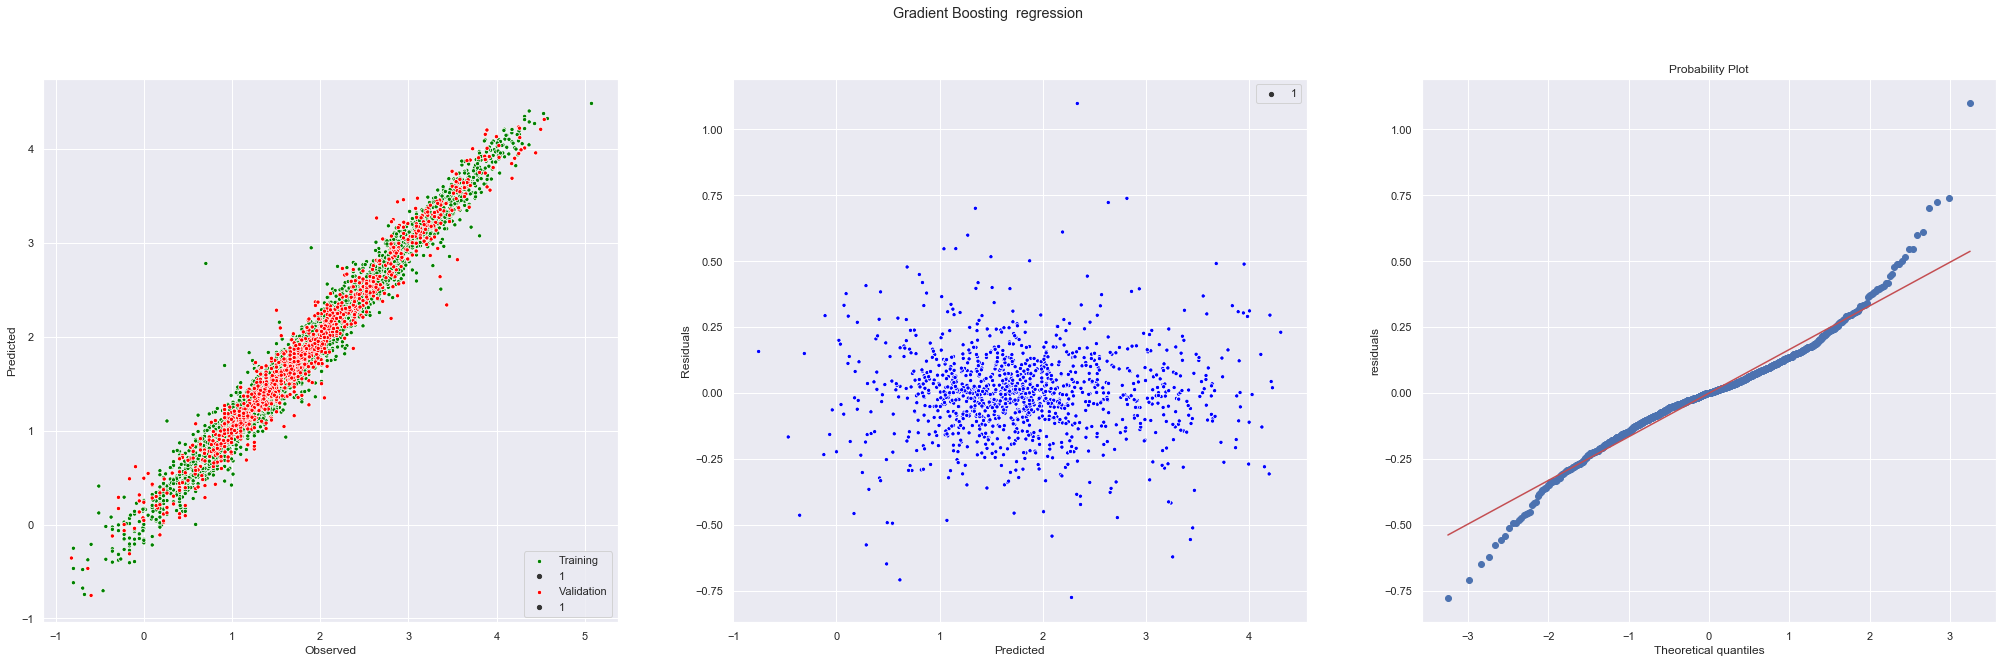

In [39]:
from sklearn.metrics import mean_squared_error as score

train_pred_y = GBM_Regressor.predict(X_train)
test_pred_y = GBM_Regressor.predict(X_test)


#---- Clipping more than zero

vfunc = np.vectorize(lambda x: max(0,x))
#train_pred_y = vfunc(train_pred_y)
#test_pred_y = vfunc(test_pred_y)


#--- Printing the score for validation sets

print(f"\n\n Linear Regression R-Squared: Training = {round(r2_score(train_pred_y, np.log(y_train)),3)}, Validation = {round(r2_score(test_pred_y, np.log(y_test)),3)}")
print(f"\n Linear Regression SCORE: Training = {round(1 - score(train_pred_y, np.log(y_train)),3)}, Validation = {1 - round(score(test_pred_y, np.log(y_test)),3)}")




#          *********** Plot validation and Residuals  ********
plt.figure(figsize= (35,10))
plt.suptitle('Gradient Boosting  regression')
ax1 = plt.subplot(131)
#plt.xscale('log')
#plt.yscale('log')
sns.scatterplot(np.log(y_train),train_pred_y,size=1, color = 'green',label = 'Training',ax=ax1);
sns.scatterplot(np.log(y_test),test_pred_y,size=1,color = 'red', label = 'Validation',ax=ax1);
#plt.axis([1,120,1,120]);
plt.xlabel('Observed');
plt.ylabel('Predicted');
plt.legend(loc = 4);


ax2 = plt.subplot(132)
sns.scatterplot(test_pred_y,(np.log(y_test)-test_pred_y) ,size=1, color = 'blue',ax=ax2)
plt.xlabel('Predicted');
plt.ylabel('Residuals');

ax3 = plt.subplot(133)
stats.probplot(np.log(y_test)-test_pred_y, plot=ax3)
plt.ylabel('residuals');

In [38]:
with open('GBM_Regressor_pipeline.pkl','wb') as f:
    pickle.dump(GBM_Regressor, f, 2)

In [39]:
with open('GBM_Regressor_pipeline.pkl','rb') as f:
    GBM_Regressor = pickle.load(f)

In [13]:
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
le = defaultdict(LabelEncoder)

## H2O Tutorial for Grid search

### Label Encodeing testing 

In [11]:
training_set[['Fuel_Type','Transmission', 'Owner_Type']]

(Index(['Brand', 'Model', 'Location', 'Year', 'Kilometers_Driven', 'Fuel_Type',
        'Transmission', 'Owner_Type', 'Mileage', 'Engine', 'Power', 'Seats',
        'Price'],
       dtype='object'),
 ['Fuel_Type', 'Transmission', 'Owner_Type'])

### H2o Cluster setup

In [15]:
import h2o

#Import the Estimators GLM, RF, 
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators import H2ORandomForestEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator

#Import h2o grid search 
import h2o.grid 
from h2o.grid.grid_search import H2OGridSearch

In [16]:
# H2o init configuartions

local_url = 'http://localhost:54321'
aquarium = False

In [17]:
h2o.init(url=local_url, max_mem_size=6)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_242"; OpenJDK Runtime Environment (build 1.8.0_242-8u242-b08-0ubuntu3~18.04-b08); OpenJDK 64-Bit Server VM (build 25.242-b08, mixed mode)
  Starting server from /home/skumar/miniconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp3ti7mvfz
  JVM stdout: /tmp/tmp3ti7mvfz/h2o_skumar_started_from_python.out
  JVM stderr: /tmp/tmp3ti7mvfz/h2o_skumar_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ------------------------------------------------------------------
H2O cluster uptime:         03 secs
H2O cluster timezone:       Asia/Kolkata
H2O data parsing timezone:  UTC
H2O cluster version:        3.28.0.3
H2O cluster version age:    1 month and 11 days
H2O cluster name:           H2O_from_python_skumar_g37wtd
H2O cluster total nodes:    1
H2O cluster free memory:    5.333 Gb
H2O cluster total cores:    12
H2O cluster allowed cores:  12
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:       {'http': None, 'https': None}
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, TargetEncoder, Core V4
Python version:             3.7.3 final
--------------------------  ------------------------------------------------------------------

### Data set import

In [18]:
train = h2o.H2OFrame(training_set)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [24]:
train.head(5)

Brand Model Location Year Kilometers_Driven Fuel_Type Transmission Owner_Type Mileage Engine Power Seats Price 
 
 
 Maruti Wagon Mumbai 2010 72000 CNG Manual First 26.6 998 58.16 5 1.75 
 Hyundai Creta Pune 2015 41000 Diesel Manual First 19.67 1582 126.2 5 12.5 
 Honda Jazz Chennai 2011 46000 Petrol Manual First 18.2 1199 88.7 5 4.5 
 Maruti Ertiga Chennai 2012 87000 Diesel Manual First 20.77 1248 88.76 7 6 
 Audi A4 Coimbatore 2013 40670 Diesel Automatic Second 15.2 1968 140.8 5 17.74

In [28]:
train.describe()

Rows:5992
Cols:13




Brand Model Location Year Kilometers_Driven Fuel_Type Transmission Owner_Type Mileage Engine Power Seats Price 
 
 
 type enum enum enum int int enum enum enum real int real int real 
 mins 1998.0 171.0 7.5 624.0 34.2 2.0 0.44 
 mean 2013.3673230974657 58738.567423231056 18.33297062750332 1616.9225634178872 112.30222963951933 5.280373831775713 9.41306241655542 
 maxs 2019.0 6500000.0 33.54 5461.0 550.0 10.0 160.0 
 sigma 3.253762042347776 91414.19561018438 4.1547707317679325 590.0992490226677 52.61431610042149 0.7967313422250082 10.981629385480533 
 zeros 0 0 0 0 0 0 0 
 missing 0 0 0 0 0 0 0 0 0 0 0 0 0 
 0 Maruti Wagon Mumbai 2010.0 72000.0 CNG Manual First 26.6 998.0 58.16 5.0 1.75 
 1 Hyundai Creta Pune 2015.0 41000.0 Diesel Manual First 19.67 1582.0 126.2 5.0 12.5 
 2 Honda Jazz Chennai 2011.0 46000.0 Petrol Manual First 18.2 1199.0 88.7 5.0 4.5 
 3 Maruti Ertiga Chennai 2012.0 87000.0 Diesel Manual First 20.77 1248.0 88.76 7.0 6.0 
 4 Audi A4 Coimbatore 2013.0 40670.0 Diesel Automatic Second 15.2 1968.0 140.8 5.0 17.74 
 5 Hyundai EON Hyderabad 2012.0 75000.0 LPG Manual First 21.1 814.0 55.2 5.0 2.35 
 6 Nissan Micra Jaipur 2013.0 86999.0 Diesel Manual First 23.08 1461.0 63.1 5.0 3.5 
 7 Toyota Innova Mumbai 2016.0 36000.0 Diesel Automatic First 11.36 2755.0 171.5 8.0 17.5 
 8 Volkswagen Vento Pune 2013.0 64430.0 Diesel Manual First 20.54 1598.0 103.6 5.0 5.2 
 9 Tata Indica Chennai 2012.0 65932.0 Diesel Manual Second 22.3 1248.0 74.0 5.0 1.95

In [26]:
from sklearn.linear_model import Lasso

In [52]:
# columns segregation
Tar_cols = ['Brand', 'Model', 'Location']
con_cols = ['Kilometers_Driven','Mileage', 'Engine', 'Power']
One_hot_cols = ['Fuel_Type', 'Transmission', 'Owner_Type']
Year = ["Year"]
Seats = ["Seats"]

from sklearn.ensemble import RandomForestRegressor
TransformPipeline_lin = Pipeline([
    ('features',DFFeatureUnion([
        ('numerics', Pipeline([
            ('extract',ColumnExtractor(con_cols)),
            ('log', Log1pTransformer()),
            ('col_Interact',DFadd_ColInteraction('Kilometers_Driven','Mileage')),
            ('col_drop',DFdrop_Cols(cols=['Kilometers_Driven','Mileage','Engine']))])),
        ('nominal_OneHot',Pipeline([
            ('extract',ColumnExtractor(One_hot_cols)),
            ('dummy',DummyTransformer())])),
        ('nominal_Target', Pipeline([
            ('extract',ColumnExtractor(Tar_cols)),
            ('Mean_Enc',TargetEncoder())])),
        ('Year',Pipeline([
            ('extract',ColumnExtractor(Year)),
            ('Shift',ShiftTranformer(par=2019))])),
        ('Seats',Pipeline([
            ('extract',ColumnExtractor(Seats))]))
            
        ])),
    ('feature_selection',DFRecursiveFeatureSelector(Lasso(),n_features=15)),
    ('scale', DFStandardScaler())
    ])

train  = h2o.H2OFrame(TransformPipeline_lin.fit_transform(X_train,y=np.log(y_train)))
test  = h2o.H2OFrame(TransformPipeline_lin.transform(X_test))

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [32]:
training_set.shape, train.columns

((5992, 13),
 ['Kilometers_Driven_&_Mileage',
  'Fuel_Type=CNG',
  'Fuel_Type=Diesel',
  'Fuel_Type=LPG',
  'Fuel_Type=Petrol',
  'Owner_Type=First',
  'Owner_Type=Fourth & Above',
  'Owner_Type=Second',
  'Owner_Type=Third',
  'Transmission=Automatic',
  'Transmission=Manual',
  'Brand',
  'Model',
  'Year',
  'Seats'])

In [38]:
#train, valid = train.split_frame(ratios=[.8], seed=42)
print("train:%d test:%d" % (train.nrows, test.nrows))

train:4793 test:1199


#### Build GLM model

In [74]:
x

['Kilometers_Driven_&_Mileage',
 'Fuel_Type=CNG',
 'Fuel_Type=Diesel',
 'Fuel_Type=LPG',
 'Fuel_Type=Petrol',
 'Owner_Type=First',
 'Owner_Type=Fourth & Above',
 'Owner_Type=Second',
 'Owner_Type=Third',
 'Transmission=Automatic',
 'Transmission=Manual',
 'Brand',
 'Model',
 'Year',
 'Seats']

In [55]:
x = train.col_names
y = 'log_price'

In [77]:
train_y = h2o.H2OFrame().from_python(abs(np.log(y_train)), destination_frame='df', column_names=['log_price'])
test_y = h2o.H2OFrame().from_python(abs(np.log(y_test)), destination_frame='df', column_names=['log_price'])

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [78]:
train = train.concat([train_y])
test = test.concat([test_y])

In [79]:
train_y.describe(),test_y.shape

Rows:4793
Cols:1




log_price 
 
 
 type real 
 mins 0.0 
 mean 1.8372510792593526 
 maxs 4.539777967221039 
 sigma 0.849382101691112 
 zeros 4 
 missing 0 
 0 0.8329091229351039 
 1 1.6582280766035324 
 2 0.2231435513142097 
 3 3.277144732992177 
 4 2.0476928433652555 
 5 1.8718021769015911 
 6 1.9600947840472696 
 7 1.944480556245719 
 8 1.1474024528375415 
 9 0.9162907318741552

(None, (1199, 1))

In [69]:
train.shape,test.shape

((4793, 16), (1199, 16))

In [80]:
glm = H2OGeneralizedLinearEstimator(family = 'Gaussian', model_id = 'default_glm')
%time glm.train(x = x, y ='log_price', training_frame = train, validation_frame = test)

H2OResponseError: Server error java.lang.IllegalArgumentException:
  Error: cbind frames must have all the same rows, found 4793 and 1199 rows.
  Request: POST /99/Rapids
    data: {'ast': '(tmp= py_25_sid_86a1 (cbind Key_Frame__upload_ac9bcdc18928c628a9560d762f614836.hex df df))', 'session_id': '_sid_86a1'}


## Preparing Inputs for  Model Deployment

In [50]:
with open('gbm_model_dump.pkl', 'wb') as f:
    pickle.dump(model, f, 2)

In [25]:
with open('gbm_model_dump.pkl', 'rb') as f:
    model = pickle.load(f)

In [27]:
X_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6019 entries, 0 to 6018
Data columns (total 12 columns):
Brand                6019 non-null int64
Model                6019 non-null int64
Location             6019 non-null int64
Year                 6019 non-null int64
Kilometers_Driven    6019 non-null int64
Fuel_Type            6019 non-null int64
Transmission         6019 non-null int64
Owner_Type           6019 non-null int64
Mileage              6019 non-null float64
Engine               6019 non-null float64
Power                6019 non-null float64
Seats                6019 non-null float64
dtypes: float64(4), int64(8)
memory usage: 564.4 KB


### segregate categories and int

In [26]:
# columns groups based on dypes int(represents discrete and categories vs float)
int_cols = list(X_train_data.select_dtypes(include='int'))
int_cols.remove('Kilometers_Driven')
float_cols = list(X_train_data.select_dtypes(include='float'))+['Kilometers_Driven']

In [31]:
X_train_data.describe()

Brand        Model     Location         Year  Kilometers_Driven  \
count  6019.000000  6019.000000  6019.000000  6019.000000       6.019000e+03   
mean     16.382123   113.415684     5.619704  2013.358199       5.873838e+04   
std       8.594181    67.382592     2.955933     3.269742       9.126884e+04   
min       0.000000     0.000000     0.000000  1998.000000       1.710000e+02   
25%      10.000000    54.000000     3.000000  2011.000000       3.400000e+04   
50%      18.000000   103.000000     6.000000  2014.000000       5.300000e+04   
75%      20.000000   176.000000     8.000000  2016.000000       7.300000e+04   
max      32.000000   218.000000    10.000000  2019.000000       6.500000e+06   

         Fuel_Type  Transmission   Owner_Type      Mileage       Engine  \
count  6019.000000   6019.000000  6019.000000  6019.000000  6019.000000   
mean      2.363017      0.714238     0.379465    18.134584  1618.738827   
std       1.504939      0.451814     0.818458     4.581574   600.445858   
min       0.000000      0.000000     0.000000     0.000000    72.000000   
25%       1.000000      0.000000     0.000000    15.170000  1197.000000   
50%       1.000000      1.000000     0.000000    18.150000  1493.000000   
75%       4.000000      1.000000     0.000000    21.100000  1969.000000   
max       4.000000      1.000000     3.000000    33.540000  5998.000000   

             Power        Seats  
count  6019.000000  6019.000000  
mean    112.320472     5.276790  
std      53.565700     0.806346  
min      34.200000     0.000000  
25%      74.000000     5.000000  
50%      91.100000     5.000000  
75%     138.030000     5.000000  
max     560.000000    10.000000

### Min, Max and Default values for variables

In [67]:
# Get default values to show for app is run the first and stores them in dictionary to 
# get mapping
from scipy import stats

default_dict = dict()
min_dict = dict()
max_dict = dict()



for col in list(X_train_data):
    if col in int_cols:
        exec("default_"+col + " =  stats.mode(X_train_data[col]).mode")
        exec("min_"+col + " =  np.min(X_train_data[col])")
        exec("max_"+col + " =  np.max(X_train_data[col])")
        exec("default_dict['"+col+"']  =  default_"+col+".item()")
        exec("min_dict['"+col+"']  =  min_"+col)
        exec("max_dict['"+col+"']  =  max_"+col)
    if col in float_cols:
        exec("default_"+col + " =  np.mean(X_train_data[col].values,keepdims=True)")
        exec("min_"+col + " =  np.min(X_train_data[col])")
        exec("max_"+col + " =  np.max(X_train_data[col])")
        exec("default_dict['"+col+"']  =  default_"+col+".item()")
        exec("min_dict['"+col+"']  =  min_"+col)
        exec("max_dict['"+col+"']  =  max_"+col)

default_dict['Brand']
default_dict['Model']
default_dict['Location']
default_dict['Year']
default_dict['Fuel_Type']
default_dict['Transmission']
default_dict['Owner_Type']


### Look at default values label encoded tranformed back to categories

In [91]:
default_dict_mapped

{'Brand': array(['Maruti'], dtype='<U13'),
 'Model': array(['Swift'], dtype='<U11'),
 'Location': array(['Mumbai'], dtype='<U10'),
 'Fuel_Type': array(['Diesel'], dtype='<U8'),
 'Transmission': array(['Manual'], dtype='<U9'),
 'Owner_Type': array(['First'], dtype='<U14')}

In [90]:
# mapping Dictionary for default values
default_dict_mapped = dict()
default_dict_mapped['Brand'] = le_brands.inverse_transform([default_dict['Brand']])
default_dict_mapped['Model'] = le_models.inverse_transform([default_dict['Model']])
default_dict_mapped['Location'] = le_locations.inverse_transform([default_dict['Location']])
default_dict_mapped['Fuel_Type'] = le_fuel_types.inverse_transform([default_dict['Fuel_Type']])
default_dict_mapped['Transmission'] = le_transmissions.inverse_transform([default_dict['Transmission']])
default_dict_mapped['Owner_Type'] = le_owner_types.inverse_transform([default_dict['Owner_Type']])


In [19]:
# Create Encoded dictionaries that store encoded mapping

encoders = ['le_brands','le_models','le_locations','le_fuel_types','le_transmissions','le_owner_types']

for i in encoders:
    print(i+"_Encdict")
    exec(i+"_Encdict = dict(zip("+i+".classes_, "+i+".transform("+i+".classes_)))")

le_brands_Encdict
le_models_Encdict
le_locations_Encdict
le_fuel_types_Encdict
le_transmissions_Encdict
le_owner_types_Encdict


### Let's put all dictictiories in list 

### min, max, default values to categories mapping dictionary 

In [93]:
Dicts = [default_dict,min_dict, max_dict, default_dict_mapped]

In [94]:
with open('Dictionaries.pkl', 'wb') as f:
    pickle.dump(Dicts, f, 2)

### Encoded values to categories mapping dictionary 

In [21]:
Encoded_dicts = [le_brands_Encdict,le_models_Encdict,le_locations_Encdict,le_fuel_types_Encdict,le_transmissions_Encdict,le_owner_types_Encdict]

In [22]:
with open('Encoded_dicts.pkl','wb') as f:
    pickle.dump(Encoded_dicts, f, 2)

In [67]:
# min, max, default values to categories mapping dictionary
with open('Dictionaries.pkl', 'rb') as f:
    default_dict,min_dict, max_dict, default_dict_mapped= pickle.load(f)

# Encoded values to categories mapping dictionary
with open('Encoded_dicts.pkl', 'rb') as f:

    

### Model to brand mapping dictionary model2brand

In [60]:
model2brand

{'Ambassador': ['Classic'],
 'Audi': ['Q3', 'A7', 'A4', 'A8', 'RS5', 'Q7', 'A6', 'A3', 'TT', 'Q5'],
 'BMW': ['5', 'X3', 'Z4', '1', 'X5', '7', 'X1', '3', 'X6', '6'],
 'Bentley': ['Continental'],
 'Chevrolet': ['Sail',
  'Optra',
  'Beat',
  'Captiva',
  'Spark',
  'Tavera',
  'Enjoy',
  'Cruze',
  'Aveo'],
 'Datsun': ['redi-GO', 'Redi', 'GO'],
 'Fiat': ['Siena', 'Punto', 'Avventura', 'Grande', 'Petra', 'Linea'],
 'Force': ['One'],
 'Ford': ['Aspire',
  'Mustang',
  'Fusion',
  'EcoSport',
  'Endeavour',
  'Freestyle',
  'Figo',
  'Classic',
  'Ecosport',
  'Fiesta',
  'Ikon'],
 'Honda': ['Jazz',
  'CR-V',
  'WRV',
  'BR-V',
  'Amaze',
  'WR-V',
  'Mobilio',
  'City',
  'Civic',
  'Accord',
  'Brio',
  'BRV'],
 'Hyundai': ['Elantra',
  'Tucson',
  'Santa',
  'i20',
  'Santro',
  'i10',
  'Getz',
  'Grand',
  'Creta',
  'Xcent',
  'EON',
  'Verna',
  'Elite',
  'Accent',
  'Sonata'],
 'ISUZU': ['D-MAX'],
 'Isuzu': ['MUX'],
 'Jaguar': ['F', 'XJ', 'XE', 'XF'],
 'Jeep': ['Compass'],
 'Lambor

In [61]:
with open('model2brand.pkl','wb') as f:
    pickle.dump(model2brand, f, 2)

In [9]:
with open('gbm_model_dump.pkl', 'rb') as f:
        gbm_model = pickle.load(f)

In [2]:
min_dict

{'Brand': 0,
 'Model': 0,
 'Location': 0,
 'Year': 1998,
 'Kilometers_Driven': 171,
 'Fuel_Type': 0,
 'Transmission': 0,
 'Owner_Type': 0,
 'Mileage': 0.0,
 'Engine': 72.0,
 'Power': 34.2,
 'Seats': 0.0}

In [11]:
default_dict

{'Brand': 19,
 'Model': 176,
 'Location': 9,
 'Year': 2014,
 'Kilometers_Driven': 58738.38029573019,
 'Fuel_Type': 1,
 'Transmission': 1,
 'Owner_Type': 0,
 'Mileage': 18.134583817909952,
 'Engine': 1618.7388270476824,
 'Power': 112.32047183917594,
 'Seats': 5.2767901644791495}

In [3]:
max_dict

{'Brand': 32,
 'Model': 218,
 'Location': 10,
 'Year': 2019,
 'Kilometers_Driven': 6500000,
 'Fuel_Type': 4,
 'Transmission': 1,
 'Owner_Type': 3,
 'Mileage': 33.54,
 'Engine': 5998.0,
 'Power': 560.0,
 'Seats': 10.0}

In [16]:
from flask import Flask, render_template, flash, request, jsonify

In [2]:
le_brands_Encdict

{'Ambassador': 0,
 'Audi': 1,
 'BMW': 2,
 'Bentley': 3,
 'Chevrolet': 4,
 'Datsun': 5,
 'Fiat': 6,
 'Force': 7,
 'Ford': 8,
 'Hindustan': 9,
 'Honda': 10,
 'Hyundai': 11,
 'ISUZU': 12,
 'Isuzu': 13,
 'Jaguar': 14,
 'Jeep': 15,
 'Lamborghini': 16,
 'Land': 17,
 'Mahindra': 18,
 'Maruti': 19,
 'Mercedes-Benz': 20,
 'Mini': 21,
 'Mitsubishi': 22,
 'Nissan': 23,
 'OpelCorsa': 24,
 'Porsche': 25,
 'Renault': 26,
 'Skoda': 27,
 'Smart': 28,
 'Tata': 29,
 'Toyota': 30,
 'Volkswagen': 31,
 'Volvo': 32}

In [65]:
del le_owner_types_Encdict

In [68]:
le_owner_types_Encdict

{'First': 0, 'Fourth & Above': 1, 'Second': 2, 'Third': 3}